In [2]:
### from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [3]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [4]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [5]:
# %%javascript
# var nb = IPython.notebook;
# var kernel = IPython.notebook.kernel;
# var command = "NOTEBOOK_NAME = '" + nb.base_url + nb.notebook_path + "'";
# kernel.execute(command);

In [6]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'decoder_weights_1sec_dhpc_w35and36'

In [7]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

Unable to restore variable 'do_test_within_weights', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'Gini', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'gini', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'linregress_residuals', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'load_all_animals_vars', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)


In [7]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [8]:
all_animals = 'dhpcg1','dhpc24',  'dhpcg20','dhpc35','dhpc36'
expo_animals = 'dhpcg1','dhpc24', 'dhpcg20','dhpc35','dhpc36'
pre_animals = 'dhpcg1','dhpc24'            ,'dhpc35','dhpc36'
post_animals = 'dhpcg1','dhpc24', 'dhpcg20','dhpc35','dhpc36'
renew_animals = 'dhpcg1','dhpc24','dhpcg20','dhpc35','dhpc36'
ext2_animals = 'dhpcg1','dhpc24', 'dhpcg20','dhpc35','dhpc36'
ext1_animals = 'dhpcg1','dhpc24', 'dhpcg20','dhpc35','dhpc36'

In [84]:
sessions = 'expo', 'pre', 'post', 'ext1', 'ext2', 'renew'
session_labels = 'Pre','Early','Late','Ext1','Ext2','Reinstate'
colors = ('forestgreen','darkcyan','firebrick','lightgrey','dimgrey','goldenrod')

In [10]:
for sess in 'pre', 'post', 'ext1', 'ext2', 'renew':

    exec("patterns_tb_%s = dict(zip(%s_animals, [ut.load_variable('patterns_tb',\
                                                           '../%%s/%s/notebooks/autorestore/decoding_around_onset/'%%ani)\
                                                  for ani in %s_animals]))"%(sess, sess, sess, sess))
    exec("labels_%s = dict(zip(%s_animals, [ut.load_variable('labels',\
                                                         '../%%s/%s/notebooks/autorestore/decoding_around_onset/'%%ani)\
                                                  for ani in %s_animals]))"%(sess, sess, sess, sess))

In [11]:
#have to extract 2_odor_expo varibles differently from that used above
patterns_tb_expo = dict(zip(expo_animals,
                                [ut.load_variable('patterns_tb','../%s/2_odor_expo/notebooks/autorestore/decoding_around_onset'%ani)
                                                  for ani in expo_animals]))

labels_expo = dict(zip(expo_animals,
                                [ut.load_variable('labels','../%s/2_odor_expo/notebooks/autorestore/decoding_around_onset'%ani)
                                                  for ani in expo_animals]))

In [12]:
#from referenced notebook, 16 time bins total beginning at -5s prior to odor onset and running through 11s post onset

#t_start0 = -5  # sec
#t_stop0 = 11  # sec

# CS BEGINS AT TIME BIN 6 (tb5)
# TRACE BEGINS AT TB 8
# REWARD DELIVERED AT TB 10

In [13]:
from sklearn.svm import SVC
def do_test_within_weights(patterns, labels):
    
    patterns_comb_weights, labels_comb_weights = ut.combine_patterns(patterns, labels)
    decoder.fit(patterns_comb_weights,labels_comb_weights)
    weights = decoder.coef_[0]
    return weights

In [ ]:
def do_test_cross_weights(patterns_t, labels_t, patterns_T, labels_T, n_cells=None):
    patterns_comb_train, labels_comb = ut.combine_patterns(patterns_t, labels_t)
    patterns_comb_test, labels_comb = ut.combine_patterns(patterns_T, labels_T)
    if n_cells is None:
        cells = list(range(patterns_comb_train.shape[1]))
    else:
        cells = np.random.choice(range(patterns_comb_train.shape[1]), size=n_cells, replace=False)
    decoder.fit(patterns_comb_train[:, cells], labels_comb)
    scores = decoder.score(patterns_comb_test[:, cells], labels_comb)
    decoder.fit(patterns_comb_test[:, cells], labels_comb)
    return np.append(scores, decoder.score(patterns_comb_train[:, cells], labels_comb))

In [14]:
decoder = SVC(kernel='linear', decision_function_shape='ovo')

In [15]:
import collections
for sess in sessions:
    for t in range(16):
        exec('patterns_tb_%s_%s = {}'%(t, sess))
        for ani in eval('%s_animals'%sess):
            try:
                print sess,
                print ani,
                exec("patterns_tb_%s_%s['%s'] = patterns_tb_%s['%s'][%s]"%(t,sess,ani,sess,ani,t))
            except IOError as error:
                print error
            continue
        #now sort the dictionary so we have a standardized way of ordering dict data across notebooks!
        exec("patterns_tb_%s_%s = collections.OrderedDict(sorted(patterns_tb_%s_%s.items()))"%(t,sess,t,sess))

expo dhpcg1 expo dhpc24 expo dhpcg20 expo dhpc35 expo dhpc36 expo dhpcg1 expo dhpc24 expo dhpcg20 expo dhpc35 expo dhpc36 expo dhpcg1 expo dhpc24 expo dhpcg20 expo dhpc35 expo dhpc36 expo dhpcg1 expo dhpc24 expo dhpcg20 expo dhpc35 expo dhpc36 expo dhpcg1 expo dhpc24 expo dhpcg20 expo dhpc35 expo dhpc36 expo dhpcg1 expo dhpc24 expo dhpcg20 expo dhpc35 expo dhpc36 expo dhpcg1 expo dhpc24 expo dhpcg20 expo dhpc35 expo dhpc36 expo dhpcg1 expo dhpc24 expo dhpcg20 expo dhpc35 expo dhpc36 expo dhpcg1 expo dhpc24 expo dhpcg20 expo dhpc35 expo dhpc36 expo dhpcg1 expo dhpc24 expo dhpcg20 expo dhpc35 expo dhpc36 expo dhpcg1 expo dhpc24 expo dhpcg20 expo dhpc35 expo dhpc36 expo dhpcg1 expo dhpc24 expo dhpcg20 expo dhpc35 expo dhpc36 expo dhpcg1 expo dhpc24 expo dhpcg20 expo dhpc35 expo dhpc36 expo dhpcg1 expo dhpc24 expo dhpcg20 expo dhpc35 expo dhpc36 expo dhpcg1 expo dhpc24 expo dhpcg20 expo dhpc35 expo dhpc36 expo dhpcg1 expo dhpc24 expo dhpcg20 expo dhpc35 expo dhpc36 pre dhpcg1 pre dhpc24 pr

In [16]:
print patterns_tb_5_expo.keys()
print patterns_tb_5_pre.keys()
print patterns_tb_5_post.keys()
print patterns_tb_5_ext1.keys()
print patterns_tb_5_ext2.keys()
print patterns_tb_5_renew.keys()

['dhpc24', 'dhpc35', 'dhpc36', 'dhpcg1', 'dhpcg20']
['dhpc24', 'dhpc35', 'dhpc36', 'dhpcg1']
['dhpc24', 'dhpc35', 'dhpc36', 'dhpcg1', 'dhpcg20']
['dhpc24', 'dhpc35', 'dhpc36', 'dhpcg1', 'dhpcg20']
['dhpc24', 'dhpc35', 'dhpc36', 'dhpcg1', 'dhpcg20']
['dhpc24', 'dhpc35', 'dhpc36', 'dhpcg1', 'dhpcg20']


In [17]:
%%time
#get decoder weights for each cell
for t in range(16): # number of time bins
    exec('weights_tb_%s = {}'%t)
    n_loops = 100
    for sess in sessions:
        print sess,
        print t,
        eval("weights_tb_%s"%t)[sess] = [do_test_within_weights(eval('patterns_tb_%s_%s'%(t,sess)),eval('labels_%s'%sess)) for i in range(n_loops)]

expo 0 pre 0 post 0 ext1 0 ext2 0 renew 0 expo 1 pre 1 post 1 ext1 1 ext2 1 renew 1 expo 2 pre 2 post 2 ext1 2 ext2 2 renew 2 expo 3 pre 3 post 3 ext1 3 ext2 3 renew 3 expo 4 pre 4 post 4 ext1 4 ext2 4 renew 4 expo 5 pre 5 post 5 ext1 5 ext2 5 renew 5 expo 6 pre 6 post 6 ext1 6 ext2 6 renew 6 expo 7 pre 7 post 7 ext1 7 ext2 7 renew 7 expo 8 pre 8 post 8 ext1 8 ext2 8 renew 8 expo 9 pre 9 post 9 ext1 9 ext2 9 renew 9 expo 10 pre 10 post 10 ext1 10 ext2 10 renew 10 expo 11 pre 11 post 11 ext1 11 ext2 11 renew 11 expo 12 pre 12 post 12 ext1 12 ext2 12 renew 12 expo 13 pre 13 post 13 ext1 13 ext2 13 renew 13 expo 14 pre 14 post 14 ext1 14 ext2 14 renew 14 expo 15 pre 15 post 15 ext1 15 ext2 15 renew 15CPU times: user 2h 54min 33s, sys: 9min 39s, total: 3h 4min 12s
Wall time: 7min 57s



In [18]:
#get absolute values of weights
for t in range(16): # number of time bins
    exec("abs_weights_tb_%s = {}"%t)
    for sess in sessions:
        exec("abs_weights_tb_%s[sess] = []"%t)
        for x,i in zip(eval("weights_tb_%s[sess]"%t),range(len(eval("weights_tb_%s[sess]"%t)))):
            eval("abs_weights_tb_%s[sess].append(abs(x))"%t)

In [19]:
%%time
#normalize abs weights by the total sum of weights for each loop
for tb in range(16):
    exec("sum_norm_abs_weights_tb_%s = {}"%tb)
    for sess in sessions:
        exec("sum_norm_abs_weights_tb_%s[sess]=[[]*1]*100"%tb) #initialize list of 100 lists (100 = n_loops from above)
        for x,y in zip(eval("abs_weights_tb_%s[sess]"%tb),range(len(eval("abs_weights_tb_%s[sess]"%tb)))):
            exec("sum_norm_abs_weights_tb_%s[sess][y]=[]"%tb)
            for i in x:
                eval("sum_norm_abs_weights_tb_%s[sess][y]"%tb).append(float(i)/sum(np.array(eval("abs_weights_tb_%s[sess][y]"%tb))))
        print sess,tb,"DONE!",

expo 0 DONE! pre 0 DONE! post 0 DONE! ext1 0 DONE! ext2 0 DONE! renew 0 DONE! expo 1 DONE! pre 1 DONE! post 1 DONE! ext1 1 DONE! ext2 1 DONE! renew 1 DONE! expo 2 DONE! pre 2 DONE! post 2 DONE! ext1 2 DONE! ext2 2 DONE! renew 2 DONE! expo 3 DONE! pre 3 DONE! post 3 DONE! ext1 3 DONE! ext2 3 DONE! renew 3 DONE! expo 4 DONE! pre 4 DONE! post 4 DONE! ext1 4 DONE! ext2 4 DONE! renew 4 DONE! expo 5 DONE! pre 5 DONE! post 5 DONE! ext1 5 DONE! ext2 5 DONE! renew 5 DONE! expo 6 DONE! pre 6 DONE! post 6 DONE! ext1 6 DONE! ext2 6 DONE! renew 6 DONE! expo 7 DONE! pre 7 DONE! post 7 DONE! ext1 7 DONE! ext2 7 DONE! renew 7 DONE! expo 8 DONE! pre 8 DONE! post 8 DONE! ext1 8 DONE! ext2 8 DONE! renew 8 DONE! expo 9 DONE! pre 9 DONE! post 9 DONE! ext1 9 DONE! ext2 9 DONE! renew 9 DONE! expo 10 DONE! pre 10 DONE! post 10 DONE! ext1 10 DONE! ext2 10 DONE! renew 10 DONE! expo 11 DONE! pre 11 DONE! post 11 DONE! ext1 11 DONE! ext2 11 DONE! renew 11 DONE! expo 12 DONE! pre 12 DONE! post 12 DONE! ext1 12 DON

In [20]:
for t in range(16): # number of time bins
    exec("avg_sum_norm_abs_weights_tb_%s = {}"%t)
    for sess in sessions:
        exec("avg_sum_norm_abs_weights_tb_%s[sess] = [np.mean(k) for k in zip(*sum_norm_abs_weights_tb_%s[sess])]"%(t,t))

In [21]:
#for t in range(16): # number of time bins
#    exec("avg_weights_tb_%s = {}"%t)
#    exec("abs_avg_weights_tb_%s = {}"%t)
#    exec("avg_abs_weights_tb_%s = {}"%t)
#    for sess in sessions:
#        exec("avg_weights_tb_%s[sess] = [np.mean(k) for k in zip(*weights_tb_%s[sess])]"%(t,t))
#        exec("avg_abs_weights_tb_%s[sess] = [np.mean(k) for k in zip(*abs_weights_tb_%s[sess])]"%(t,t))
#        exec("abs_avg_weights_tb_%s[sess] = map(abs,avg_weights_tb_%s[sess])"%(t,t))

In [22]:
##normalize avg weights by the total sum of weights
#for tb in range(16):
#    exec("sum_norm_avg_weights_tb_%s = {}"%tb)
#    for sess in sessions:
#        exec("sum_norm_avg_weights_tb_%s[sess]=[]"%tb)
#        for i,x in zip(eval("avg_weights_tb_%s[sess]"%tb),range(len(eval("avg_weights_tb_%s[sess]"%tb)))):
#            eval("sum_norm_avg_weights_tb_%s[sess]"%tb).insert(x,float(abs(i))/sum(abs(np.array(eval("avg_weights_tb_%s[sess]"%tb)))))

In [23]:
#for tb in range(16):
#    exec("sum_norm_avg_abs_weights_tb_%s = {}"%tb)
#    for sess in sessions:
#        exec("sum_norm_avg_abs_weights_tb_%s[sess]=[]"%tb)
#        for i,x in zip(eval("avg_abs_weights_tb_%s[sess]"%tb),range(len(eval("avg_abs_weights_tb_%s[sess]"%tb)))):
#            eval("sum_norm_avg_abs_weights_tb_%s[sess]"%tb).insert(x,float(abs(i))/sum(abs(np.array(eval("avg_abs_weights_tb_%s[sess]"%tb)))))

In [24]:
#fig, ax = pl.subplots(6,1, figsize=(2.5, 10),sharex=True,sharey=True)
#i=-1
#for sess in sessions:
#    i=i+1
#    x = sum_norm_avg_weights_tb_6[sess]
#    y = sum_norm_avg_weights_tb_8[sess]
#    ax[i].plot(x,y,'ro',markersize=.8,mew=.1,scalex=False,scaley=False)
#    #ax[i].set_xlim(-.08,.08)
#    #ax[i].set_ylim(-.08,.08)
#    for tb,lc,d in zip(('3','4'),('r','b'),
#                       ('Tr','US')):
#        y = eval("sum_norm_avg_weights_tb_%s[sess]"%tb)
#        slope, intercept, r_value, p_value, std_err = sstats.linregress(x,y)
#        line = slope*(np.unique(x))+intercept
#        r2 = r_value*r_value
#        ax[i].plot(np.unique(x), line, '%s'%lc, label='CS vs {}, r$^2$={:.2f}'.format(d,r2))
#    ax[i].set_title(sess)
#    ax[0].set_title('expo\nCS vs Tr')
#    ax[i].legend(loc='best',prop={'size': 3})
#    ax[i].set_ylabel("decoder weights, Tr\n(sum normalized)",fontsize=5)
#pl.xlabel("decoder weights, CS\n(sum normalized)",fontsize=5)
#
##pl.xlim(-.08,.08)
##pl.ylim(-.08,.08)
#fig.tight_layout(pad=3)

In [25]:
#fig, ax = pl.subplots(6,1, figsize=(2.5, 10),sharex=True,sharey=True)
#i=-1
#
#for sess in sessions:
#    i=i+1
#    x = sum_norm_avg_abs_weights_tb_6[sess]
#    y = sum_norm_avg_abs_weights_tb_8[sess]
#    ax[i].plot(x,y,'ro',markersize=.8,mew=.1,scalex=False,scaley=False)
#    #ax[i].set_xlim(-.08,.08)
#    #ax[i].set_ylim(-.08,.08)
#    for tb,lc,d in zip(('3','4'),('r','b'),
#                       ('Tr','US')):
#        y = eval("sum_norm_avg_abs_weights_tb_%s[sess]"%tb)
#        slope, intercept, r_value, p_value, std_err = sstats.linregress(x,y)
#        line = slope*(np.unique(x))+intercept
#        r2 = r_value*r_value
#        ax[i].plot(np.unique(x), line, '%s'%lc, label='CS vs {}, r$^2$={:.2f}'.format(d,r2))
#    ax[i].set_title(sess)
#    ax[0].set_title('expo\nCS vs Tr')
#    ax[i].legend(loc='best',prop={'size': 3})
#    ax[i].set_ylabel("decoder weights, Tr\n(sum normalized)",fontsize=5)
#pl.xlabel("decoder weights, CS\n(sum normalized)",fontsize=5)
#
##pl.xlim(-.08,.08)
##pl.ylim(-.08,.08)
#fig.tight_layout(pad=3)

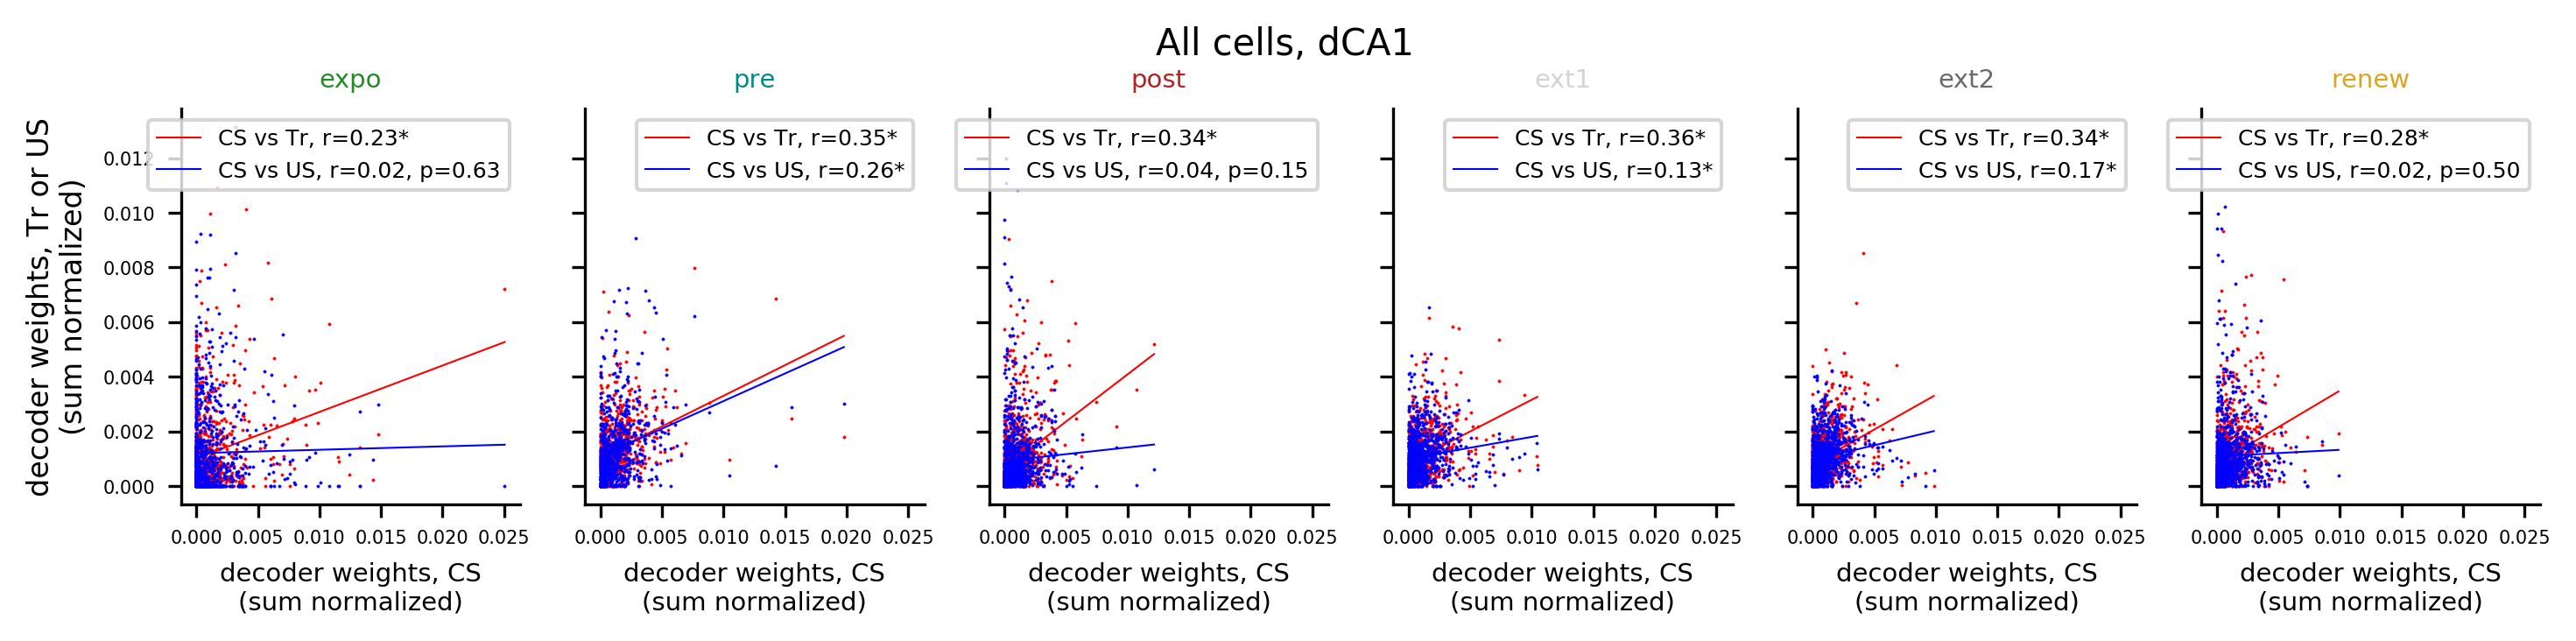

In [27]:
fig, ax = pl.subplots(1,6, figsize=(10, 2.5),sharex=True,sharey=True)
i=-1

for sess in sessions:
    i=i+1
    x = avg_sum_norm_abs_weights_tb_6[sess]
    for tb,lc,q,d in zip(('8','10'),('r','b'),('ro','bo'),
                       ('Tr','US')):
        y = eval("avg_sum_norm_abs_weights_tb_%s[sess]"%tb)
        slope, intercept, r_value, p_value, std_err = sstats.linregress(x,y)
        line = slope*(np.unique(x))+intercept
        r2 = r_value*r_value
        if p_value < 0.05:
            lbl = '*'
        else:
            lbl = ', p={:.2f}'.format(p_value)
        ax[i].plot(x,y,q,markersize=.8,mew=.1,scalex=False,scaley=False)
        ax[i].plot(np.unique(x), line, '%s'%lc, label='CS vs {}, r={:.2f}'.format(d,r_value)+lbl)
    ax[i].set_title(sess,color=colors[i])
    ax[0].set_title('expo')
    ax[i].legend(loc='best',prop={'size': 6})
    ax[0].set_ylabel("decoder weights, Tr or US\n(sum normalized)",fontsize=8)
    ax[i].set_xlabel("decoder weights, CS\n(sum normalized)",fontsize=7)
pl.suptitle('All cells, dCA1',fontsize=10)


#pl.xlim(-.08,.08)
#pl.ylim(-.08,.08)
fig.tight_layout(pad=3)
pl.savefig("../img/%s_weights_vs_weights_ALLcells.pdf"%NOTEBOOK_NAME)

In [28]:
reference_tbs = range(16)

In [29]:
##plot CDF of weights
#fig, ax = pl.subplots(6,1, figsize=(2.5,8), sharex=True,sharey=True)
#colors = ['limegreen','b','r','silver','grey','y']
#bins=30
#for x,sess in zip(range(len(sessions)),sessions):
#    ax[x].hist(sum_norm_avg_weights_tb_6[sess], bins=bins,normed=False, cumulative=True, label='CS',
#           histtype='step', alpha=0.8, color='r')
#    ax[x].hist(sum_norm_avg_weights_tb_8[sess], bins=bins,normed=False, cumulative=True, label='Tr',
#           histtype='step', alpha=0.8, color='b')
#    ax[x].legend(loc='upper center')
#    ax[x].set_ylabel('CDF (cells)')
#    ax[x].set_title(sess,color=colors[x])
#    #ax[x].set_yticks((0,.2,.4,.6,.8,1))
#    #ax[x].set_yticklabels((len(avg_weights_tb_0[sess]),int(len(avg_weights_tb_0[sess])*.8),int(len(avg_weights_tb_0[sess])*.6),
#    #                       int(len(avg_weights_tb_0[sess])*.4),int(len(avg_weights_tb_0[sess])*.2),'0'))
#    #ax[x].set_xlim(0,.02)
#    #ax[x].invert_xaxis()
#    #ax[x].invert_yaxis()
#pl.xlabel("Decoder weights\n(sum normalized)")
#pl.suptitle("2sec time bin decoding weights (vCA1)")
#fig.tight_layout(pad=3.5)
#pl.savefig("../img/%s_weights_CDF.jpg"%NOTEBOOK_NAME)

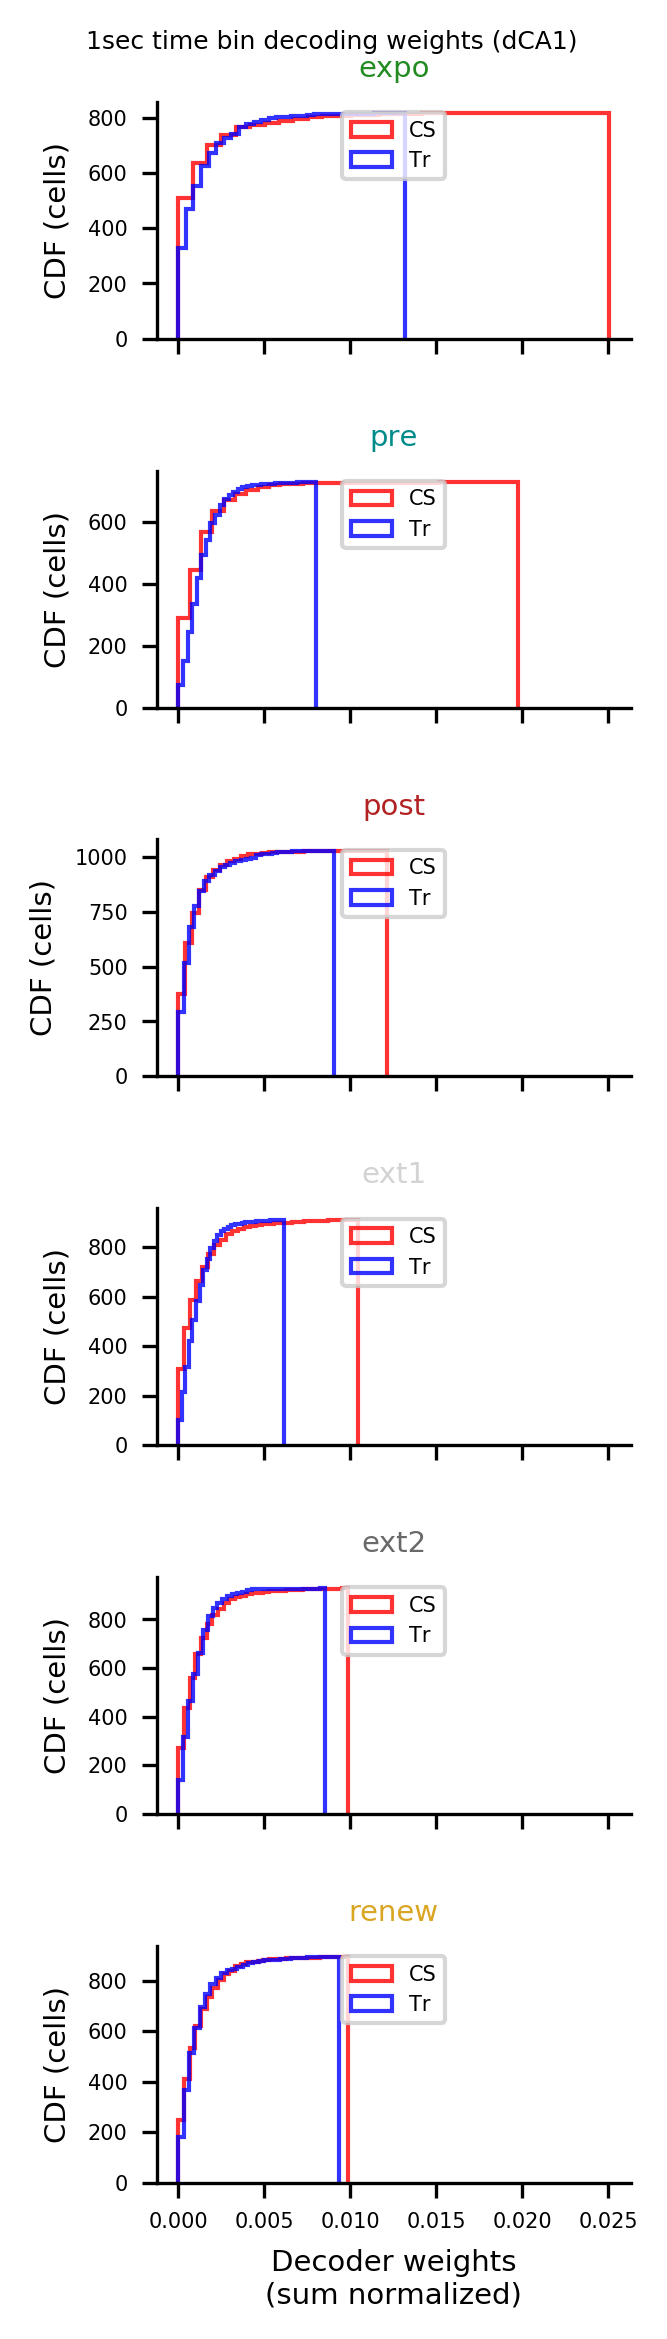

In [30]:
#plot CDF of weights
fig, ax = pl.subplots(6,1, figsize=(2.5,8), sharex=True,sharey=False)
colors = ('forestgreen','darkcyan','firebrick','lightgrey','dimgrey','goldenrod')
bins=30
for x,sess in zip(range(len(sessions)),sessions):
    ax[x].hist(avg_sum_norm_abs_weights_tb_6[sess], bins=bins,normed=False, cumulative=True, label='CS',
           histtype='step', alpha=0.8, color='r')
    ax[x].hist(avg_sum_norm_abs_weights_tb_8[sess], bins=bins,normed=False, cumulative=True, label='Tr',
           histtype='step', alpha=0.8, color='b')
    ax[x].legend(loc='upper center')
    ax[x].set_ylabel('CDF (cells)')
    ax[x].set_title(sess,color=colors[x])
    #ax[x].set_yticks((0,.2,.4,.6,.8,1))
    #ax[x].set_yticklabels((len(avg_weights_tb_0[sess]),int(len(avg_weights_tb_0[sess])*.8),int(len(avg_weights_tb_0[sess])*.6),
    #                       int(len(avg_weights_tb_0[sess])*.4),int(len(avg_weights_tb_0[sess])*.2),'0'))
    #ax[x].set_xlim(0,.02)
    #ax[x].invert_xaxis()
    #ax[x].invert_yaxis()
pl.xlabel("Decoder weights\n(sum normalized)")
pl.suptitle("1sec time bin decoding weights (dCA1)")
fig.tight_layout(pad=3.5)
pl.savefig("../img/%s_weights_CDF.jpg"%NOTEBOOK_NAME)

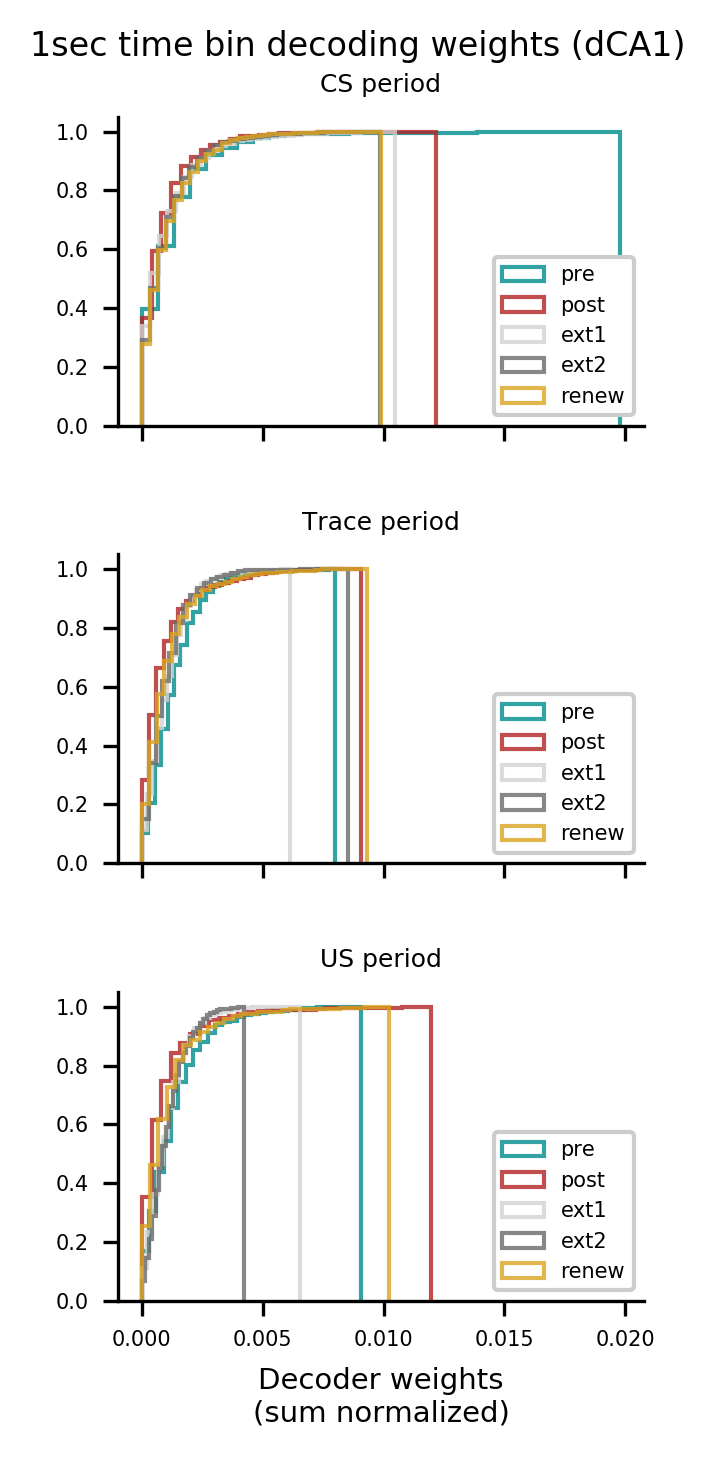

In [31]:
sessionsb=sessions[1:]
fig, ax = pl.subplots(3,1, figsize=(2.5,5), sharex=True,sharey=False)
colors = ('darkcyan','firebrick','lightgrey','dimgrey','goldenrod')
bins=30
for i,y in zip(range(3),[6,8,10]):
    for x,sess in zip(range(len(sessionsb)),sessionsb):
        ax[i].hist(eval("avg_sum_norm_abs_weights_tb_%s"%y)[sess], bins=bins,normed=True, cumulative=True, label=sess,
               histtype='step', alpha=0.8, color=colors[x])
        ax[i].legend(loc='lower right',framealpha=1)
        #pl.ylabel('CDF (cells)')
        #ax[x].set_xlim(0,.02)
        #ax[x].invert_xaxis()
        #ax[x].invert_yaxis()
pl.xlabel("Decoder weights\n(sum normalized)")
ax[0].set_title('CS period',fontsize=6)
ax[1].set_title('Trace period',fontsize=6)
ax[2].set_title('US period',fontsize=6)
pl.suptitle("1sec time bin decoding weights (dCA1)",fontsize=8)
fig.tight_layout(pad=3.5)
#pl.savefig("../img/%s_weights_CDF.jpg"%NOTEBOOK_NAME)

In [1]:
#get data for venn diagram
no_cells=50 #take the top x # of weighted cells
for tb in reference_tbs:
    exec("top%s_tb%s={}"%(no_cells,tb))
    for sess in sessions:
        exec("top%s_tb%s[sess]=sorted(range(len(avg_sum_norm_abs_weights_tb_%s[sess])),\
             key=lambda i: avg_sum_norm_abs_weights_tb_%s[sess][i],reverse=True)[:%s]"%(no_cells,tb,tb,tb,no_cells))

NameError: name 'reference_tbs' is not defined

In [33]:
avg_sum_norm_abs_weights_tb_8['post']

[0.0015769345093356155,
 0.0068129743659604992,
 0.00086897628693778336,
 0.0016751177669936787,
 0.0024166973950289824,
 0.0013813095491308747,
 0.0014022239923325395,
 0.00088150829334119501,
 0.00061432375790531344,
 0.0011845882368550973,
 0.00087829373617587399,
 0.002228212108121113,
 0.0009642563597735917,
 0.00091261189060272527,
 0.0012921834826244566,
 0.0021377933464810134,
 0.00058288762174842068,
 0.00065219385398973496,
 0.0016154886401943081,
 0.0011619744842904761,
 0.00067301906340766938,
 0.00029937580204087051,
 0.0014453358906389463,
 0.0010787406310692664,
 0.00099836435465846174,
 0.0011453540056654871,
 0.0021286280066110455,
 0.00088255960252284346,
 0.0062852746551191503,
 0.0015083148145453621,
 0.0054728756351041345,
 0.0023372426507299545,
 0.00086595866006719373,
 0.0015474131948861602,
 0.0011311512548755577,
 0.00077068913901849525,
 0.0017458346326931602,
 0.002075173526666323,
 7.3253886376780375e-05,
 0.00074229386764366881,
 0.00063312639432262232,
 0

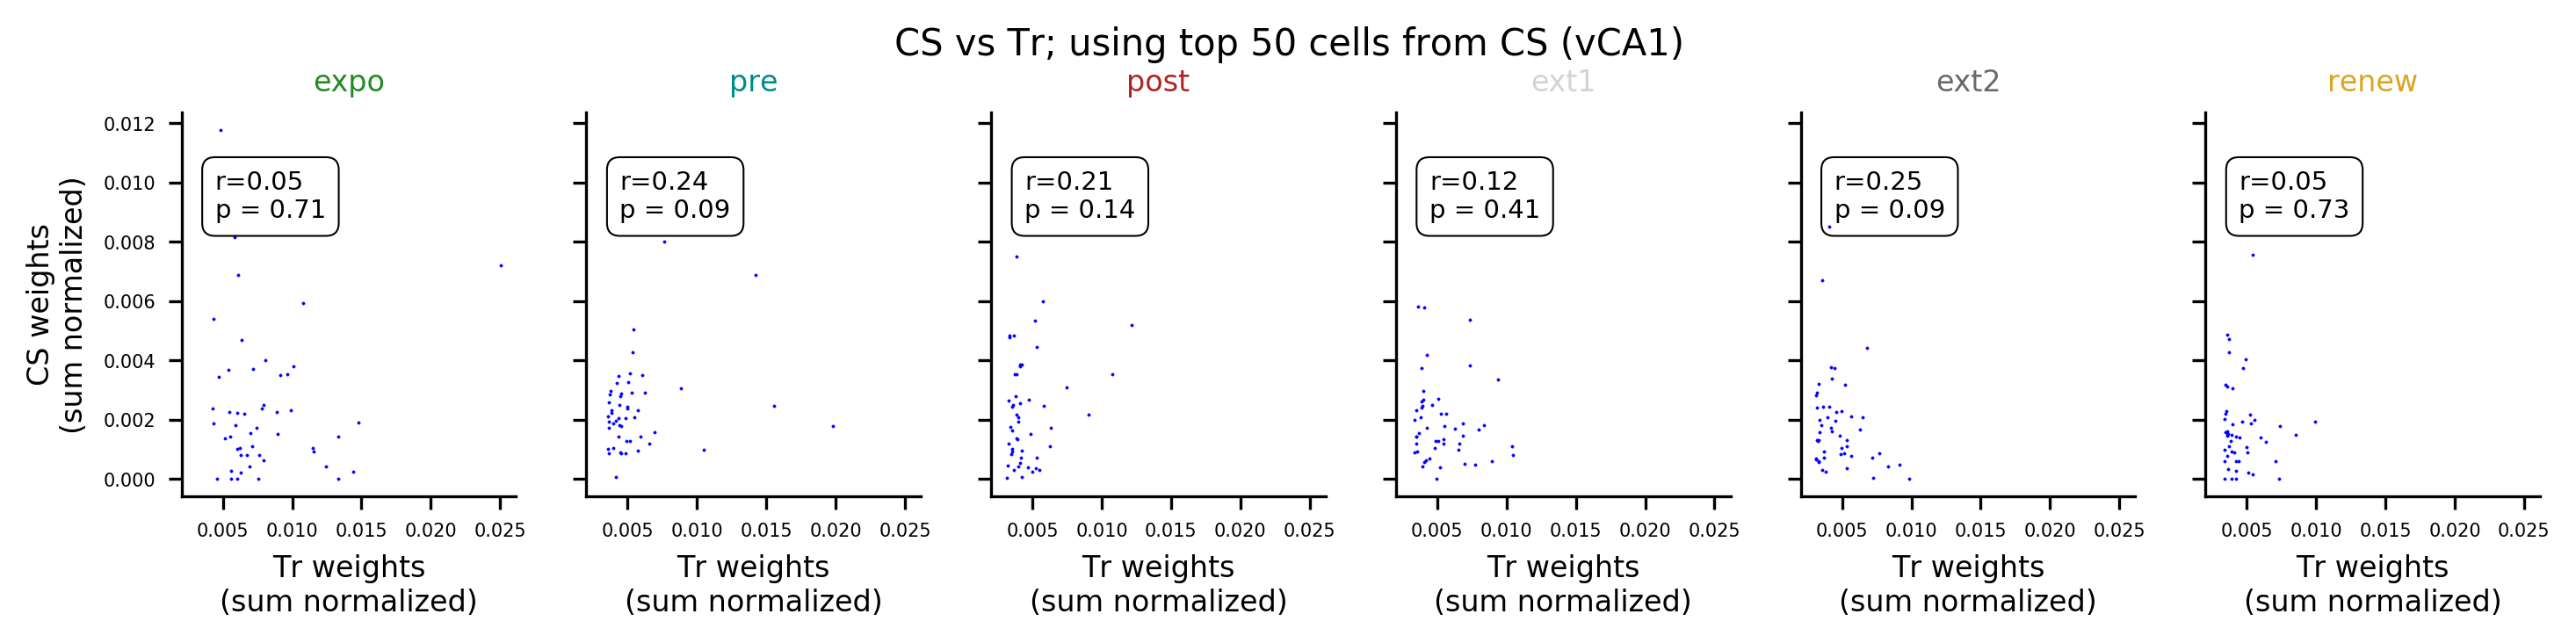

In [34]:
#scatter plot weights of the top n cells
fig, ax = pl.subplots(1,6, figsize=(10, 2.5),sharex=True,sharey=True)
i=-1
colors = ('forestgreen','darkcyan','firebrick','lightgrey','dimgrey','goldenrod')
for sess in sessions:
    i=i+1
    x = eval("[avg_sum_norm_abs_weights_tb_6[sess][r] for r in top%s_tb6[sess]]"%(no_cells))
    y = eval("[avg_sum_norm_abs_weights_tb_8[sess][r] for r in top%s_tb6[sess]]"%(no_cells))
    ax[i].plot(x,y,'bo',markersize=.8,mew=.1)
    #ax[i].set_xlim(-.08,.08)
    #ax[i].set_y[xlim(-.08,.08)
    #for tb,lc,d in zip(('8','10'),('r','b'),
    #                   ('3s','5s')):
    for tb,lc,d in zip(('8'),('k'),
                       ('Tr')):
        y = eval("[avg_sum_norm_abs_weights_tb_%s[sess][r] for r in top%s_tb6[sess]]"%(tb,no_cells))
        slope, intercept, r_value, p_value, std_err = sstats.linregress(x,y)
        line = slope*(np.unique(x))+intercept
        r2 = r_value*r_value
        if p_value < 0.05:
            lbl = '*'
        else:
            lbl = '\np = {:.2f}'.format(p_value)
        #ax[i].plot(np.unique(x), line, '%s'%lc, label='r$^2$={:.2f}\np={:.3f}'.format(r2,p_value))
    ax[i].set_title(sess,color=colors[i],fontsize=8)
    #ax[i].legend(loc='upper left',prop={'size': 7})
    ax[0].set_ylabel("CS weights\n(sum normalized)",fontsize=8)
    ax[i].set_xlabel("Tr weights\n(sum normalized)",fontsize=8)
    ax[i].text(0.1,0.85,('r={:.2f}'.format(abs(r_value))+lbl),transform=ax[i].transAxes,fontsize=7,verticalalignment='top',
                        bbox=dict(facecolor='none',edgecolor='black',boxstyle='round',linewidth=.5,pad=0.5))
pl.suptitle('CS vs Tr; using top '+str(no_cells)+' cells from CS (vCA1)',fontsize=10)

#pl.xlim(-.08,.08)
#pl.ylim(-.08,.08)
fig.tight_layout(pad=3)
pl.savefig("../img/%s_weights_vs_weights_bestCScells.pdf"%NOTEBOOK_NAME)

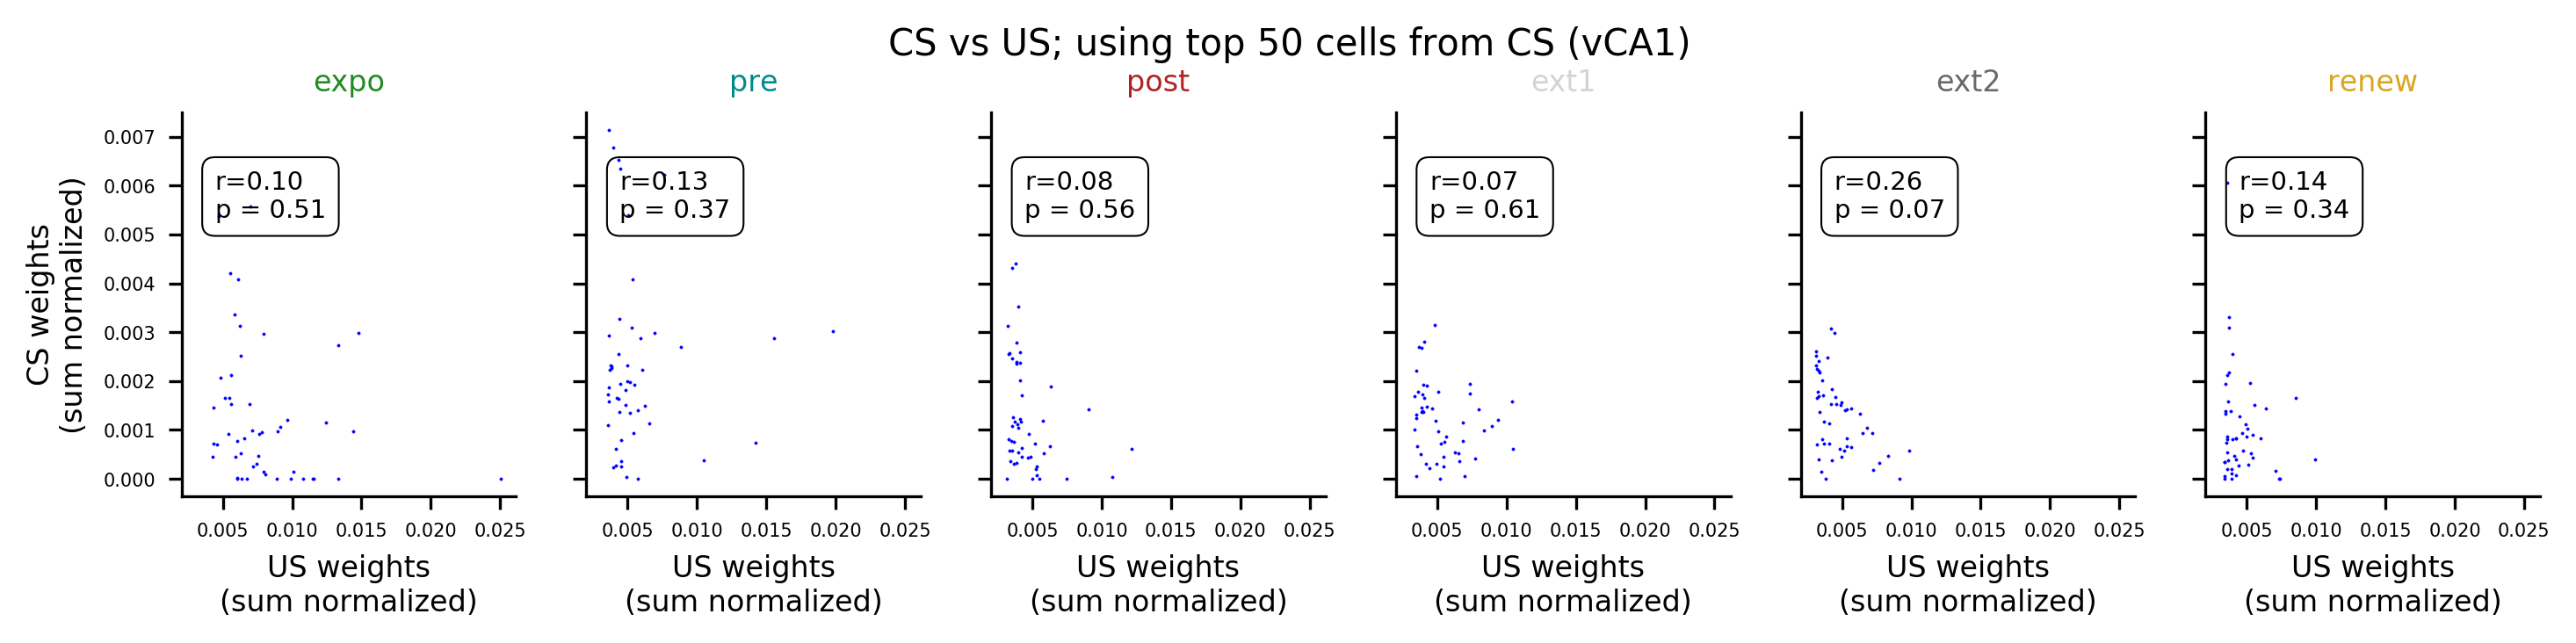

In [35]:
#scatter plot weights of the top n cells
fig, ax = pl.subplots(1,6, figsize=(10, 2.5),sharex=True,sharey=True)
i=-1

for sess in sessions:
    i=i+1
    x = eval("[avg_sum_norm_abs_weights_tb_6[sess][r] for r in top%s_tb6[sess]]"%(no_cells))
    y = eval("[avg_sum_norm_abs_weights_tb_10[sess][r] for r in top%s_tb6[sess]]"%(no_cells))
    ax[i].plot(x,y,'bo',markersize=.8,mew=.1)
    #ax[i].set_xlim(-.08,.08)
    #ax[i].set_y[xlim(-.08,.08)
    #for tb,lc,d in zip(('8','10'),('r','b'),
    #                   ('3s','5s')):
    for tb,lc,d in zip(('10'),('k'),
                       ('US')):
        y = eval("[avg_sum_norm_abs_weights_tb_%s[sess][r] for r in top%s_tb6[sess]]"%(tb,no_cells))
        slope, intercept, r_value, p_value, std_err = sstats.linregress(x,y)
        line = slope*(np.unique(x))+intercept
        r2 = r_value*r_value
        if p_value < 0.05:
            lbl = '*'
        else:
            lbl = '\np = {:.2f}'.format(p_value)
        #ax[i].plot(np.unique(x), line, '%s'%lc, label='r$^2$={:.2f}\np={:.3f}'.format(r2,p_value))
    ax[i].set_title(sess,color=colors[i],fontsize=8)
    #ax[i].legend(loc='upper left',prop={'size': 7})
    ax[0].set_ylabel("CS weights\n(sum normalized)",fontsize=8)
    ax[i].set_xlabel("US weights\n(sum normalized)",fontsize=8)
    ax[i].text(0.1,0.85,('r={:.2f}'.format(abs(r_value))+lbl),transform=ax[i].transAxes,fontsize=7,verticalalignment='top',
                        bbox=dict(facecolor='none',edgecolor='black',boxstyle='round',linewidth=.5,pad=0.5))
pl.suptitle('CS vs US; using top '+str(no_cells)+' cells from CS (vCA1)',fontsize=10)

#pl.xlim(-.08,.08)
#pl.ylim(-.08,.08)
fig.tight_layout(pad=3)
pl.savefig("../img/%s_weights_vs_weights_bestCScellsvsUS.pdf"%NOTEBOOK_NAME)

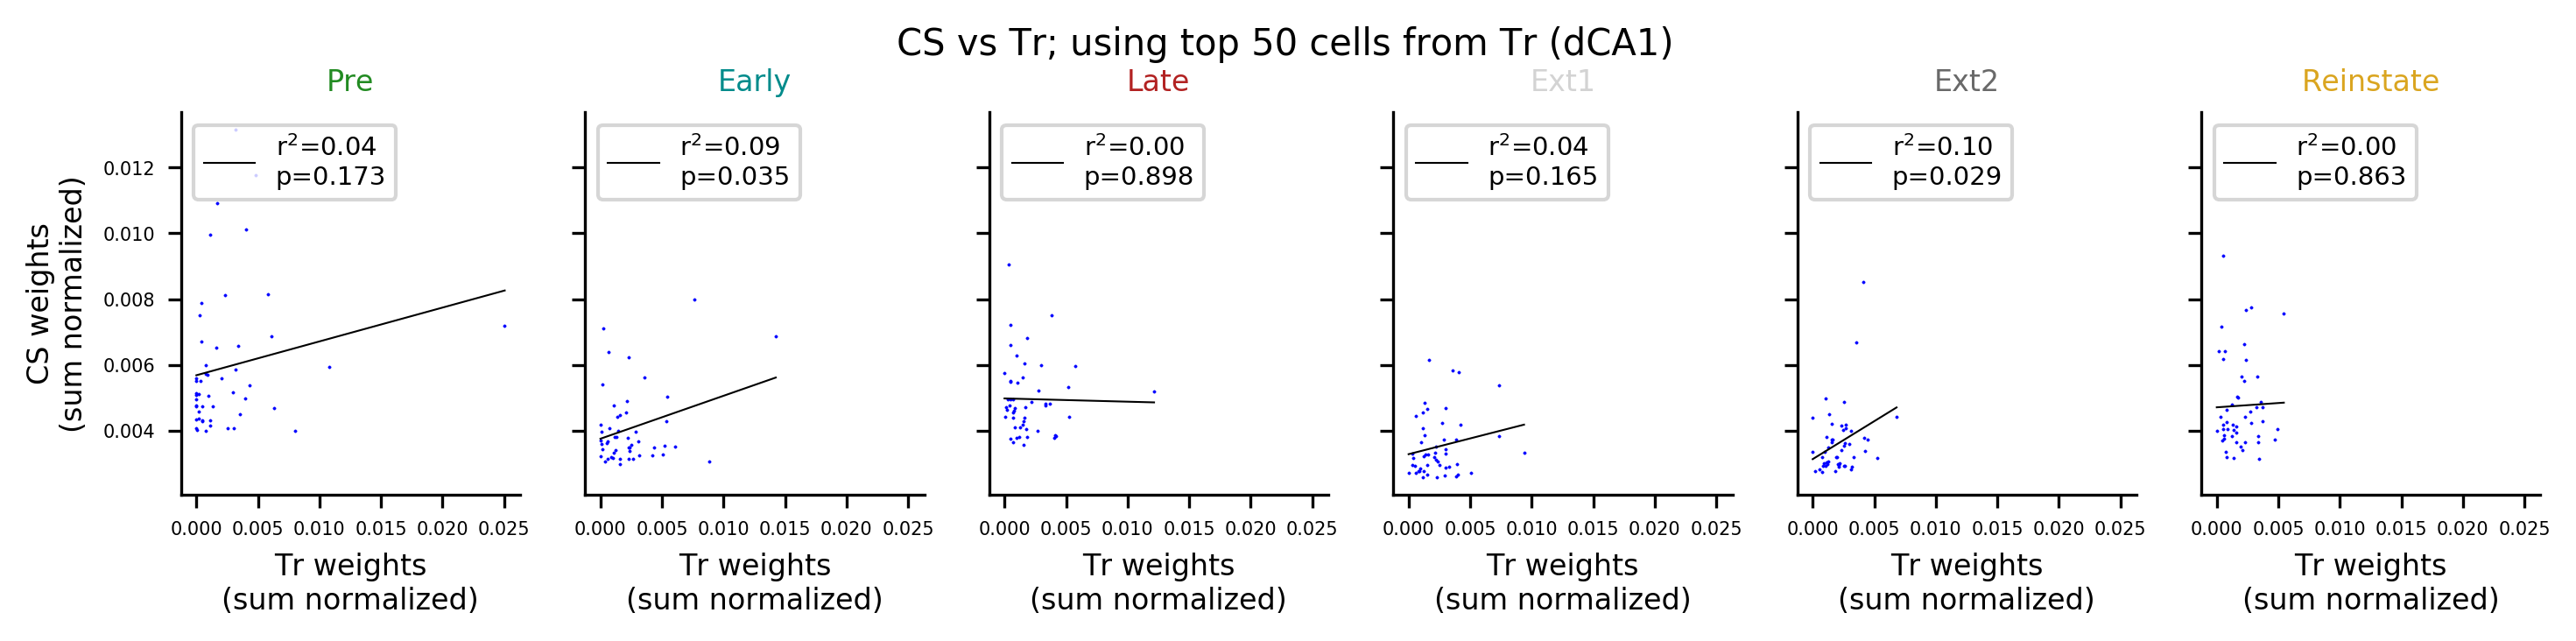

In [86]:
#scatter plot weights of the top n cells
fig, ax = pl.subplots(1,6, figsize=(10, 2.5),sharex=True,sharey=True)
i=-1

for sess,sess_la in zip(sessions,session_labels):
    i=i+1
    x = eval("[avg_sum_norm_abs_weights_tb_6[sess][r] for r in top%s_tb8[sess]]"%(no_cells))
    y = eval("[avg_sum_norm_abs_weights_tb_8[sess][r] for r in top%s_tb8[sess]]"%(no_cells))
    ax[i].plot(x,y,'bo',markersize=.8,mew=.1,scalex=False,scaley=False)
    #ax[i].set_xlim(-.08,.08)
    #ax[i].set_y[xlim(-.08,.08)
    #for tb,lc,d in zip(('8','10'),('r','b'),
    #                   ('3s','5s')):
    for tb,lc,d in zip(('8'),('k'),
                       ('Tr')):
        y = eval("[avg_sum_norm_abs_weights_tb_%s[sess][r] for r in top%s_tb8[sess]]"%(tb,no_cells))
        slope, intercept, r_value, p_value, std_err = sstats.linregress(x,y)
        line = slope*(np.unique(x))+intercept
        r2 = r_value*r_value
        ax[i].plot(np.unique(x), line, '%s'%lc, label='r$^2$={:.2f}\np={:.3f}'.format(r2,p_value))
    ax[i].set_title(sess_la,color=colors[i],fontsize=8)
    ax[i].legend(loc='upper left',prop={'size': 7})
    ax[0].set_ylabel("CS weights\n(sum normalized)",fontsize=8)
    ax[i].set_xlabel("Tr weights\n(sum normalized)",fontsize=8)
pl.suptitle('CS vs Tr; using top '+str(no_cells)+' cells from Tr (dCA1)',fontsize=10)

#pl.xlim(-.08,.08)
#pl.ylim(-.08,.08)
fig.tight_layout(pad=3)
pl.savefig("../img/%s_weights_vs_weights_bestTRcells.pdf"%NOTEBOOK_NAME)

In [37]:
#determine how many top cells are common to two time bins
for tb in range(len(reference_tbs)):
    for tb2 in range(len(reference_tbs)):
        exec("tb_%svs%s = {}"%(tb,tb2))
        for sess in sessions:
            exec("tb_%svs%s[sess]=0"%(tb,tb2))
            for x in eval("top%s_tb%s"%(no_cells,tb))[sess]:
                if x in eval("top%s_tb%s"%(no_cells,tb2))[sess]:
                    exec("tb_%svs%s[sess] = tb_%svs%s[sess] +1"%(tb,tb2,tb,tb2))
        #print 'tb_%svs%s[%s] = '%(tb,tb2,sess),

In [38]:
#now do the same for 3 time bins
for tb in range(len(reference_tbs)):
    for tb2 in range(len(reference_tbs)):
        for tb3 in range(len(reference_tbs)):
            exec("tb_%svs%svs%s = {}"%(tb,tb2,tb3))
            for sess in sessions:
                exec("tb_%svs%svs%s[sess]=0"%(tb,tb2,tb3))
                for x in eval("top%s_tb%s"%(no_cells,tb))[sess]:
                    if x in eval("top%s_tb%s"%(no_cells,tb2))[sess]:
                        if x in eval("top%s_tb%s"%(no_cells,tb3))[sess]:
                            exec("tb_%svs%svs%s[sess] = tb_%svs%svs%s[sess] +1"%(tb,tb2,tb3,tb,tb2,tb3))

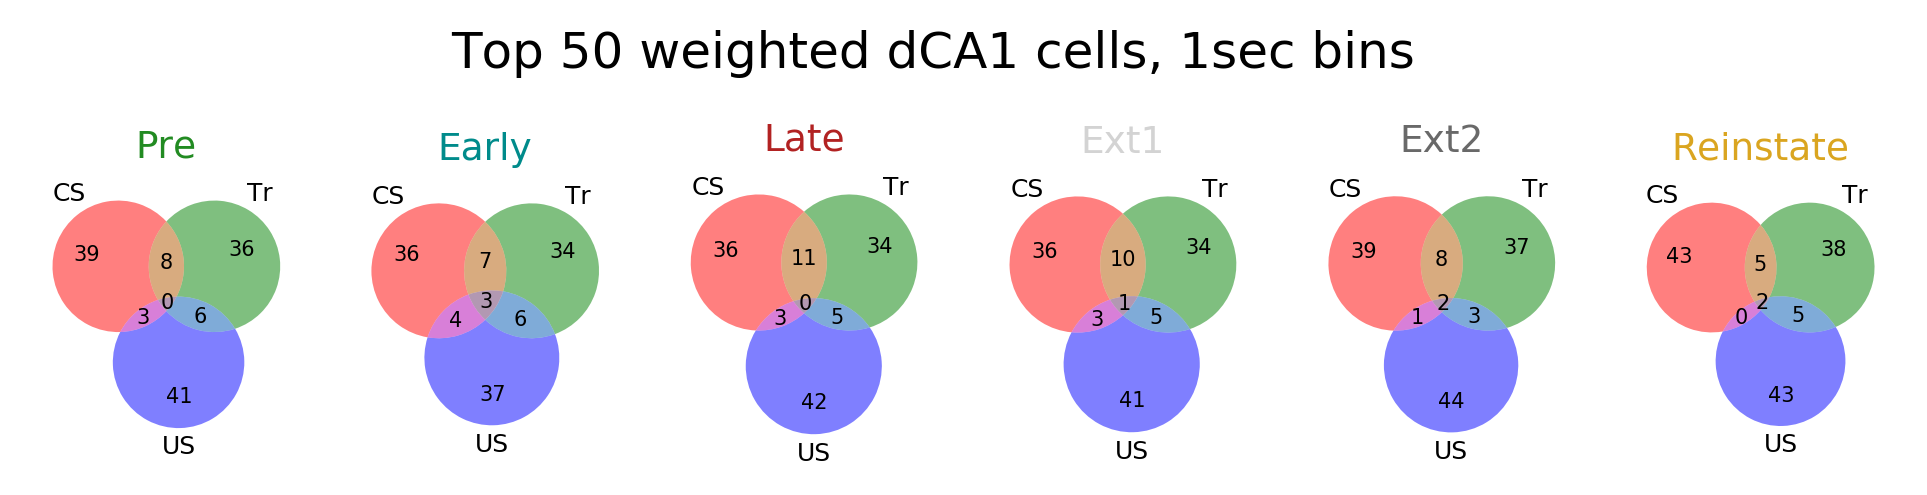

In [85]:
from matplotlib_venn import venn3, venn3_circles
#plot venn across 3 time bins
tbA = 6
tbB = 8
tbC = 10
fix,axs = pl.subplots(1,len(sessions),figsize=(8,4))
for sess,x,sess_la in zip(sessions,range(len(sessions)),session_labels):
    Abc = no_cells-eval("tb_%svs%s[sess]"%(tbA,tbB))-eval("tb_%svs%s[sess]"%(tbA,tbC))+eval("tb_%svs%svs%s[sess]"%(tbA,tbB,tbC))
    aBc = no_cells-eval("tb_%svs%s[sess]"%(tbA,tbB))-eval("tb_%svs%s[sess]"%(tbB,tbC))+eval("tb_%svs%svs%s[sess]"%(tbA,tbB,tbC))
    abC = no_cells-eval("tb_%svs%s[sess]"%(tbA,tbC))-eval("tb_%svs%s[sess]"%(tbB,tbC))+eval("tb_%svs%svs%s[sess]"%(tbA,tbB,tbC))
    ABc = eval("tb_%svs%s[sess]"%(tbA,tbB))-eval("tb_%svs%svs%s[sess]"%(tbA,tbB,tbC))
    aBC = eval("tb_%svs%s[sess]"%(tbB,tbC))-eval("tb_%svs%svs%s[sess]"%(tbA,tbB,tbC))
    ABC = eval("tb_%svs%svs%s[sess]"%(tbA,tbB,tbC))
    AbC=  eval("tb_%svs%s[sess]"%(tbA,tbC))-eval("tb_%svs%svs%s[sess]"%(tbA,tbB,tbC))
#print Abc,aBc,abC
    v=venn3(subsets = (Abc, aBc, ABc, abC, AbC, aBC, ABC), set_labels = ('CS', 'Tr', 'US'), alpha = 0.5,ax=axs[x])
    #v.get_patch_by_id('100').set_color('k')
    axs[x].set_title(sess_la,color=colors[x],fontsize=9)
pl.suptitle(('Top '+str(no_cells)+' weighted dCA1 cells, 1sec bins'),fontsize=12,y=.74)
pl.savefig("../final-ish figures/%s_3venn.pdf"%NOTEBOOK_NAME)

(array([ 399.,  283.,  126.,   81.,   37.,   29.,   14.,    9.,   10.,
           8.,   14.,    3.,    5.,    4.,    1.,    2.,    1.,    0.,
           0.,    1.]),
 array([ 0.        ,  0.00045224,  0.00090449,  0.00135673,  0.00180897,
         0.00226122,  0.00271346,  0.00316571,  0.00361795,  0.00407019,
         0.00452244,  0.00497468,  0.00542692,  0.00587917,  0.00633141,
         0.00678366,  0.0072359 ,  0.00768814,  0.00814039,  0.00859263,
         0.00904487]),
 <a list of 20 Patch objects>)

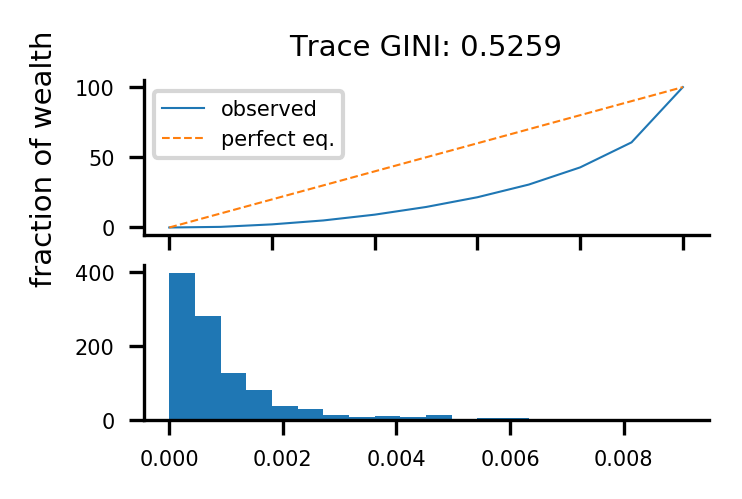

In [40]:
#find Gini coef and lorenz curve for reference_tbs
def Gini(v):
    bins = np.linspace(0., 100., 11)
    total = float(np.sum(v))
    yvals = []
    for b in bins:
        bin_vals = v[v <= np.percentile(v, b)]
        bin_fraction = (np.sum(bin_vals) / total) * 100.0
        yvals.append(bin_fraction)
    # perfect equality area
    pe_area = np.trapz(bins, x=bins)
    # lorenz area
    lorenz_area = np.trapz(yvals, x=bins)
    gini_val = (pe_area - lorenz_area) / float(pe_area)
    return bins, yvals, gini_val

v=np.array(avg_sum_norm_abs_weights_tb_8['post'])

bins, result, gini_val = Gini(v)
pl.figure()
pl.subplot(2, 1, 1)
pl.plot(bins, result, label="observed")
pl.plot(bins, bins, '--', label="perfect eq.")
pl.xlabel("fraction of population")
pl.ylabel("fraction of wealth")
pl.title("Trace GINI: %.4f" %(gini_val))
pl.legend()
pl.subplot(2, 1, 2)
pl.hist(v, bins=20)

In [41]:
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

gini_coef = {}
for sess in sessions:
    gini_coef[sess] = []
    for tb in reference_tbs:
        gini_coef[sess].append(gini(eval("avg_sum_norm_abs_weights_tb_%s[sess]"%tb)))

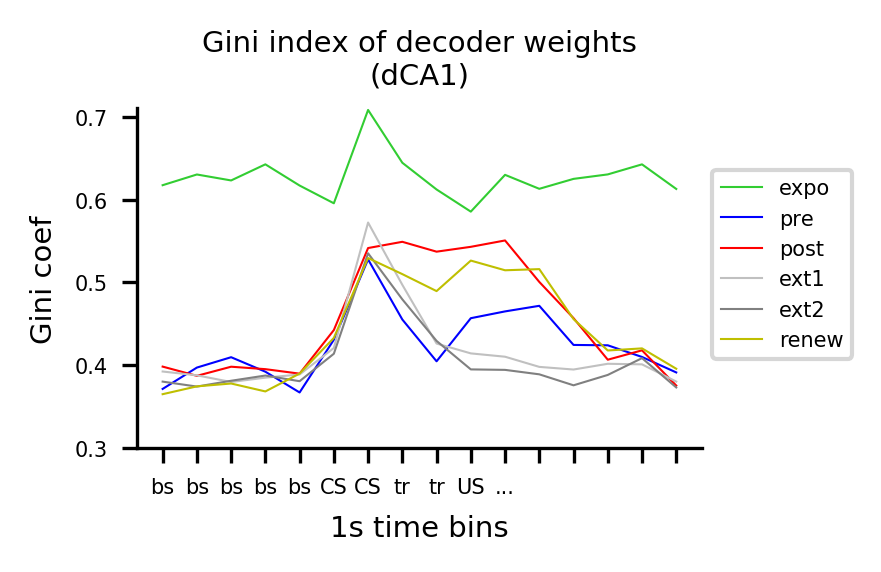

In [42]:
pl.plot(gini_coef['expo'],color='limegreen')
pl.plot(gini_coef['pre'],color='b')
pl.plot(gini_coef['post'],color='r')
pl.plot(gini_coef['ext1'],color='silver')
pl.plot(gini_coef['ext2'],color='grey')
pl.plot(gini_coef['renew'],color='y')
pl.ylabel('Gini coef')
pl.xlabel('1s time bins')
pl.xticks(range(16),['bs','bs','bs','bs','bs','CS','CS','tr','tr','US','...',])
pl.legend(['expo','pre','post','ext1','ext2','renew'],loc='best', bbox_to_anchor=(1, 0.85))
pl.title('Gini index of decoder weights\n(dCA1)')
pl.ylim(.3,.71)

pl.savefig("../img/%s_Gini.jpg"%NOTEBOOK_NAME)

In [75]:
#load selectivity p-vals
import math
for bins in '1s',:
    exec("stims_%s = ut.load_variable('stims_%s', 'autorestore/selectivity_time_bins_dhpc/')"%(bins, bins))
    for stim in eval("stims_%s"%bins):
        exec("combined_pvals_%s_%s = ut.load_variable('combined_pvals_%s_%s', 'autorestore/selectivity_time_bins_dhpc/')\
        "%(bins,stim,bins,stim))
        exec("combined_pvals_%s_%s_log10={}"%(bins,stim))
        exec("combined_pvals_%s_%s_corrected={}"%(bins,stim))
        exec("combined_pvals_%s_%s_log10_corrected={}"%(bins,stim))
        for sess in sessions:
            exec("combined_pvals_%s_%s_corrected[sess] = ut.adjust_pvalues(combined_pvals_%s_%s[sess])\
            "%(bins,stim,bins,stim))
    for stim in eval("stims_%s"%bins)[:-1]:
        for sess in sessions:
            exec("combined_pvals_%s_%s_log10[sess]=[]"%(bins,stim))
            exec("combined_pvals_%s_%s_log10_corrected[sess]=[]"%(bins,stim))
            for x in eval("combined_pvals_%s_%s[sess]"%(bins,stim)):
                exec("combined_pvals_%s_%s_log10[sess].append(math.log10(x))"%(bins,stim))
            for x in eval("combined_pvals_%s_%s_corrected[sess]"%(bins,stim)):
                exec("combined_pvals_%s_%s_log10_corrected[sess].append(math.log10(x))"%(bins,stim))

In [76]:
dark_co = ('forestgreen','darkcyan','firebrick','lightgrey','dimgrey','goldenrod')

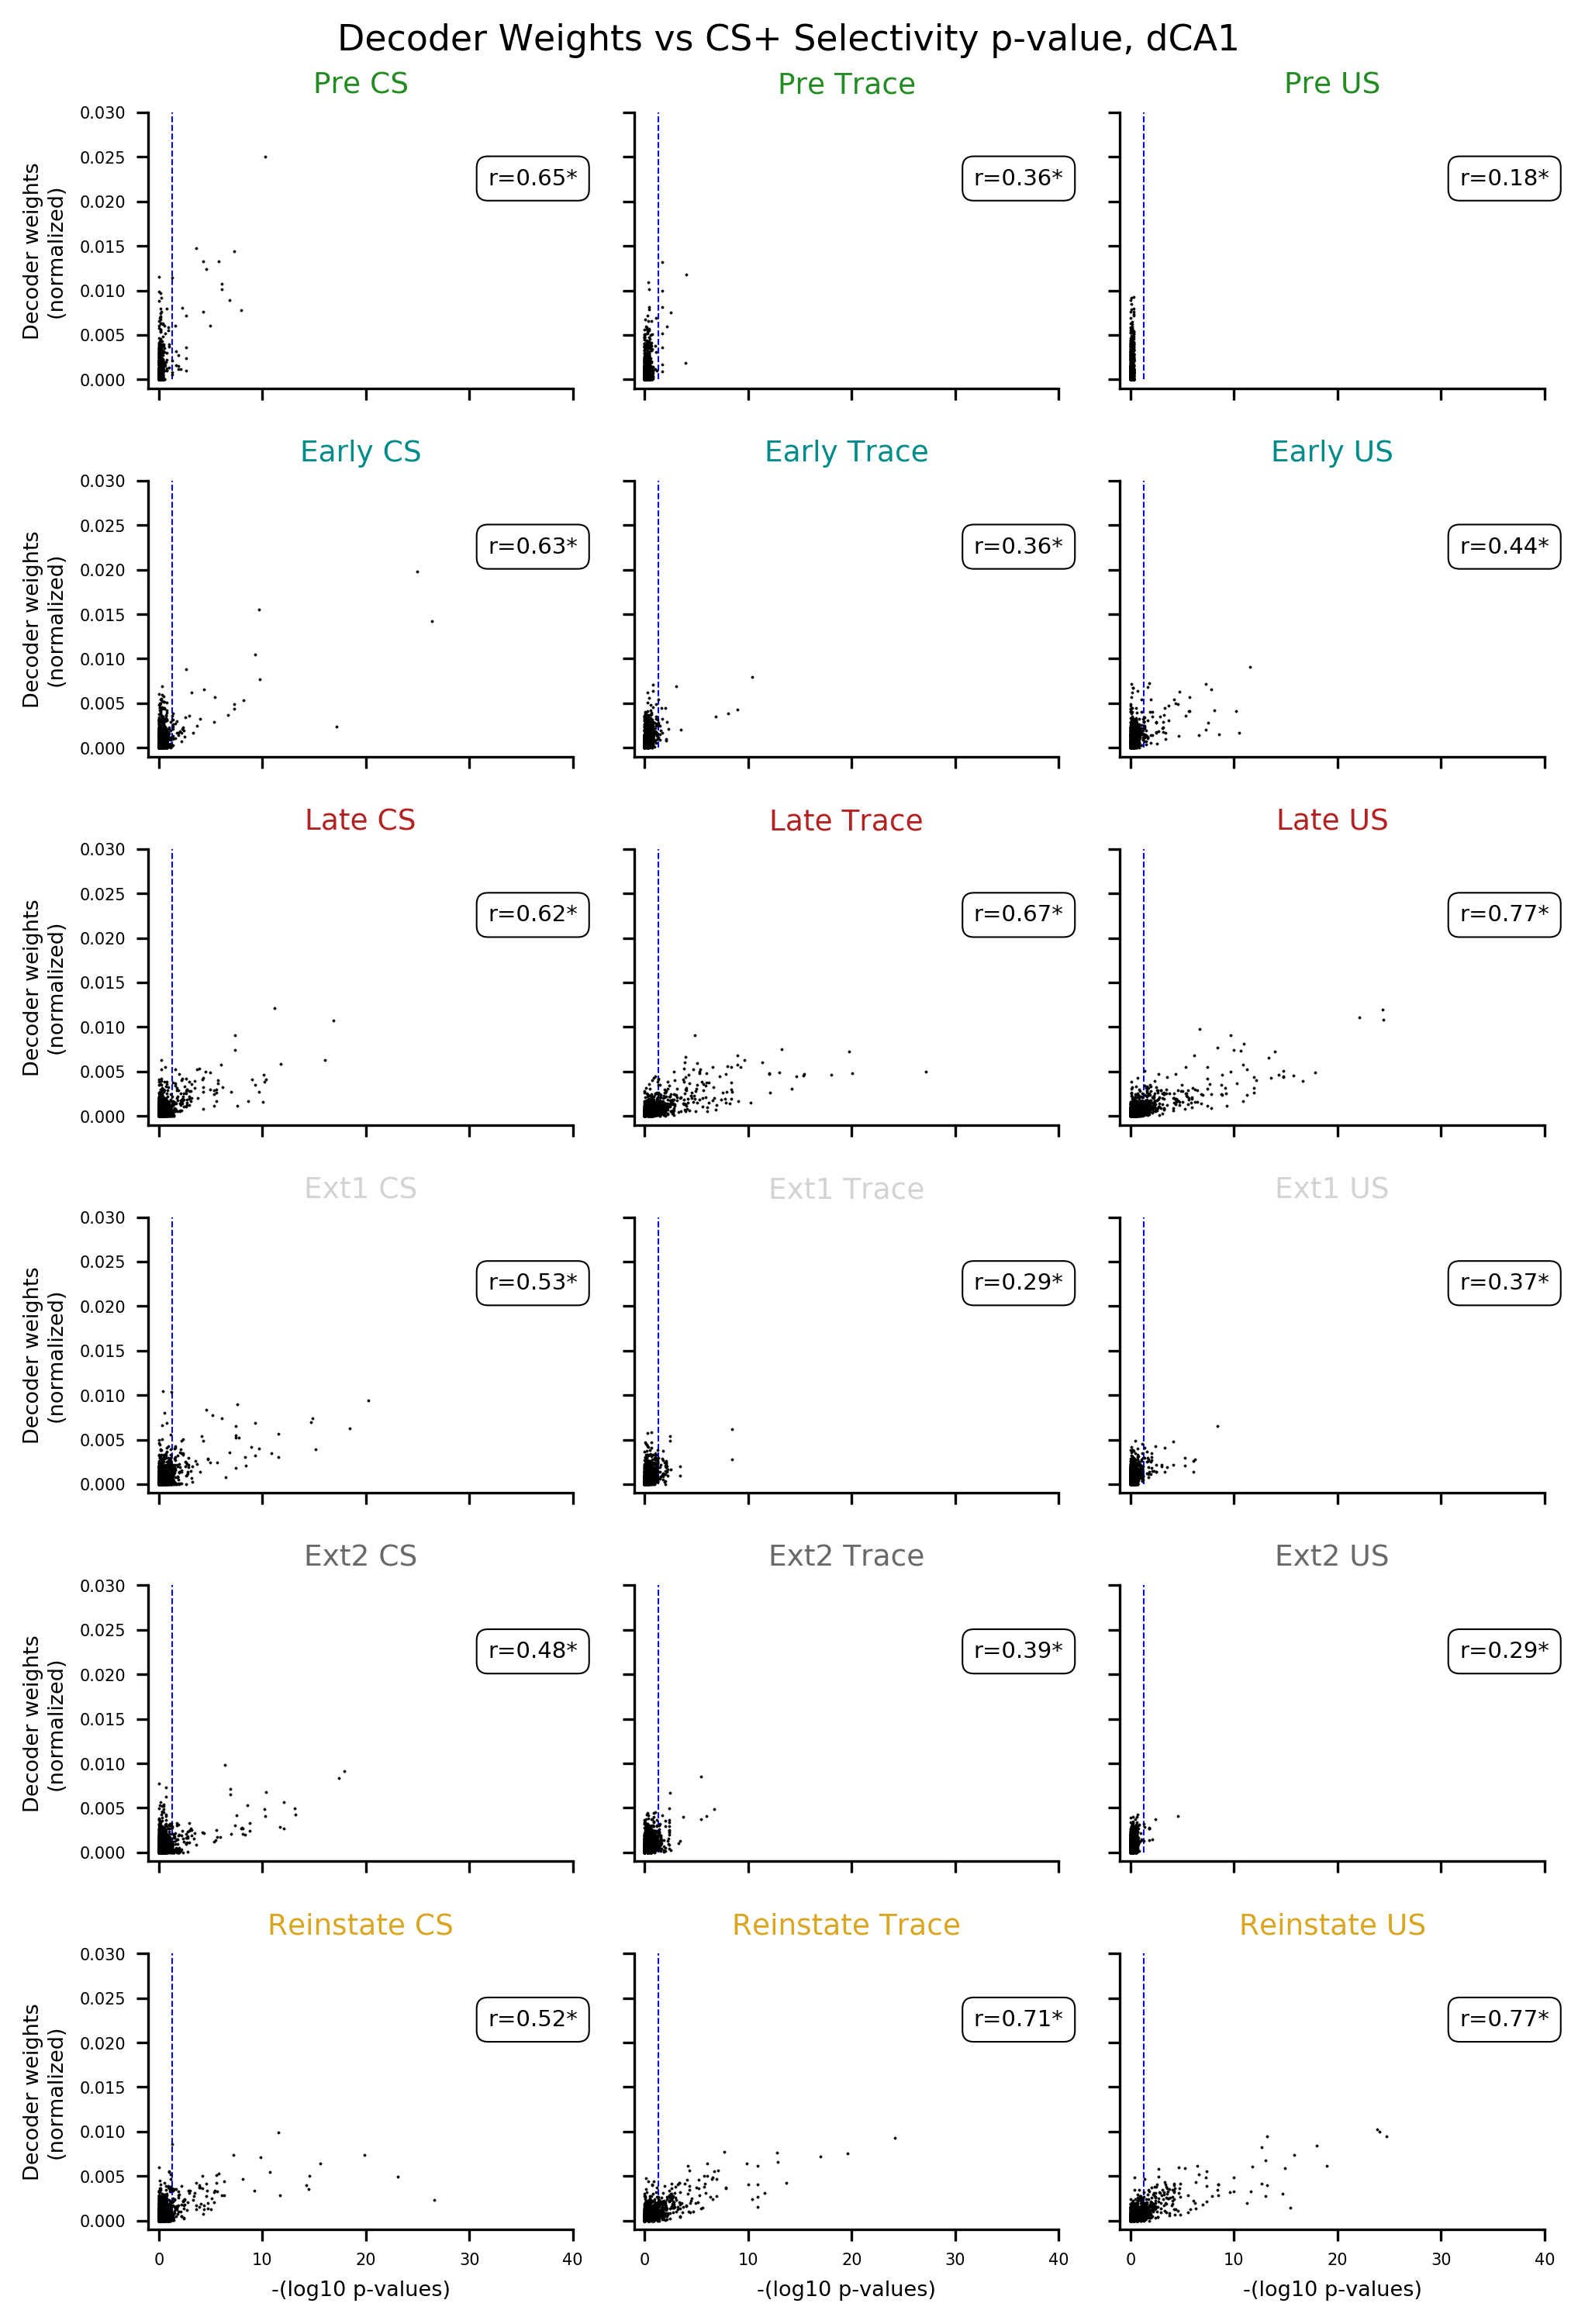

In [87]:
fig, ax = pl.subplots(6,3, figsize=(7, 10),sharex=True,sharey=True)
i=-1
colors = ('forestgreen','darkcyan','firebrick','lightgrey','dimgrey','goldenrod')
for sess,sessl in zip(sessions,('Pre','Early','Late','Ext1','Ext2','Reinstate')):
    i=i+1
    for t,tt,ttt,titl in zip((6,8,10),(1,3,5),range(3),('CS','Trace','US')):
        y = eval("avg_sum_norm_abs_weights_tb_%s[sess]"%t)
        x = eval("combined_pvals_1s_rewardt_%ss_log10_corrected[sess]"%tt)
    #ax[i].set_xlim(-.08,.08)
    #ax[i].set_ylim(-.08,.08)
    #for tb,lc,d in zip(('5','7','8','9','10','11','12'),('r','orange','g','cyan','b','purple','k'),
    #                   ('0','2','3','4','5','6','7')):
    #    y = eval("avg_sum_norm_abs_weights_tb_%s[sess]"%tb)
        slope, intercept, r_value, p_value, std_err = sstats.linregress(x,y)
        line = slope*(np.unique(x))+intercept
        r2 = r_value*r_value
        if p_value < 0.05:
            lbl = '*'
        else:
            lbl = '\np = {:.2f}'.format(p_value)
        ax[i][ttt].plot([-q for q in x],y,'ko',markersize=.8,mew=.1, label=('r = {:.2f}'.format(r_value))+lbl)
        #ax[i][ttt].plot(np.unique(x), line, colors[i], label=('r$^2$ = {:.2f}\n'.format(r2))+lbl)
        ax[i][ttt].set_title(sessl+' '+titl,fontsize=9,color=colors[i])
        #ax[i][ttt].legend(loc='best',prop={'size': 5.5})
        ax[len(sessions)-1][ttt].set_xlabel("-(log10 p-values)",fontsize=6.5)
        #ax[i][ttt].invert_xaxis()
        ax[i][ttt].set_xlim(-1,40)
        ax[i][ttt].set_ylim(-.001,.03)
        ax[i][ttt].vlines(1.3,0,1,linestyles='dashed',color='b')
        ax[i][0].set_ylabel("Decoder weights\n(normalized)",fontsize=6.5)
        ax[i][ttt].text(0.8,0.8,('r={:.2f}'.format(abs(r_value))+lbl),transform=ax[i][ttt].transAxes,fontsize=7,verticalalignment='top',
                        bbox=dict(facecolor='none',edgecolor='black',boxstyle='round',linewidth=.5,pad=0.5))
pl.suptitle('Decoder Weights vs CS+ Selectivity p-value, dCA1',fontsize=11, y=1)

#pl.xlim(-.08,.08)
#pl.ylim(-.08,.08)
fig.tight_layout(pad=3)
pl.savefig("../final-ish figures/%s_weights_vs_sel_pval.pdf"%NOTEBOOK_NAME)

### now activity vs weights

In [46]:
#patterns_tb... is dictionary of animal keys, so let's just make 1 inclusive list

In [47]:
#get average activity for each time bin
for t in range(16):
    for sess in sessions:
        exec("dict_avg_patterns_tb_%s_%s={}"%(t,sess))
        for ani in eval("%s_animals"%(sess)):
            exec("dict_avg_patterns_tb_%s_%s[ani] = [np.mean(k) for k in zip(*patterns_tb_%s_%s[ani])]"%(t,sess,t,sess))
            exec("dict_avg_patterns_tb_%s_%s = collections.OrderedDict(sorted(dict_avg_patterns_tb_%s_%s.items()))"%(t,sess,t,sess))

In [48]:
(dict_avg_patterns_tb_0_expo.keys())

['dhpc24', 'dhpc35', 'dhpc36', 'dhpcg1', 'dhpcg20']

In [49]:
#extract values from dictionary keys to make 1 inclusive list
for t in range(16):
    for sess in sessions:
        exec("avg_patterns_tb_%s_%s=[]"%(t,sess))
        for ani in eval("dict_avg_patterns_tb_%s_%s.keys()"%(t,sess)):
            for x in eval("dict_avg_patterns_tb_%s_%s[ani]"%(t,sess)):
                exec("avg_patterns_tb_%s_%s.append(x)"%(t,sess))

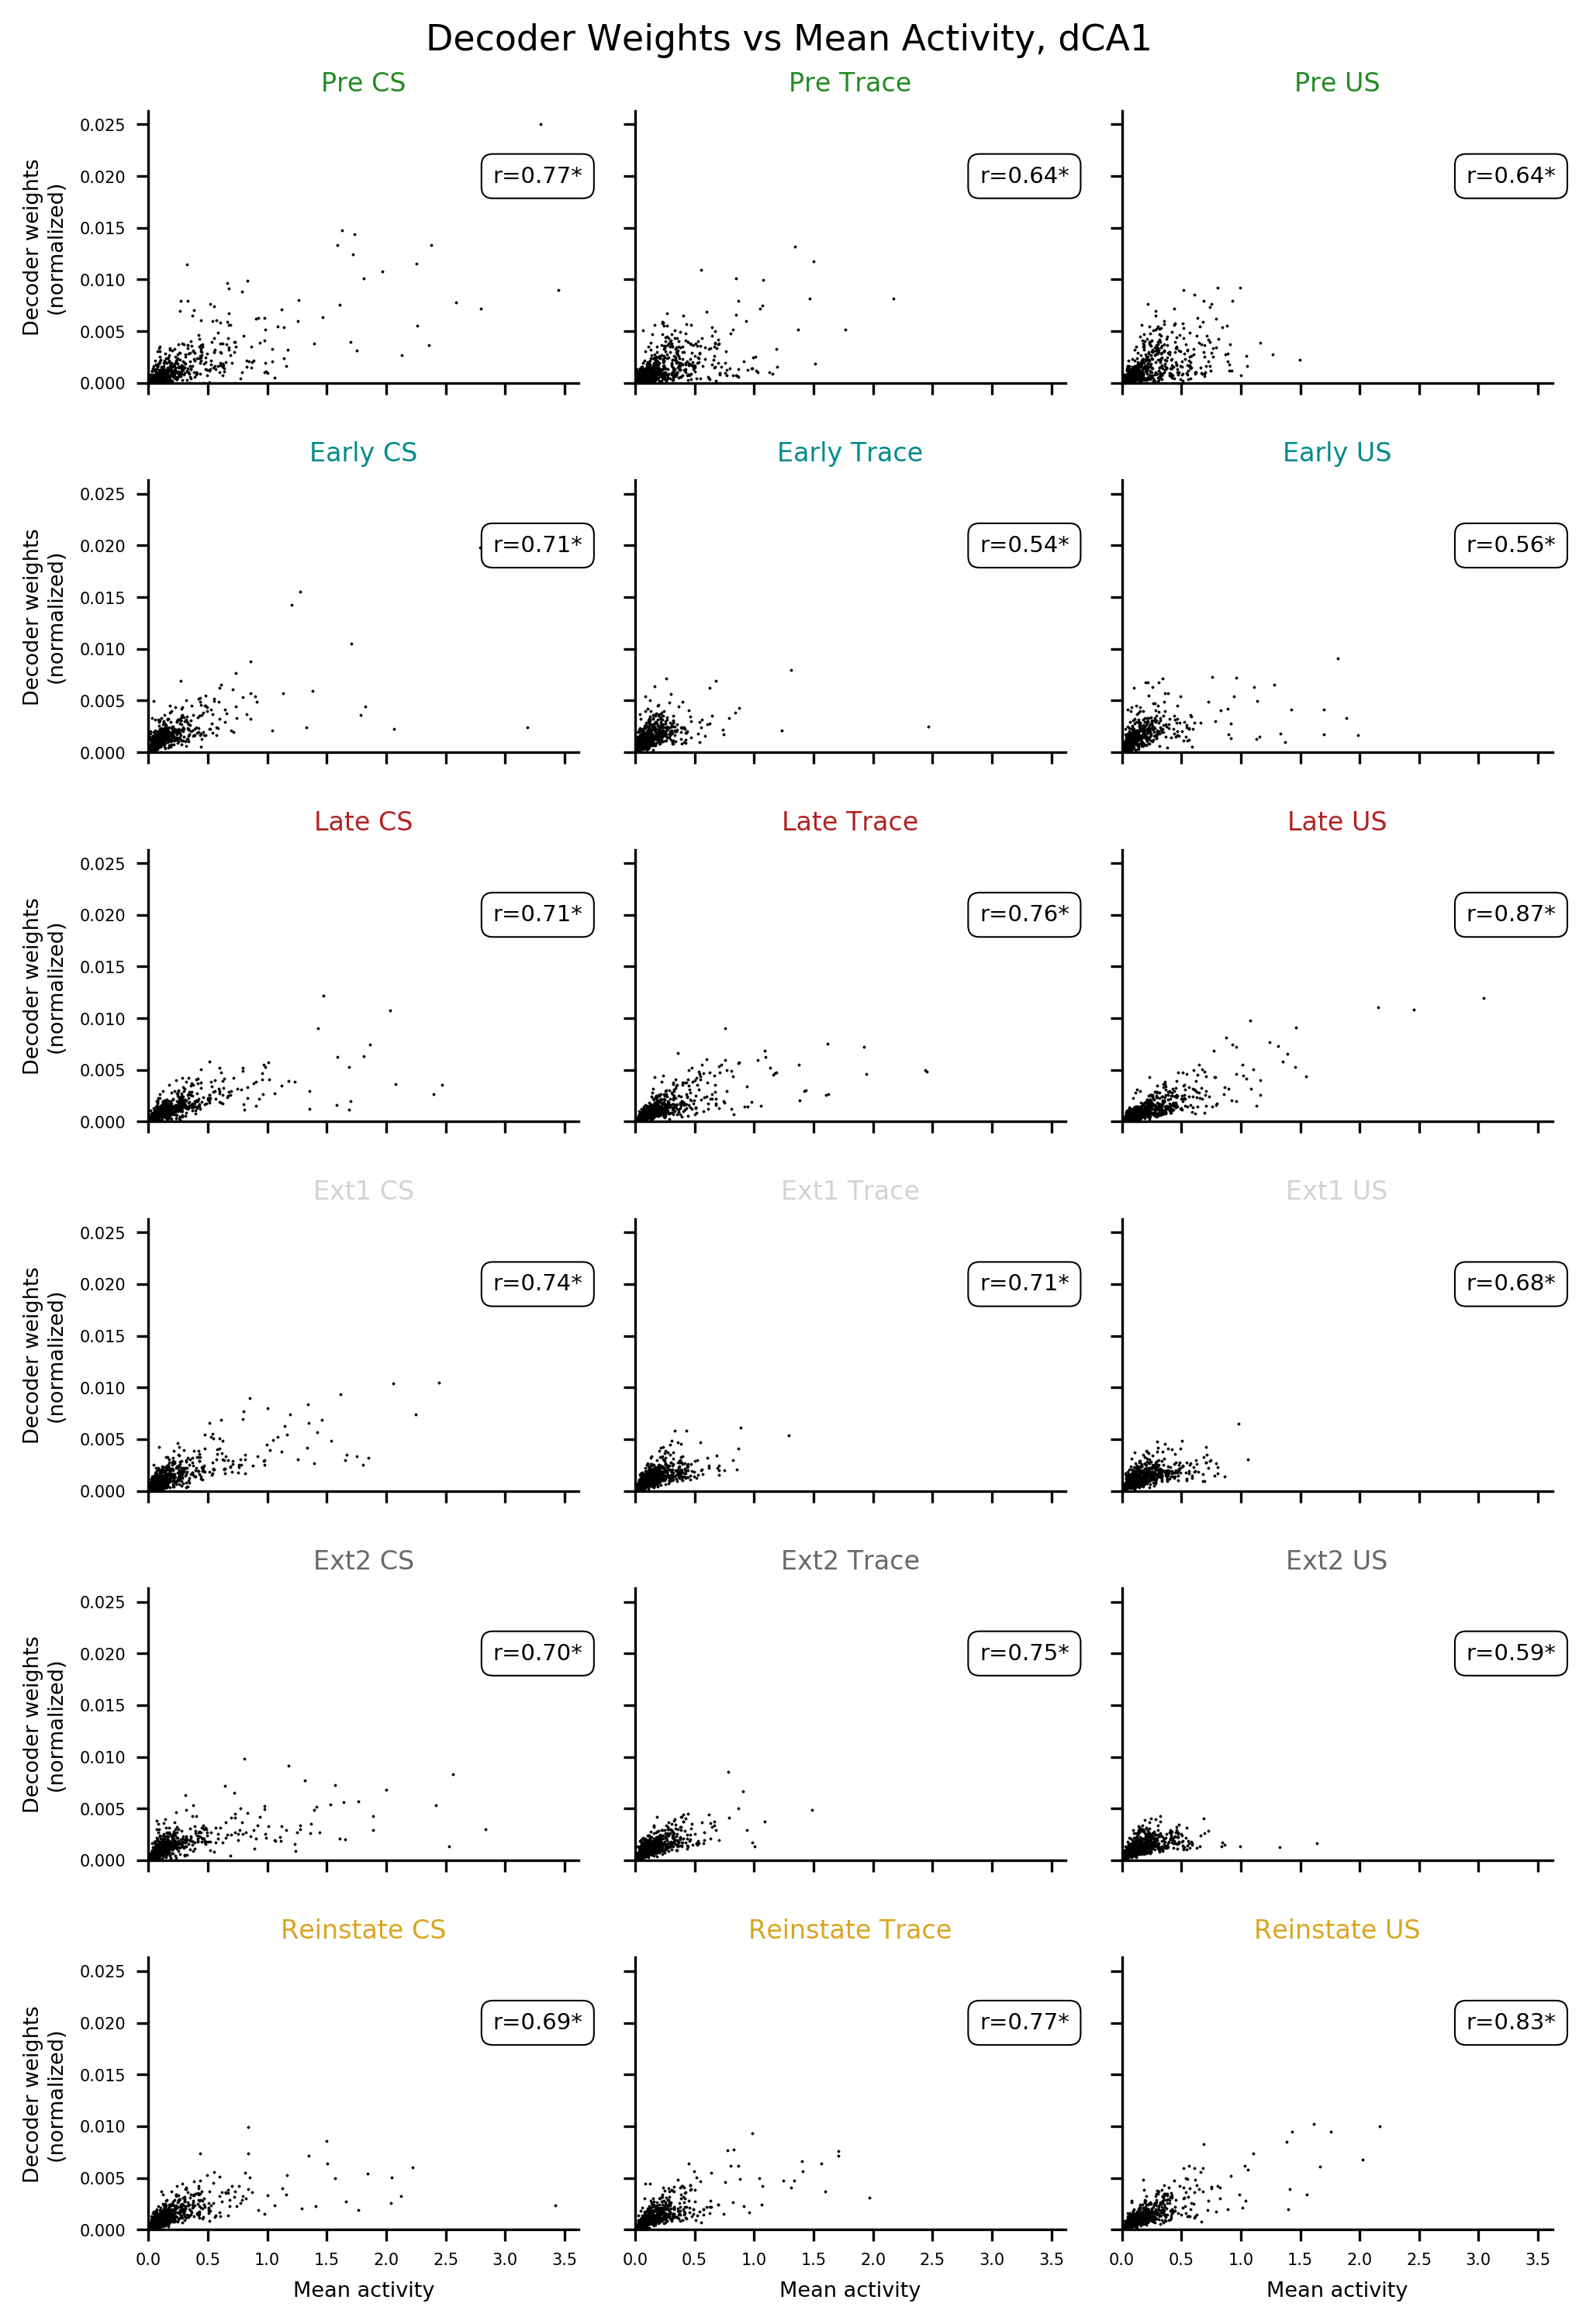

In [50]:
fig, ax = pl.subplots(6,3, figsize=(7, 10),sharex=True,sharey=True)
i=-1
colors = ('forestgreen','darkcyan','firebrick','lightgrey','dimgrey','goldenrod')
for sess,sessl in zip(sessions,('Pre','Early','Late','Ext1','Ext2','Reinstate')):
    i=i+1
    for t,tt,ttt,titl in zip((6,8,10),(1,3,5),range(0,3),('CS','Trace','US')):
        y = eval("avg_sum_norm_abs_weights_tb_%s[sess]"%t)
        x = eval("avg_patterns_tb_%s_%s"%(t,sess))
        ax[i][ttt].plot(x,y,'ko',markersize=.8,mew=.1)
    #ax[i].set_xlim(-.08,.08)
    #ax[i].set_ylim(-.08,.08)
    #for tb,lc,d in zip(('5','7','8','9','10','11','12'),('r','orange','g','cyan','b','purple','k'),
    #                   ('0','2','3','4','5','6','7')):
    #    y = eval("avg_sum_norm_abs_weights_tb_%s[sess]"%tb)
        slope, intercept, r_value, p_value, std_err = sstats.linregress(x,y)
        line = slope*(np.unique(x))+intercept
        r2 = r_value*r_value
        if p_value < 0.05:
            lbl = '*'
        else:
            lbl = '\np = {:.2f}'.format(p_value)
        #ax[i][ttt].plot(np.unique(x), line, colors[i], label=('r$^2$ = {:.2f}\n'.format(r2))+lbl)
        ax[i][ttt].set_title(sessl+' '+titl,color=colors[i],fontsize=8)
        #ax[i][ttt].legend(loc='best',prop={'size': 5.5})
        ax[len(sessions)-1][ttt].set_xlabel("Mean activity",fontsize=6.5)
        #ax[i][ttt].invert_xaxis()
        ax[i][ttt].set_xlim(0)
        ax[i][ttt].set_ylim(0)
        #ax[i][ttt].vlines(-1.3,0,1,linestyles='dashed',color='b')
        ax[i][0].set_ylabel("Decoder weights\n(normalized)",fontsize=6.5)
        ax[i][ttt].text(0.8,0.8,('r={:.2f}'.format(abs(r_value))+lbl),transform=ax[i][ttt].transAxes,fontsize=7,verticalalignment='top',
                        bbox=dict(facecolor='none',edgecolor='black',boxstyle='round',linewidth=.5,pad=0.5))
pl.suptitle('Decoder Weights vs Mean Activity, dCA1',fontsize=11, y=1)

#pl.xlim(-.08,.08)
#pl.ylim(-.08,.08)
fig.tight_layout(pad=3)
pl.savefig("../img/%s_weights_vs_tb_activity.pdf"%NOTEBOOK_NAME)

In [51]:
#now look at total activity across the entire session:
for sess,sess2 in zip(('expo','pre', 'post', 'ext1', 'ext2', 'renew'),('2_odor_expo','pre', 'post', 'ext1', 'ext2', 'renew')):

    exec("events_%s = dict(zip(%s_animals, [ut.load_variable('events',\
                                                           '../%%s/%s/notebooks/autorestore/preprocessing/'%%ani)\
                                                  for ani in %s_animals]))"%(sess, sess, sess2, sess))

In [52]:
#get average activity
for t in range(16):
    for sess in sessions:
        exec("dict_avg_events_%s={}"%(sess))
        for ani in eval("%s_animals"%(sess)):
            exec("dict_avg_events_%s[ani] = [np.mean(k) for k in zip(*events_%s[ani])]"%(sess,sess))
            exec("dict_avg_events_%s = collections.OrderedDict(sorted(dict_avg_events_%s.items()))"%(sess,sess))

In [53]:
#extract values from dictionary keys to make 1 inclusive list
for t in range(16):
    for sess in sessions:
        exec("avg_events_%s=[]"%(sess))
        for ani in eval("dict_avg_events_%s.keys()"%(sess)):
            for x in eval("dict_avg_events_%s[ani]"%(sess)):
                exec("avg_events_%s.append(x)"%(sess))

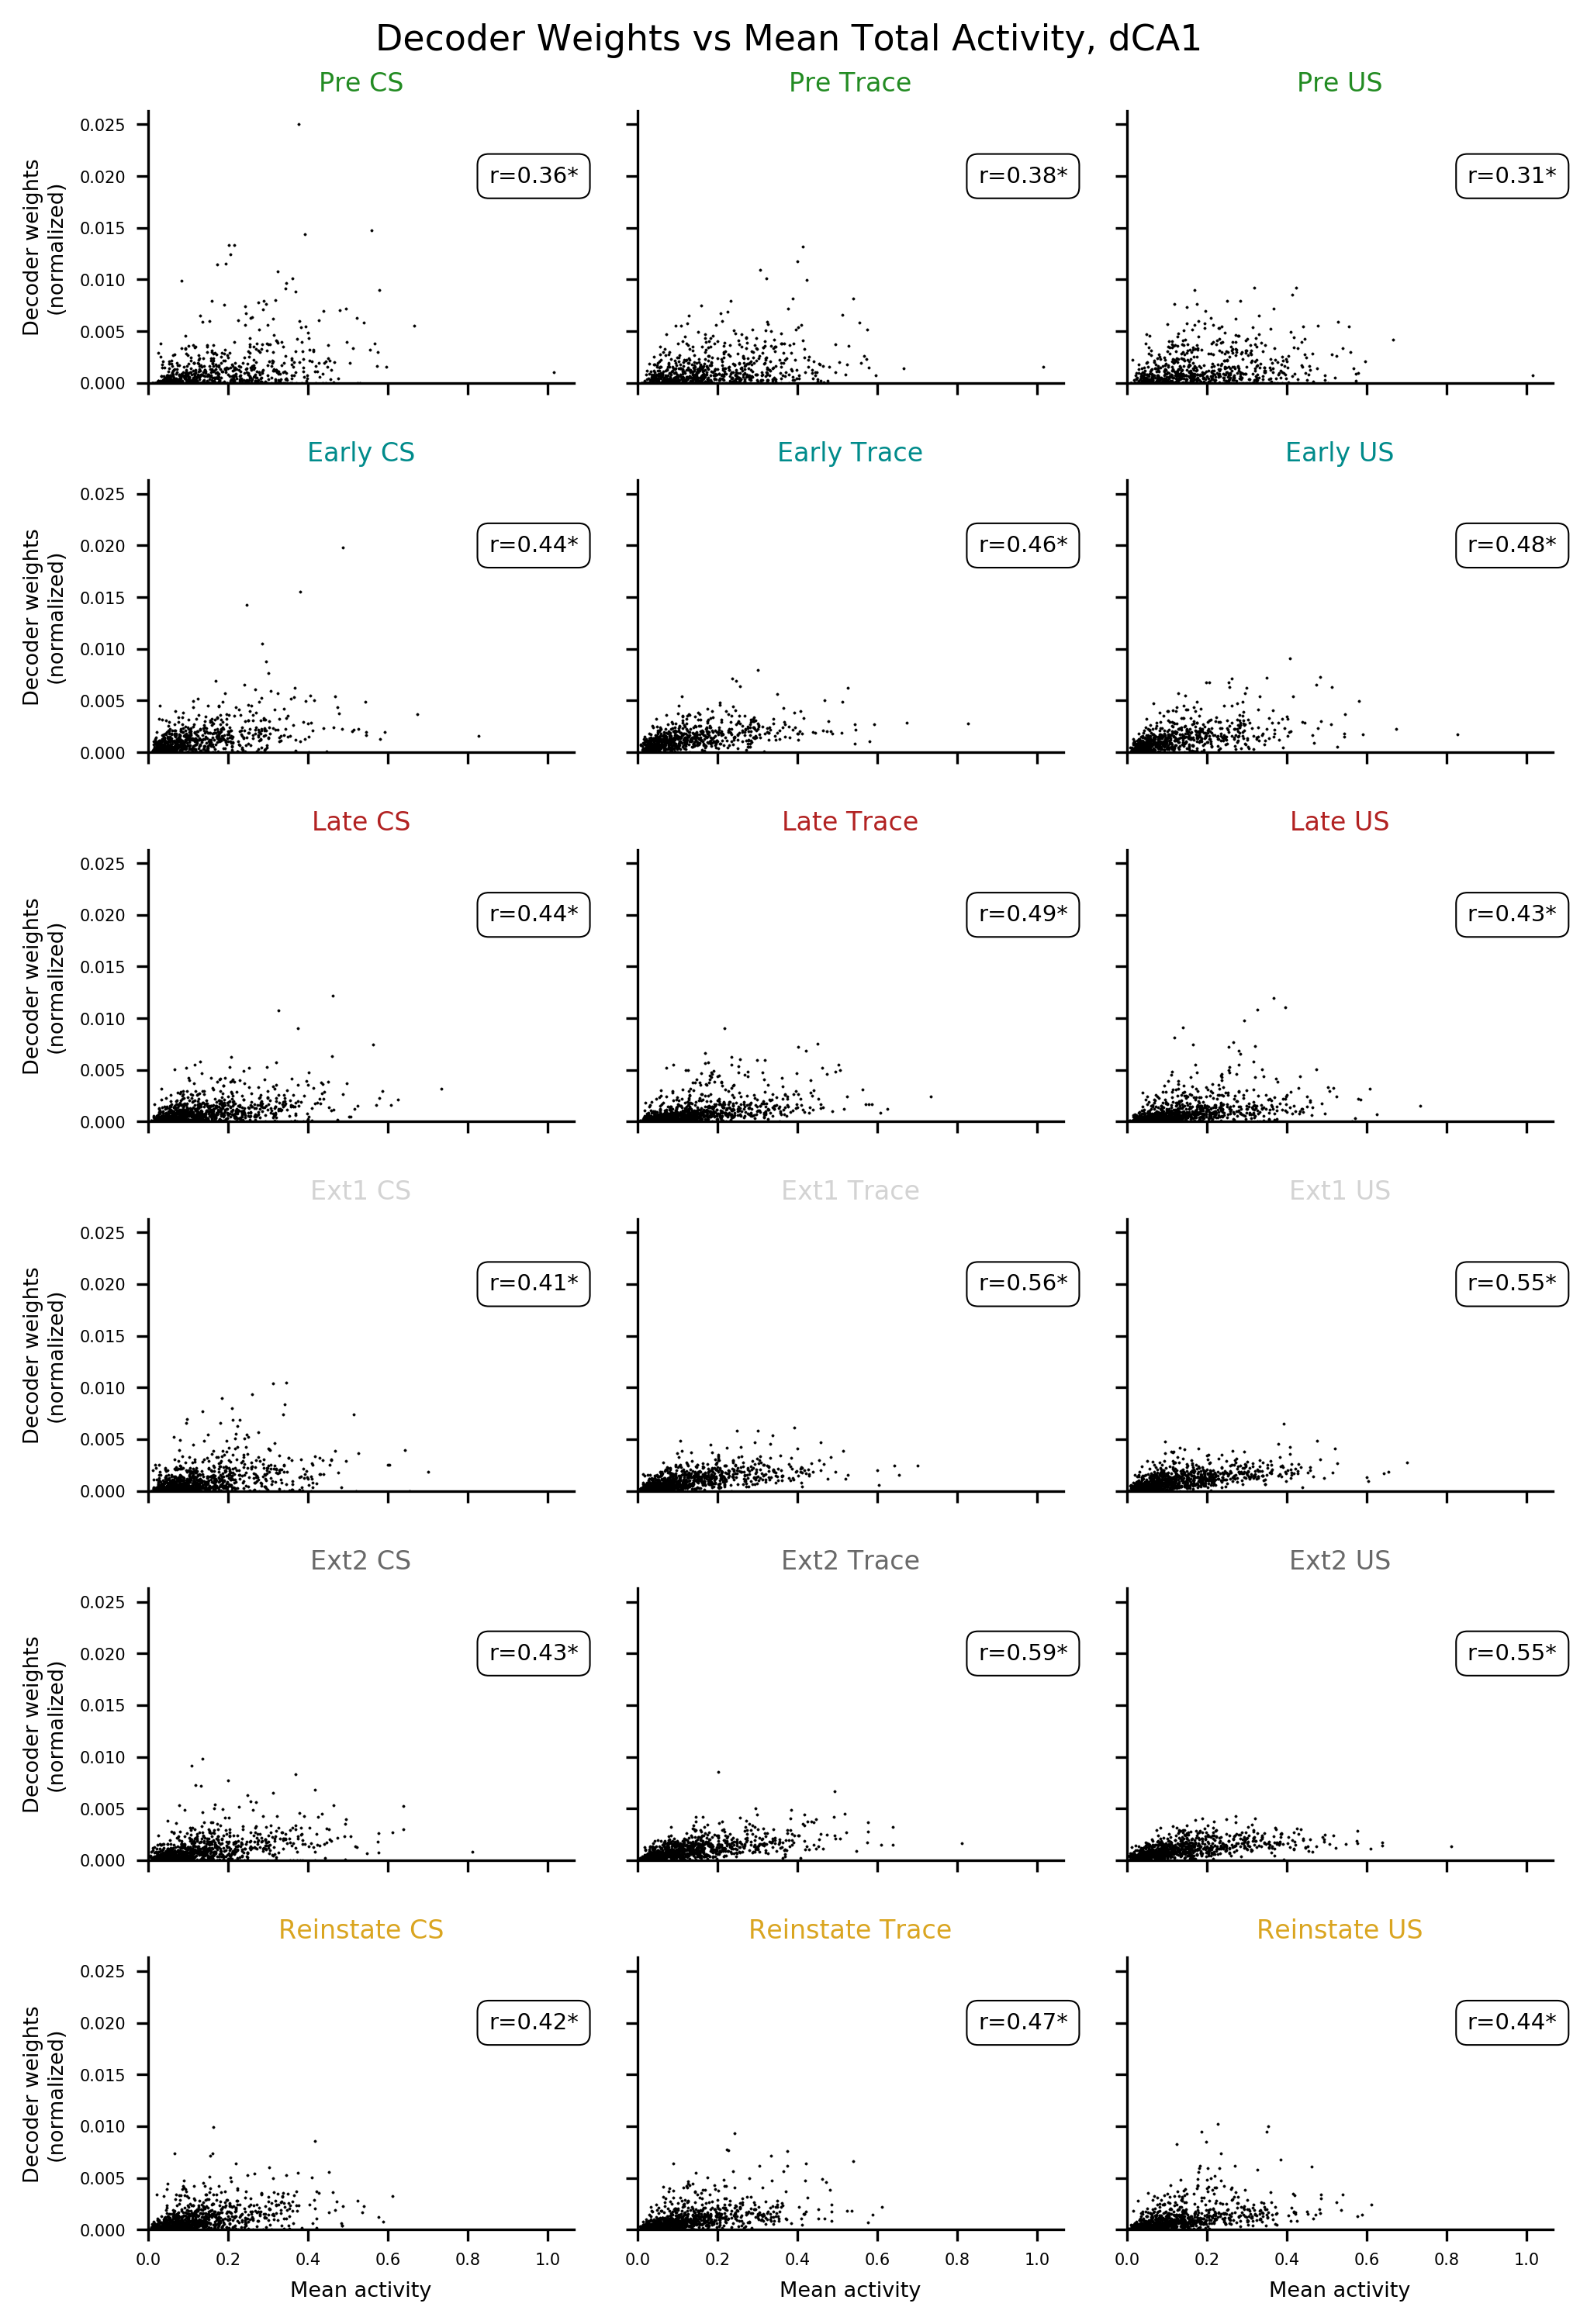

In [54]:
fig, ax = pl.subplots(6,3, figsize=(7, 10),sharex=True,sharey=True)
i=-1
colors = ('forestgreen','darkcyan','firebrick','lightgrey','dimgrey','goldenrod')
for sess,sessl in zip(sessions,('Pre','Early','Late','Ext1','Ext2','Reinstate')):
    i=i+1
    for t,tt,ttt,titl in zip((6,8,10),(1,3,5),range(0,3),('CS','Trace','US')):
        y = eval("avg_sum_norm_abs_weights_tb_%s[sess]"%t)
        x = eval("avg_events_%s"%(sess))
        ax[i][ttt].plot(x,y,'ko',markersize=.8,mew=.1)
    #ax[i].set_xlim(-.08,.08)
    #ax[i].set_ylim(-.08,.08)
    #for tb,lc,d in zip(('5','7','8','9','10','11','12'),('r','orange','g','cyan','b','purple','k'),
    #                   ('0','2','3','4','5','6','7')):
    #    y = eval("avg_sum_norm_abs_weights_tb_%s[sess]"%tb)
        slope, intercept, r_value, p_value, std_err = sstats.linregress(x,y)
        line = slope*(np.unique(x))+intercept
        r2 = r_value*r_value
        if p_value < 0.05:
            lbl = '*'
        else:
            lbl = '\np = {:.2f}'.format(p_value)
        #ax[i][ttt].plot(np.unique(x), line, colors[i], label=('r$^2$ = {:.2f}\n'.format(r2))+lbl)
        ax[i][ttt].set_title(sessl+' '+titl,color=colors[i],fontsize=8)
        #ax[i][ttt].legend(loc='best',prop={'size': 5.5})
        ax[len(sessions)-1][ttt].set_xlabel("Mean activity",fontsize=6.5)
        #ax[i][ttt].invert_xaxis()
        ax[i][ttt].set_xlim(0)
        ax[i][ttt].set_ylim(0)
        #ax[i][ttt].vlines(-1.3,0,1,linestyles='dashed',color='b')
        ax[i][0].set_ylabel("Decoder weights\n(normalized)",fontsize=6.5)
        ax[i][ttt].text(0.8,0.8,('r={:.2f}'.format(abs(r_value))+lbl),transform=ax[i][ttt].transAxes,fontsize=7,verticalalignment='top',
                        bbox=dict(facecolor='none',edgecolor='black',boxstyle='round',linewidth=.5,pad=0.5))
pl.suptitle('Decoder Weights vs Mean Total Activity, dCA1',fontsize=11, y=1)

#pl.xlim(-.08,.08)
#pl.ylim(-.08,.08)
fig.tight_layout(pad=3)
pl.savefig("../img/%s_weights_vs_total_activity.pdf"%NOTEBOOK_NAME)

### now try plotting when taking log10 values (to expand the cluster around the origin)

In [55]:
for tb in range(16):
    exec("avg_sum_norm_abs_weights_tb_%s_log10 = {}"%tb)
    exec("avg_sum_norm_abs_weights_tb_%s_log10_no0 = {}"%tb) #will exclude all 0 weighted cells (and also need to do same for activity data)
    
for sess in sessions:
    for t in range(16):
        exec("avg_sum_norm_abs_weights_tb_%s_log10[sess] = []"%t)
        exec("avg_sum_norm_abs_weights_tb_%s_log10_no0[sess] = []"%t)
        exec("avg_events_%s_log10 = []"%(sess))
        exec("avg_events_tb_%s_%s_log10_no0 = []"%(t,sess))
        for x,y in zip(eval("avg_sum_norm_abs_weights_tb_%s[sess]"%t),eval("avg_events_%s"%(sess))):
            if x == 0:
                exec("avg_sum_norm_abs_weights_tb_%s_log10[sess].append(-4)"%t)
            else:
                exec("avg_sum_norm_abs_weights_tb_%s_log10[sess].append(math.log10(x))"%t)
                exec("avg_sum_norm_abs_weights_tb_%s_log10_no0[sess].append(math.log10(x))"%t)
                exec("avg_events_tb_%s_%s_log10_no0.append(math.log10(y))"%(t,sess))         
        for x in eval("avg_events_%s"%(sess)):
            #if x == 0:
            #    exec("avg_events_%s_log10.append(-4)"%(sess))
            #else:
                exec("avg_events_%s_log10.append(math.log10(x))"%(sess))

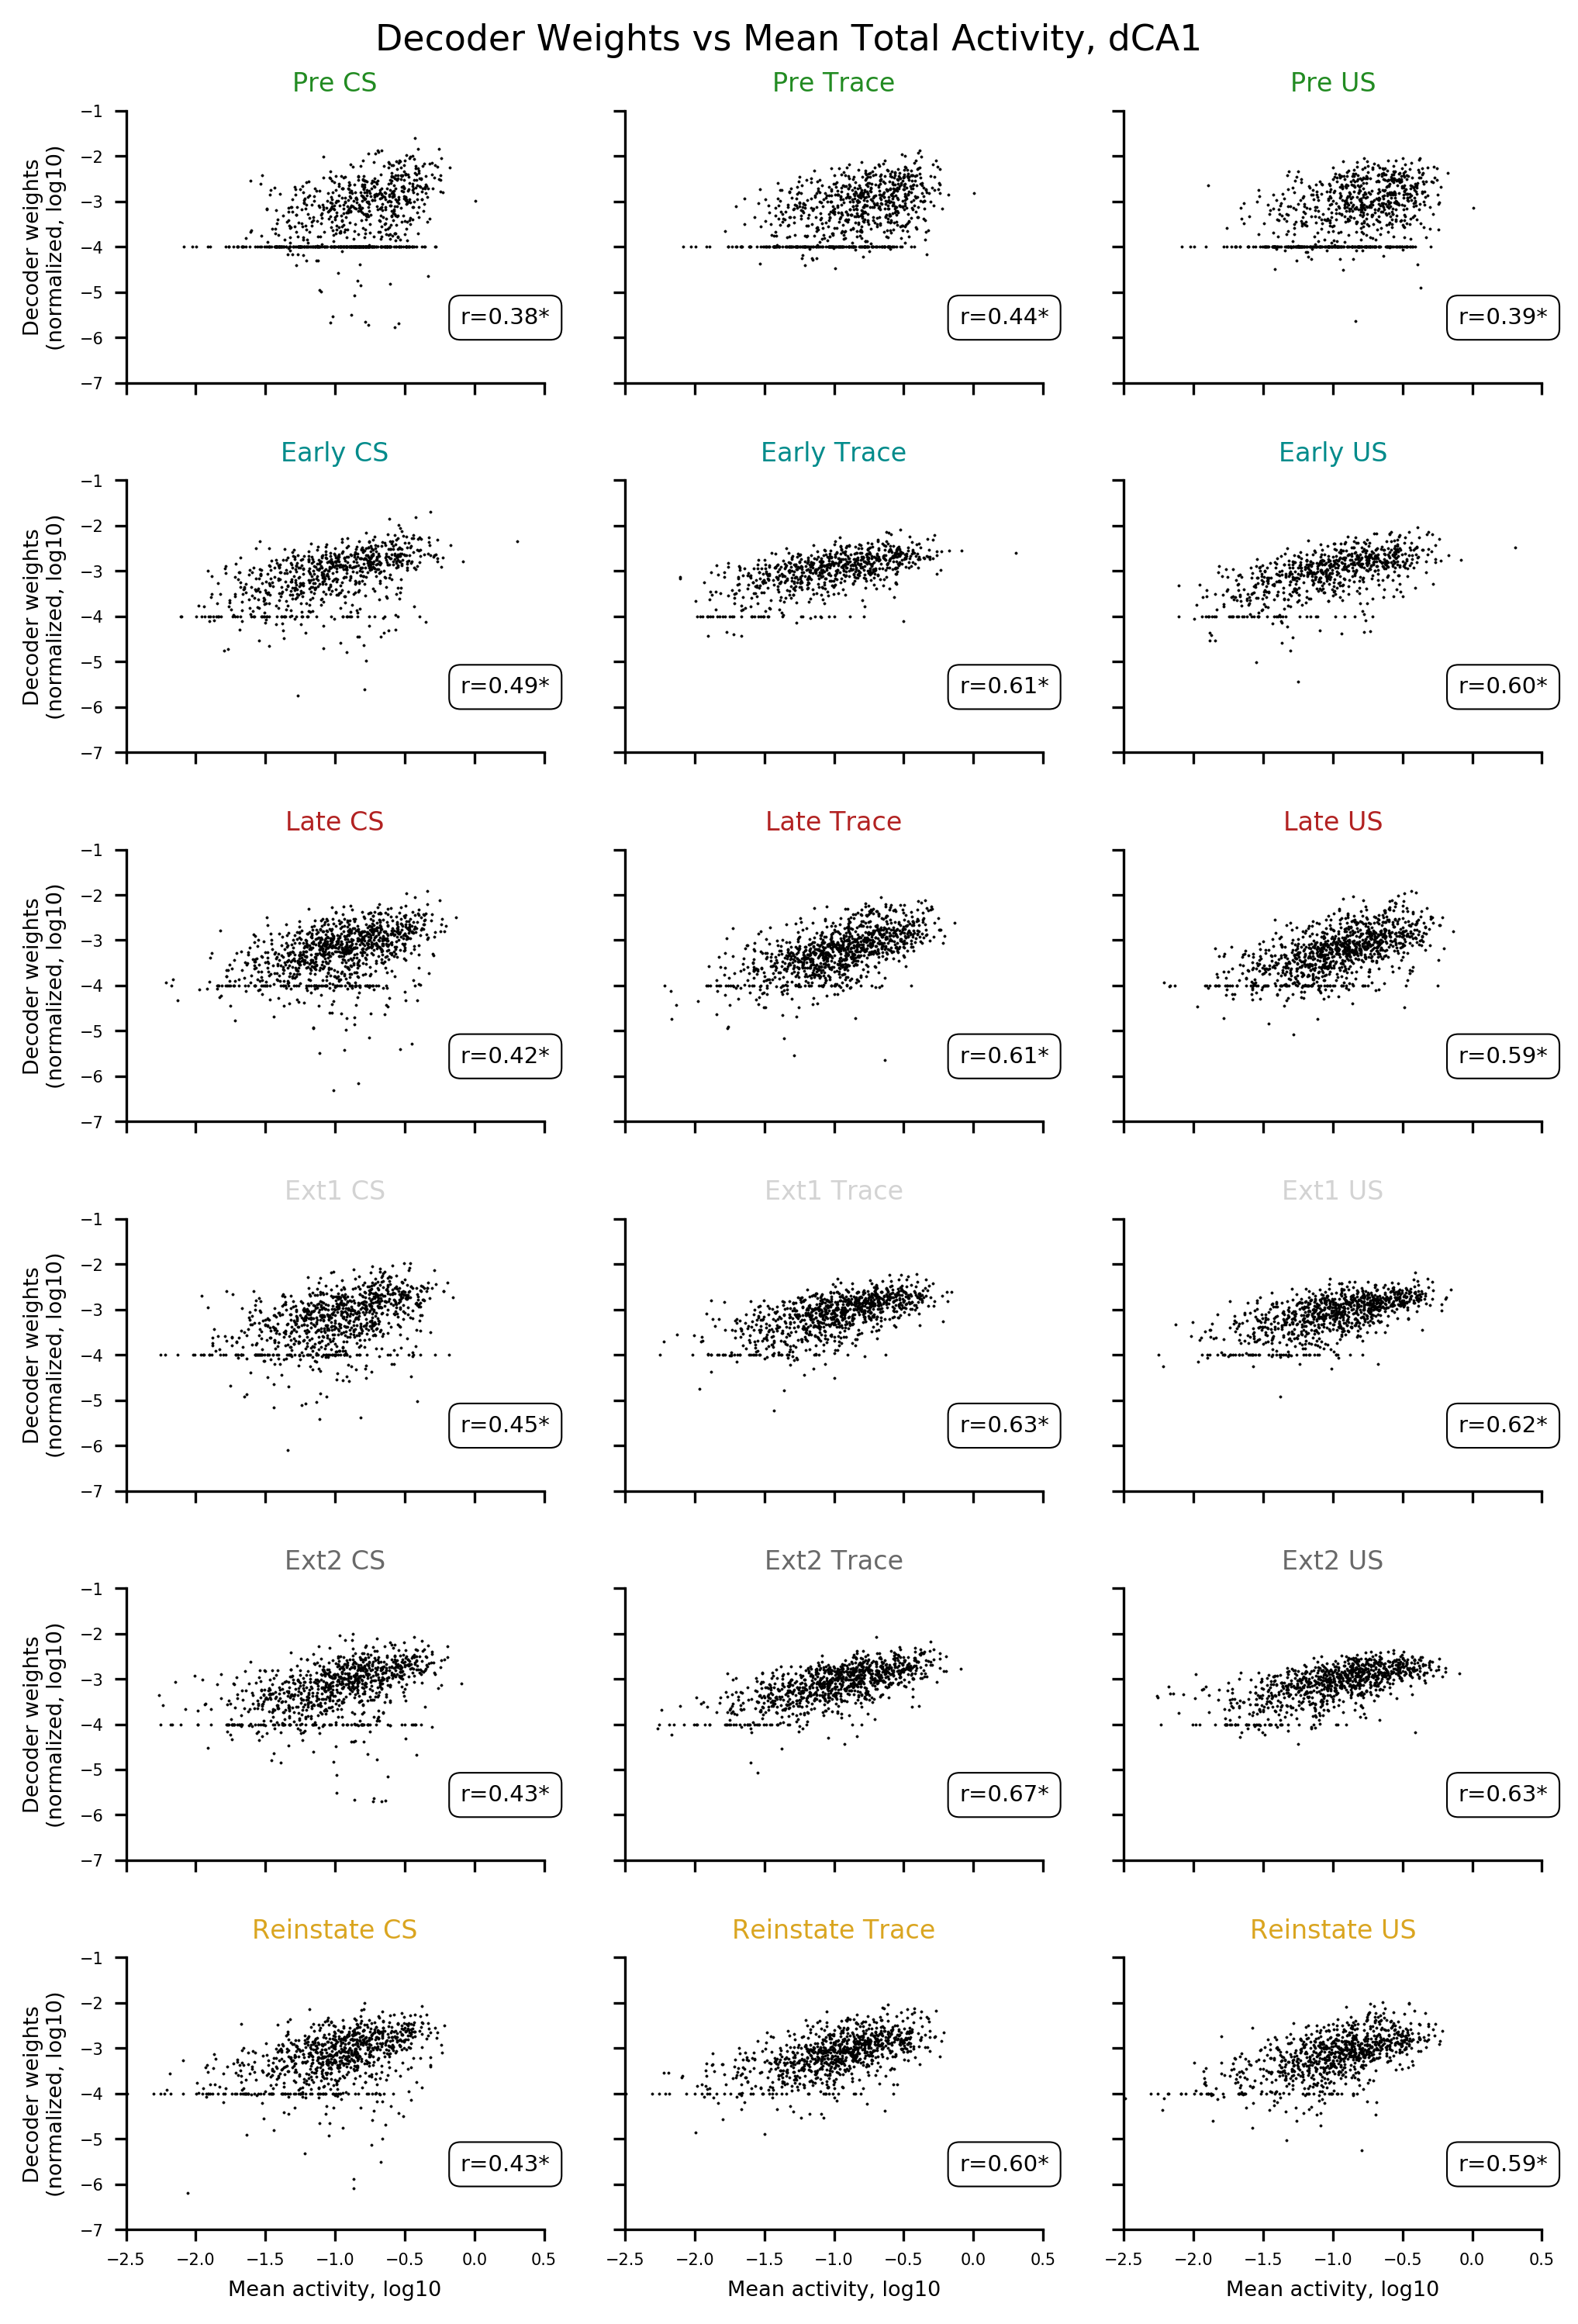

In [56]:
fig, ax = pl.subplots(6,3, figsize=(7, 10),sharex=True,sharey=True)
i=-1
colors = ('forestgreen','darkcyan','firebrick','lightgrey','dimgrey','goldenrod')
for sess,sessl in zip(sessions,('Pre','Early','Late','Ext1','Ext2','Reinstate')):
    i=i+1
    for t,tt,ttt,titl in zip((6,8,10),(1,3,5),range(0,3),('CS','Trace','US')):
        y = eval("avg_sum_norm_abs_weights_tb_%s_log10[sess]"%t)
        x = eval("avg_events_%s_log10"%(sess))
        ax[i][ttt].plot(x,y,'ko',markersize=.8,mew=.1)
    #ax[i].set_xlim(-.08,.08)
    #ax[i].set_ylim(-.08,.08)
    #for tb,lc,d in zip(('5','7','8','9','10','11','12'),('r','orange','g','cyan','b','purple','k'),
    #                   ('0','2','3','4','5','6','7')):
    #    y = eval("avg_sum_norm_abs_weights_tb_%s[sess]"%tb)
        slope, intercept, r_value, p_value, std_err = sstats.linregress(x,y)
        line = slope*(np.unique(x))+intercept
        r2 = r_value*r_value
        if p_value < 0.05:
            lbl = '*'
        else:
            lbl = '\np = {:.2f}'.format(p_value)
        #ax[i][ttt].plot(np.unique(x), line, colors[i], label=('r$^2$ = {:.2f}\n'.format(r2))+lbl)
        ax[i][ttt].set_title(sessl+' '+titl,color=colors[i],fontsize=8)
        #ax[i][ttt].legend(loc='best',prop={'size': 5.5})
        ax[len(sessions)-1][ttt].set_xlabel("Mean activity, log10",fontsize=6.5)
        #ax[i][ttt].invert_xaxis()
        ax[i][ttt].set_xlim(-2.5,.5)
        ax[i][ttt].set_ylim(-7,-1)
        #ax[i][ttt].vlines(-1.3,0,1,linestyles='dashed',color='b')
        ax[i][0].set_ylabel("Decoder weights\n(normalized, log10)",fontsize=6.5)
        ax[i][ttt].text(0.8,0.2,('r={:.2f}'.format(abs(r_value))+lbl),transform=ax[i][ttt].transAxes,fontsize=7,
                verticalalignment='bottom',bbox=dict(facecolor='none',edgecolor='black',boxstyle='round',linewidth=.5,pad=0.5))
pl.suptitle('Decoder Weights vs Mean Total Activity, dCA1',fontsize=11, y=1)

#pl.xlim(-.08,.08)
#pl.ylim(-.08,.08)
fig.tight_layout(pad=3)
pl.savefig("../img/%s_weights_vs_total_activity_log10.pdf"%NOTEBOOK_NAME)

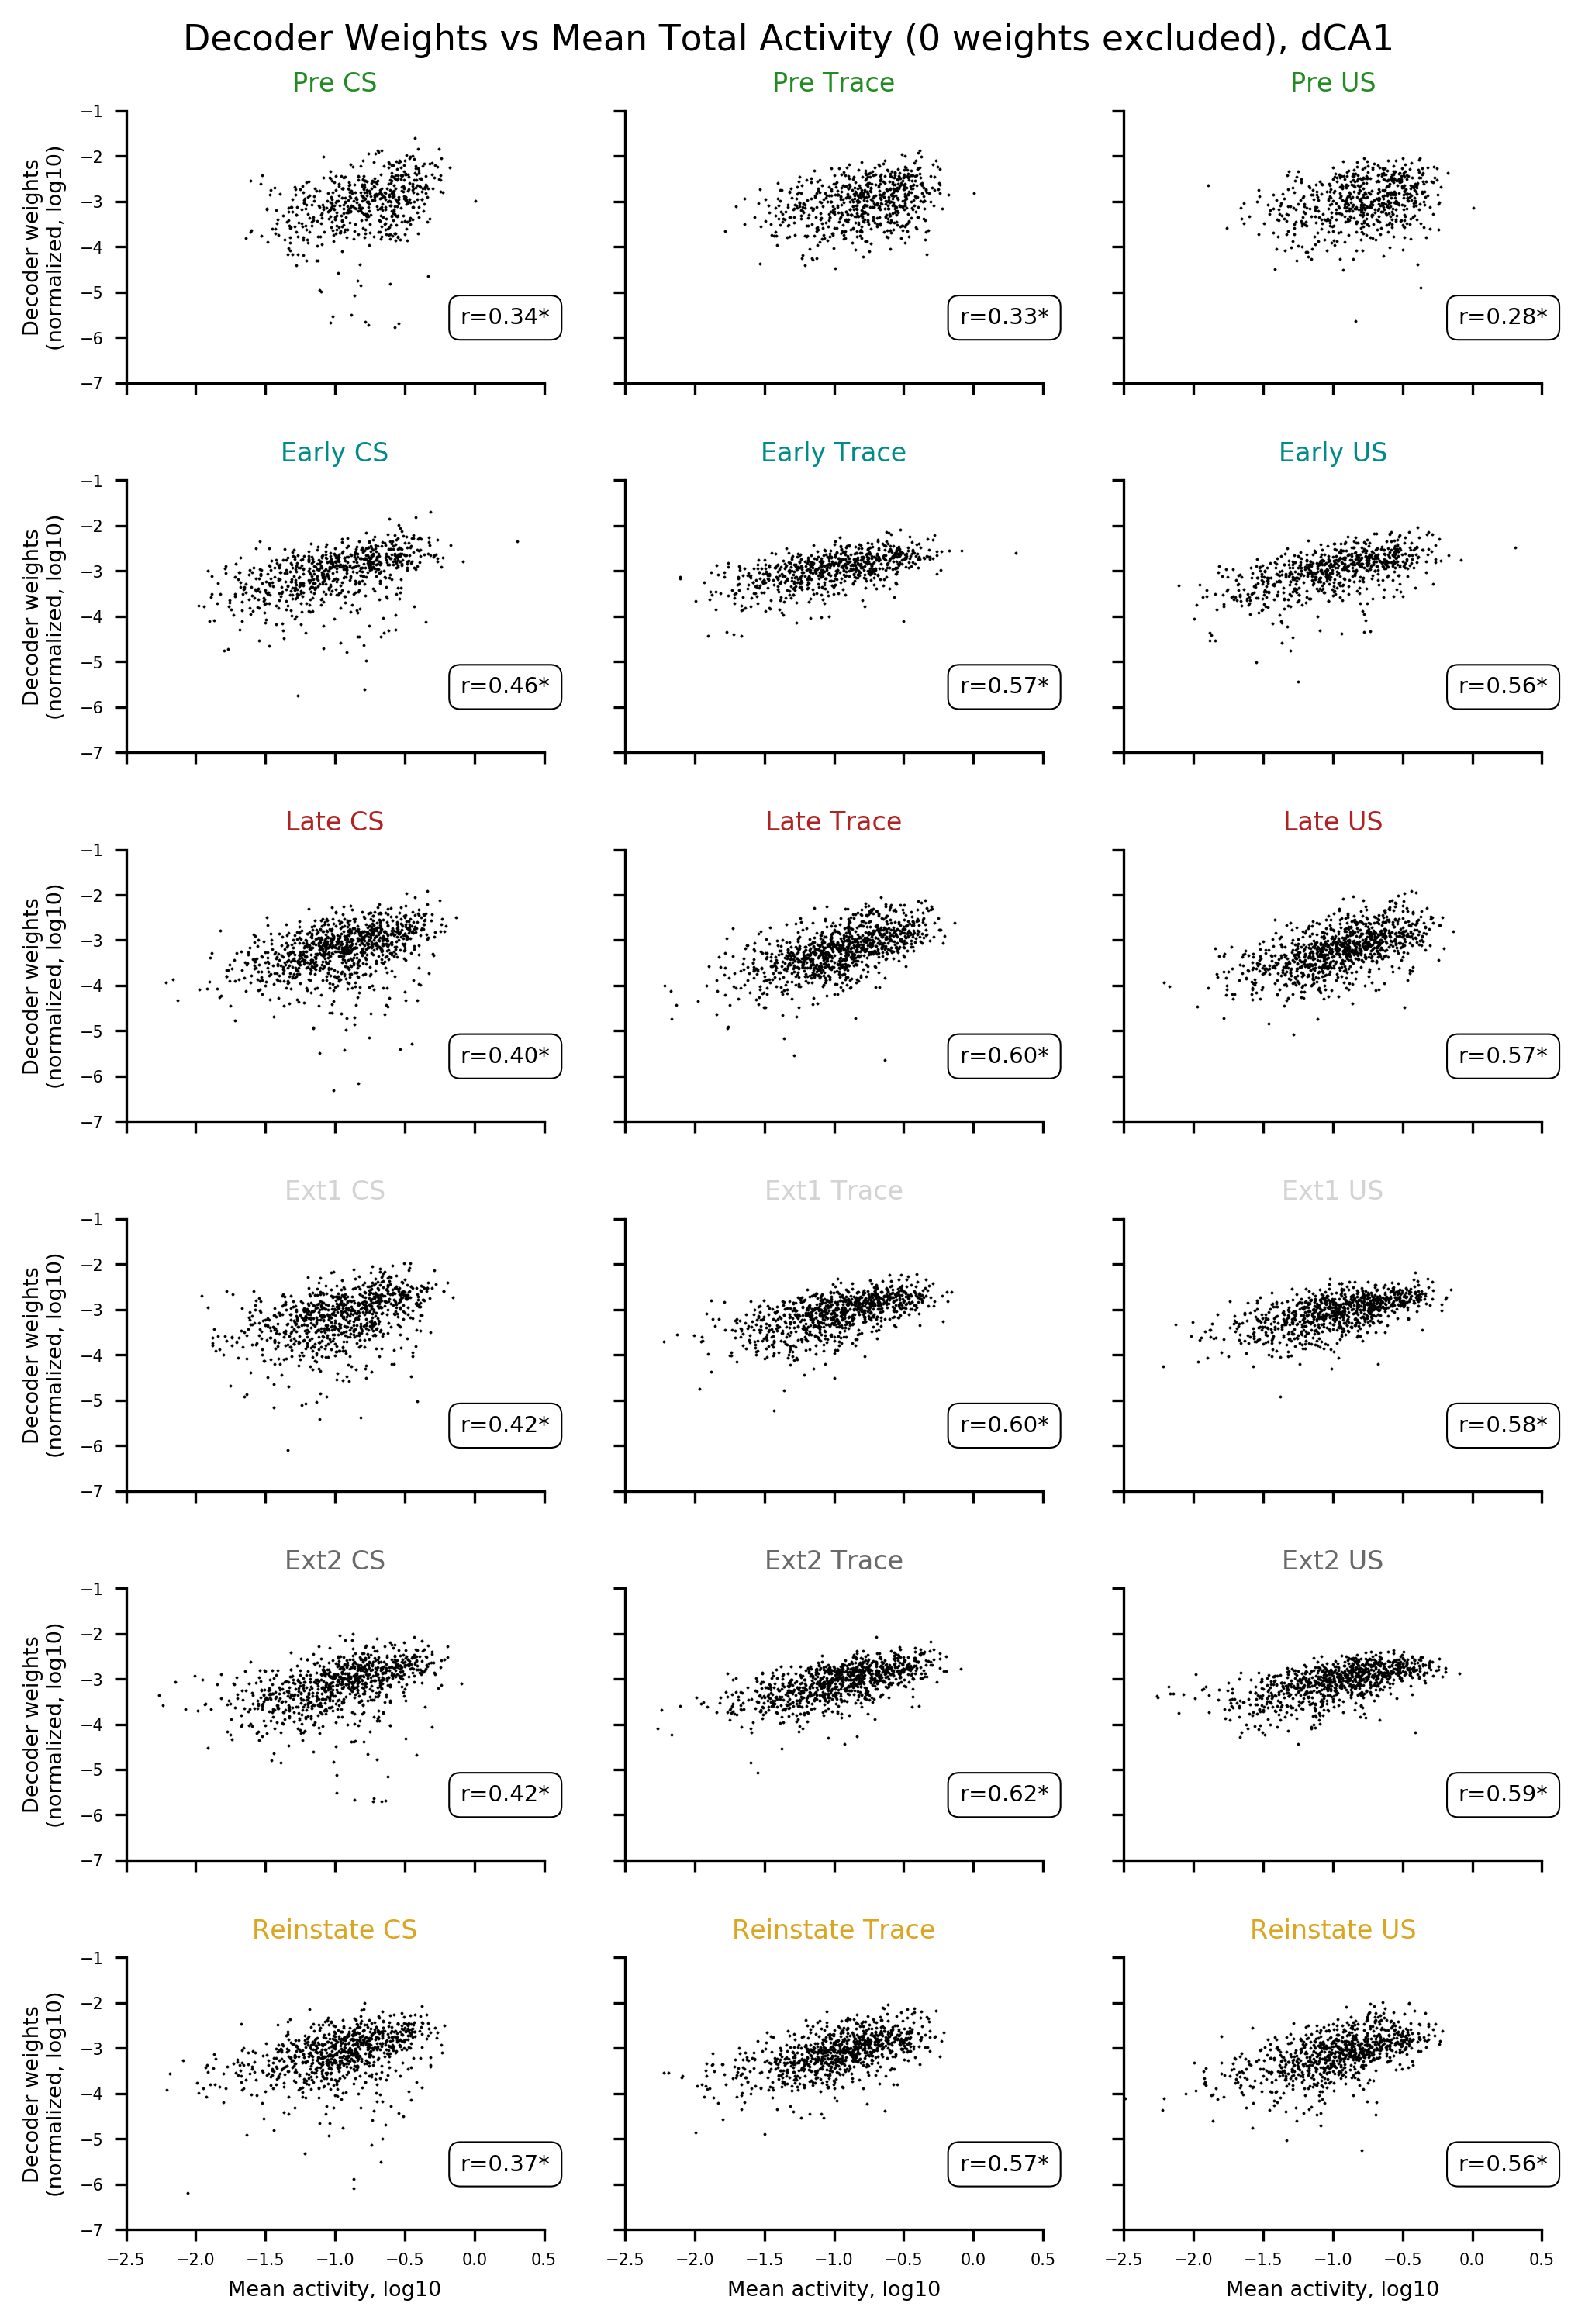

In [89]:
fig, ax = pl.subplots(6,3, figsize=(7, 10),sharex=True,sharey=True)
i=-1
colors = ('forestgreen','darkcyan','firebrick','lightgrey','dimgrey','goldenrod')
for sess,sessl in zip(sessions,('Pre','Early','Late','Ext1','Ext2','Reinstate')):
    i=i+1
    for t,tt,ttt,titl in zip((6,8,10),(1,3,5),range(0,3),('CS','Trace','US')):
        y = eval("avg_sum_norm_abs_weights_tb_%s_log10_no0[sess]"%t)
        x = eval("avg_events_tb_%s_%s_log10_no0"%(t,sess))
        ax[i][ttt].plot(x,y,'ko',markersize=.8,mew=.1)
    #ax[i].set_xlim(-.08,.08)
    #ax[i].set_ylim(-.08,.08)
    #for tb,lc,d in zip(('5','7','8','9','10','11','12'),('r','orange','g','cyan','b','purple','k'),
    #                   ('0','2','3','4','5','6','7')):
    #    y = eval("avg_sum_norm_abs_weights_tb_%s[sess]"%tb)
        slope, intercept, r_value, p_value, std_err = sstats.linregress(x,y)
        line = slope*(np.unique(x))+intercept
        r2 = r_value*r_value
        if p_value < 0.05:
            lbl = '*'
        else:
            lbl = '\np = {:.2f}'.format(p_value)
        #ax[i][ttt].plot(np.unique(x), line, colors[i], label=('r$^2$ = {:.2f}\n'.format(r2))+lbl)
        ax[i][ttt].set_title(sessl+' '+titl,color=colors[i],fontsize=8)
        #ax[i][ttt].legend(loc='best',prop={'size': 5.5})
        ax[len(sessions)-1][ttt].set_xlabel("Mean activity, log10",fontsize=6.5)
        #ax[i][ttt].invert_xaxis()
        ax[i][ttt].set_xlim(-2.5,.5)
        ax[i][ttt].set_ylim(-7,-1)
        #ax[i][ttt].vlines(-1.3,0,1,linestyles='dashed',color='b')
        ax[i][0].set_ylabel("Decoder weights\n(normalized, log10)",fontsize=6.5)
        ax[i][ttt].text(0.8,0.2,('r={:.2f}'.format(abs(r_value))+lbl),transform=ax[i][ttt].transAxes,fontsize=7,
                verticalalignment='bottom',bbox=dict(facecolor='none',edgecolor='black',boxstyle='round',linewidth=.5,pad=0.5))
pl.suptitle('Decoder Weights vs Mean Total Activity (0 weights excluded), dCA1',fontsize=11, y=1)

#pl.xlim(-.08,.08)
#pl.ylim(-.08,.08)
fig.tight_layout(pad=3)
pl.savefig("../final-ish figures/%s_weights_vs_total_activity_log10_no0.pdf"%NOTEBOOK_NAME)

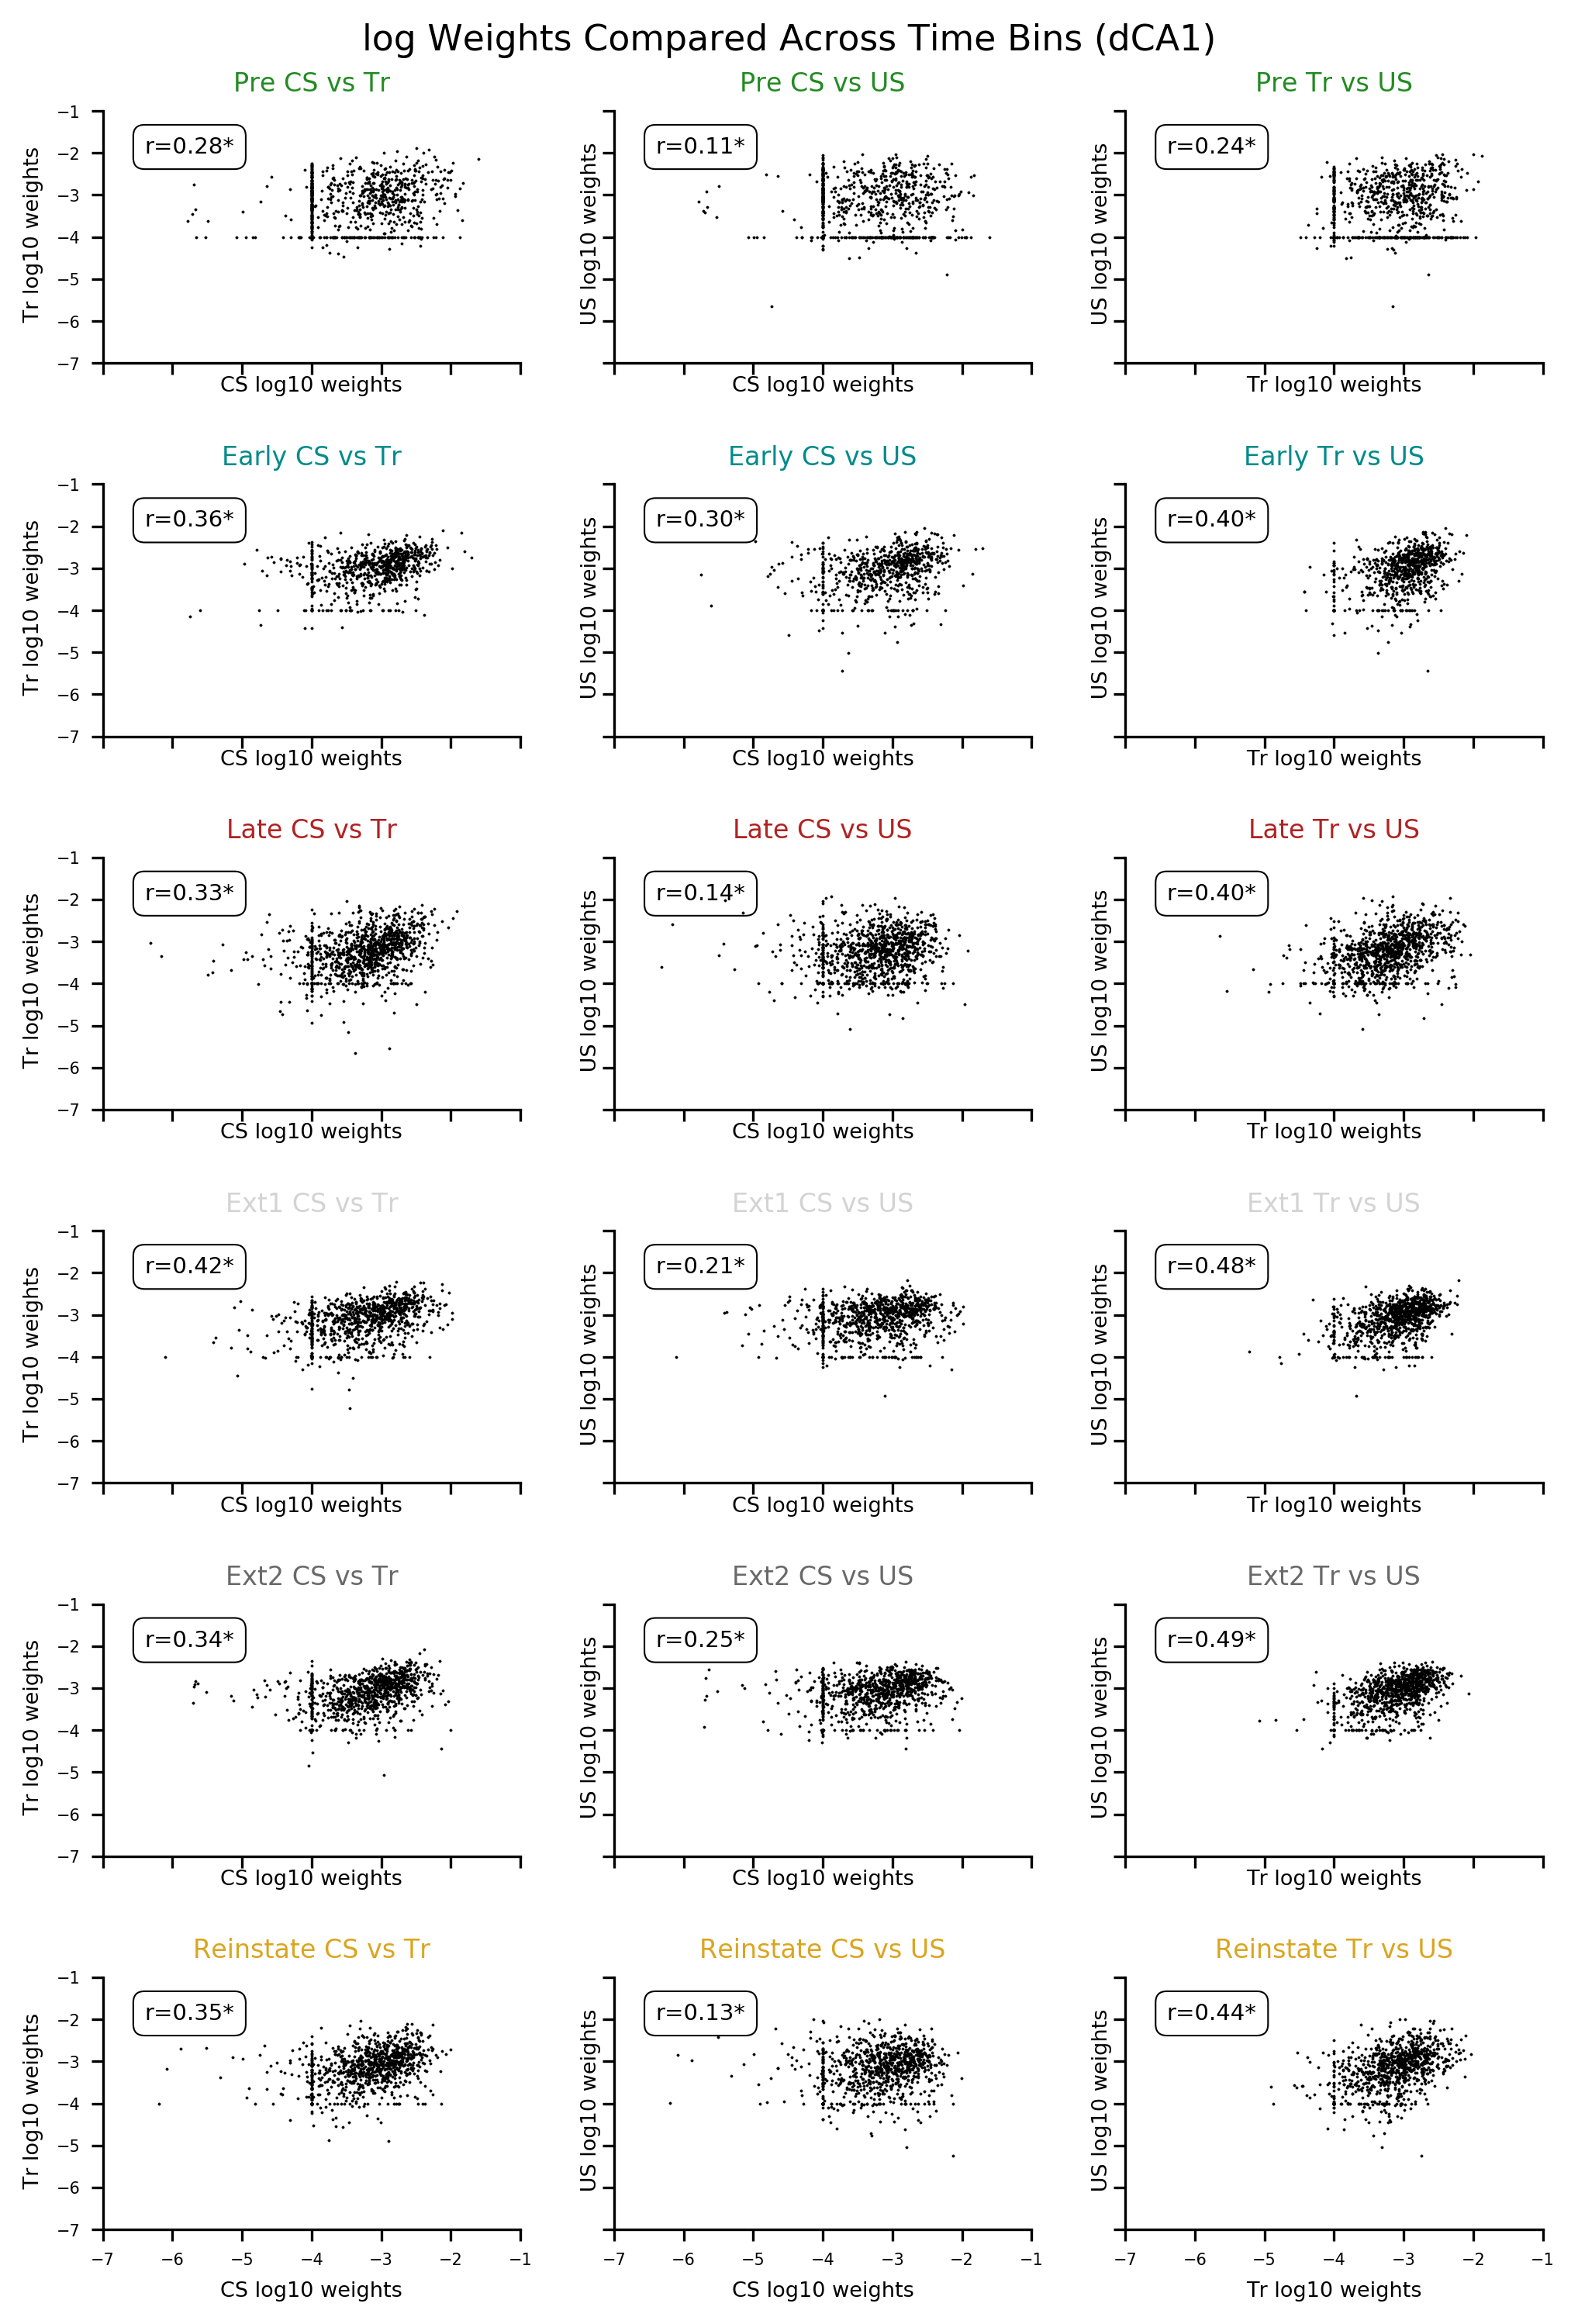

In [58]:
fig, ax = pl.subplots(6,3, figsize=(7, 10),sharex=True,sharey=True)
i=-1
colors = ('forestgreen','darkcyan','firebrick','lightgrey','dimgrey','goldenrod')
for sess,sessl in zip(sessions,('Pre','Early','Late','Ext1','Ext2','Reinstate')):
    i=i+1
    for t,tt,ttt,titl in zip(([6,8],[6,10],[8,10]),(1,3,5),range(0,3),('CS vs Tr','CS vs US','Tr vs US')):
        x = eval("avg_sum_norm_abs_weights_tb_%s_log10[sess]"%t[0])
        y = eval("avg_sum_norm_abs_weights_tb_%s_log10[sess]"%t[1])
        ax[i][ttt].plot(x,y,'ko',markersize=.8,mew=.1)
    #ax[i].set_xlim(-.08,.08)
    #ax[i].set_ylim(-.08,.08)
    #for tb,lc,d in zip(('5','7','8','9','10','11','12'),('r','orange','g','cyan','b','purple','k'),
    #                   ('0','2','3','4','5','6','7')):
    #    y = eval("avg_sum_norm_abs_weights_tb_%s[sess]"%tb)
        slope, intercept, r_value, p_value, std_err = sstats.linregress(x,y)
        line = slope*(np.unique(x))+intercept
        r2 = r_value*r_value
        if p_value < 0.05:
            lbl = '*'
        else:
            lbl = '\np = {:.2f}'.format(p_value)
        #ax[i][ttt].plot(np.unique(x), line, colors[i], label=('r$^2$ = {:.2f}\n'.format(r2))+lbl)
        ax[i][ttt].set_title(sessl+' '+titl,color=colors[i],fontsize=8)
        #ax[i][ttt].legend(loc='best',prop={'size': 5.5})
        ax[i][ttt].set_xlabel(titl.split('vs')[0]+"log10 weights",fontsize=6.5)
        #ax[i][ttt].invert_xaxis()
        ax[i][ttt].set_xlim(-7,-1)
        ax[i][ttt].set_ylim(-7,-1)
        #ax[i][ttt].vlines(-1.3,0,1,linestyles='dashed',color='b')
        ax[i][ttt].set_ylabel(titl.split('vs')[1]+" log10 weights",fontsize=6.5)
        ax[i][ttt].text(0.1,0.9,('r={:.2f}'.format((r_value))+lbl),transform=ax[i][ttt].transAxes,fontsize=7,verticalalignment='top',
                        bbox=dict(facecolor='none',edgecolor='black',boxstyle='round',linewidth=.5,pad=0.5))
pl.suptitle('log Weights Compared Across Time Bins (dCA1)',fontsize=11, y=1)

#pl.xlim(-.08,.08)
#pl.ylim(-.08,.08)
fig.tight_layout(pad=3)
pl.savefig("../img/%s_weights_vs_weights_log10.pdf"%NOTEBOOK_NAME)

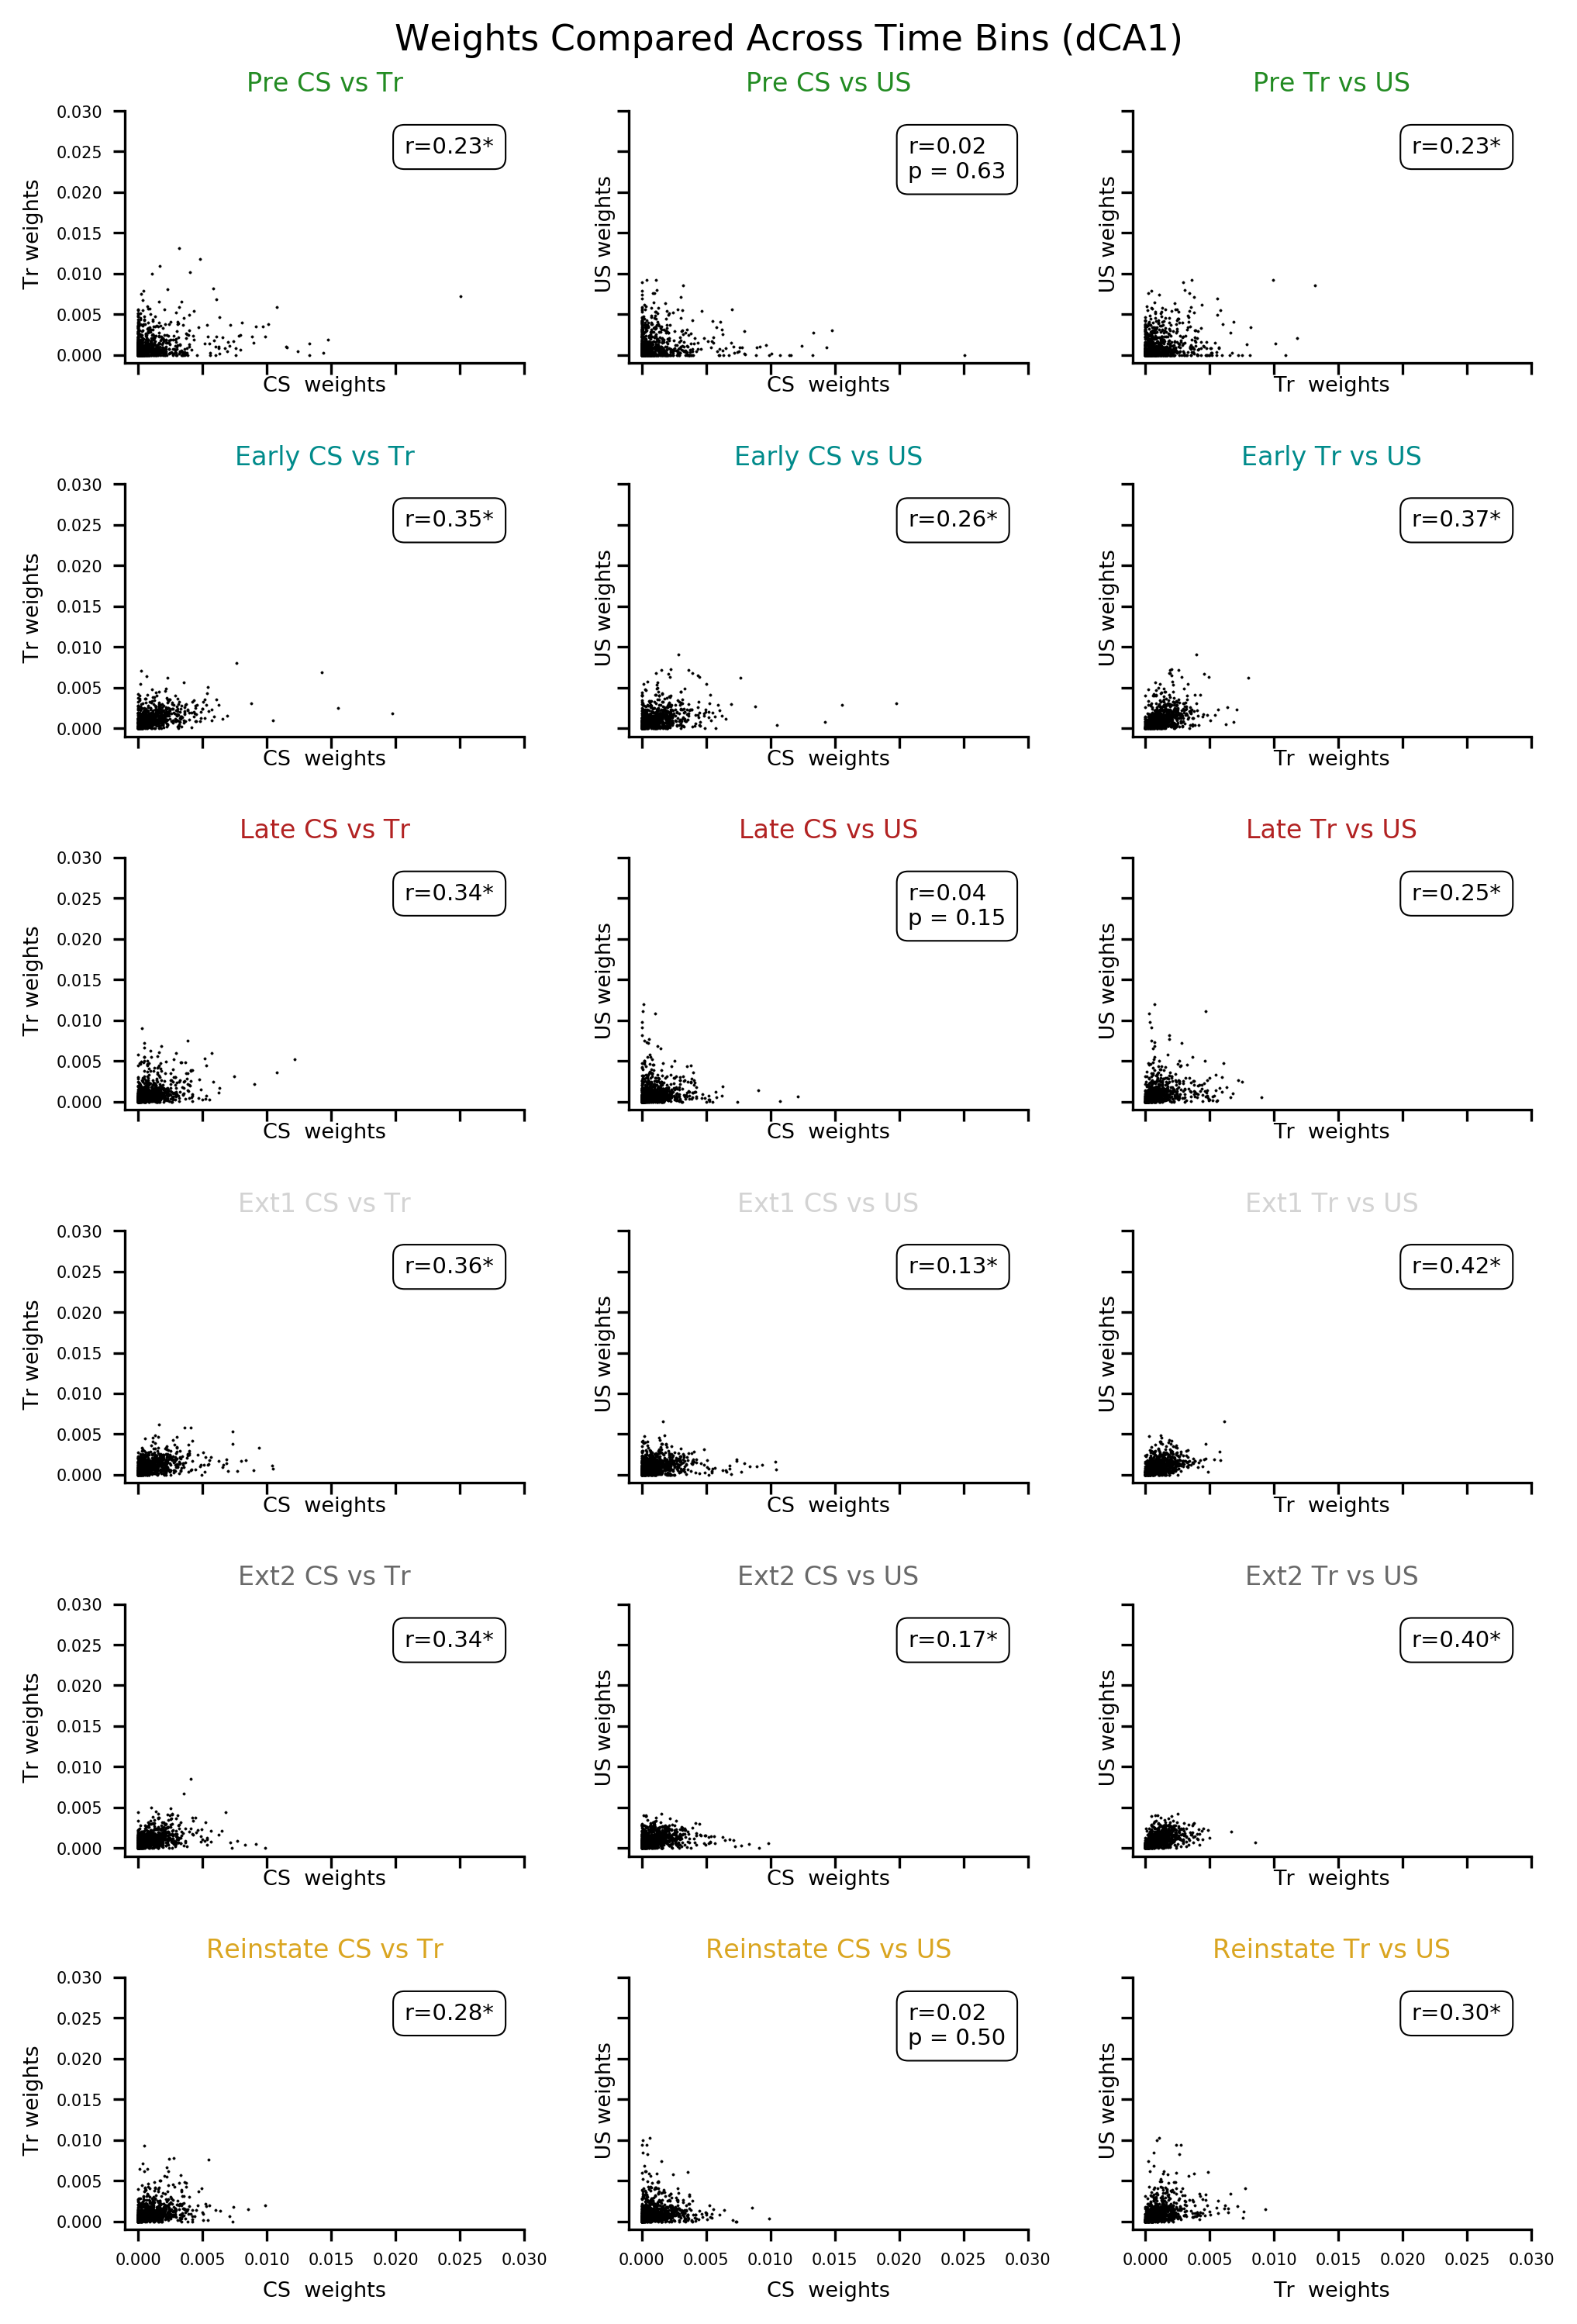

In [59]:
fig, ax = pl.subplots(6,3, figsize=(7, 10),sharex=True,sharey=True)
i=-1
colors = ('forestgreen','darkcyan','firebrick','lightgrey','dimgrey','goldenrod')
for sess,sessl in zip(sessions,('Pre','Early','Late','Ext1','Ext2','Reinstate')):
    i=i+1
    for t,tt,ttt,titl in zip(([6,8],[6,10],[8,10]),(1,3,5),range(0,3),('CS vs Tr','CS vs US','Tr vs US')):
        x = eval("avg_sum_norm_abs_weights_tb_%s[sess]"%t[0])
        y = eval("avg_sum_norm_abs_weights_tb_%s[sess]"%t[1])
        ax[i][ttt].plot(x,y,'ko',markersize=.8,mew=.1)
    #ax[i].set_xlim(-.08,.08)
    #ax[i].set_ylim(-.08,.08)
    #for tb,lc,d in zip(('5','7','8','9','10','11','12'),('r','orange','g','cyan','b','purple','k'),
    #                   ('0','2','3','4','5','6','7')):
    #    y = eval("avg_sum_norm_abs_weights_tb_%s[sess]"%tb)
        slope, intercept, r_value, p_value, std_err = sstats.linregress(x,y)
        line = slope*(np.unique(x))+intercept
        r2 = r_value*r_value
        if p_value < 0.05:
            lbl = '*'
        else:
            lbl = '\np = {:.2f}'.format(p_value)
        #ax[i][ttt].plot(np.unique(x), line, colors[i], label=('r$^2$ = {:.2f}\n'.format(r2))+lbl)
        ax[i][ttt].set_title(sessl+' '+titl,color=colors[i],fontsize=8)
        #ax[i][ttt].legend(loc='best',prop={'size': 5.5})
        ax[i][ttt].set_xlabel(titl.split('vs')[0]+" weights",fontsize=6.5)
        #ax[i][ttt].invert_xaxis()
        ax[i][ttt].set_xlim(-0.001,.03)
        ax[i][ttt].set_ylim(-0.001,.03)
        #ax[i][ttt].vlines(-1.3,0,1,linestyles='dashed',color='b')
        ax[i][ttt].set_ylabel(titl.split('vs')[1]+" weights",fontsize=6.5)
        ax[i][ttt].text(0.7,0.9,('r={:.2f}'.format((r_value))+lbl),transform=ax[i][ttt].transAxes,fontsize=7,verticalalignment='top',
                        bbox=dict(facecolor='none',edgecolor='black',boxstyle='round',linewidth=.5,pad=0.5))
pl.suptitle('Weights Compared Across Time Bins (dCA1)',fontsize=11, y=1)

#pl.xlim(-.08,.08)
#pl.ylim(-.08,.08)
fig.tight_layout(pad=3)
pl.savefig("../img/%s_weights_vs_weights.pdf"%NOTEBOOK_NAME)

In [60]:
#extract 0 weighted cells that occur in either of the time bins we want to compare (CSvsTr,CSvsUS, TrvsUS)
for t in [(6,8),(6,10),(8,10)]:
    exec("avg_sum_norm_abs_weights_tb_%svs%s_log10_no0s = {}"%(t[0],t[1])) #will exclude all 0 weighted cells
    exec("avg_sum_norm_abs_weights_tb_%svs%s_log10_no0s = {}"%(t[1],t[0])) #will exclude all 0 weighted cells
for sess in sessions:
    for t in [(6,8),(6,10),(8,10)]:
        exec("avg_sum_norm_abs_weights_tb_%svs%s_log10_no0s[sess] = []"%(t[0],t[1]))
        exec("avg_sum_norm_abs_weights_tb_%svs%s_log10_no0s[sess] = []"%(t[1],t[0]))
        for x,y in zip(eval("avg_sum_norm_abs_weights_tb_%s[sess]"%t[0]),eval("avg_sum_norm_abs_weights_tb_%s[sess]"%t[1])):
            if x == 0 or y == 0:
                print '',
            else:
                exec("avg_sum_norm_abs_weights_tb_%svs%s_log10_no0s[sess].append(math.log10(x))"%(t[0],t[1]))
                exec("avg_sum_norm_abs_weights_tb_%svs%s_log10_no0s[sess].append(math.log10(y))"%(t[1],t[0]))

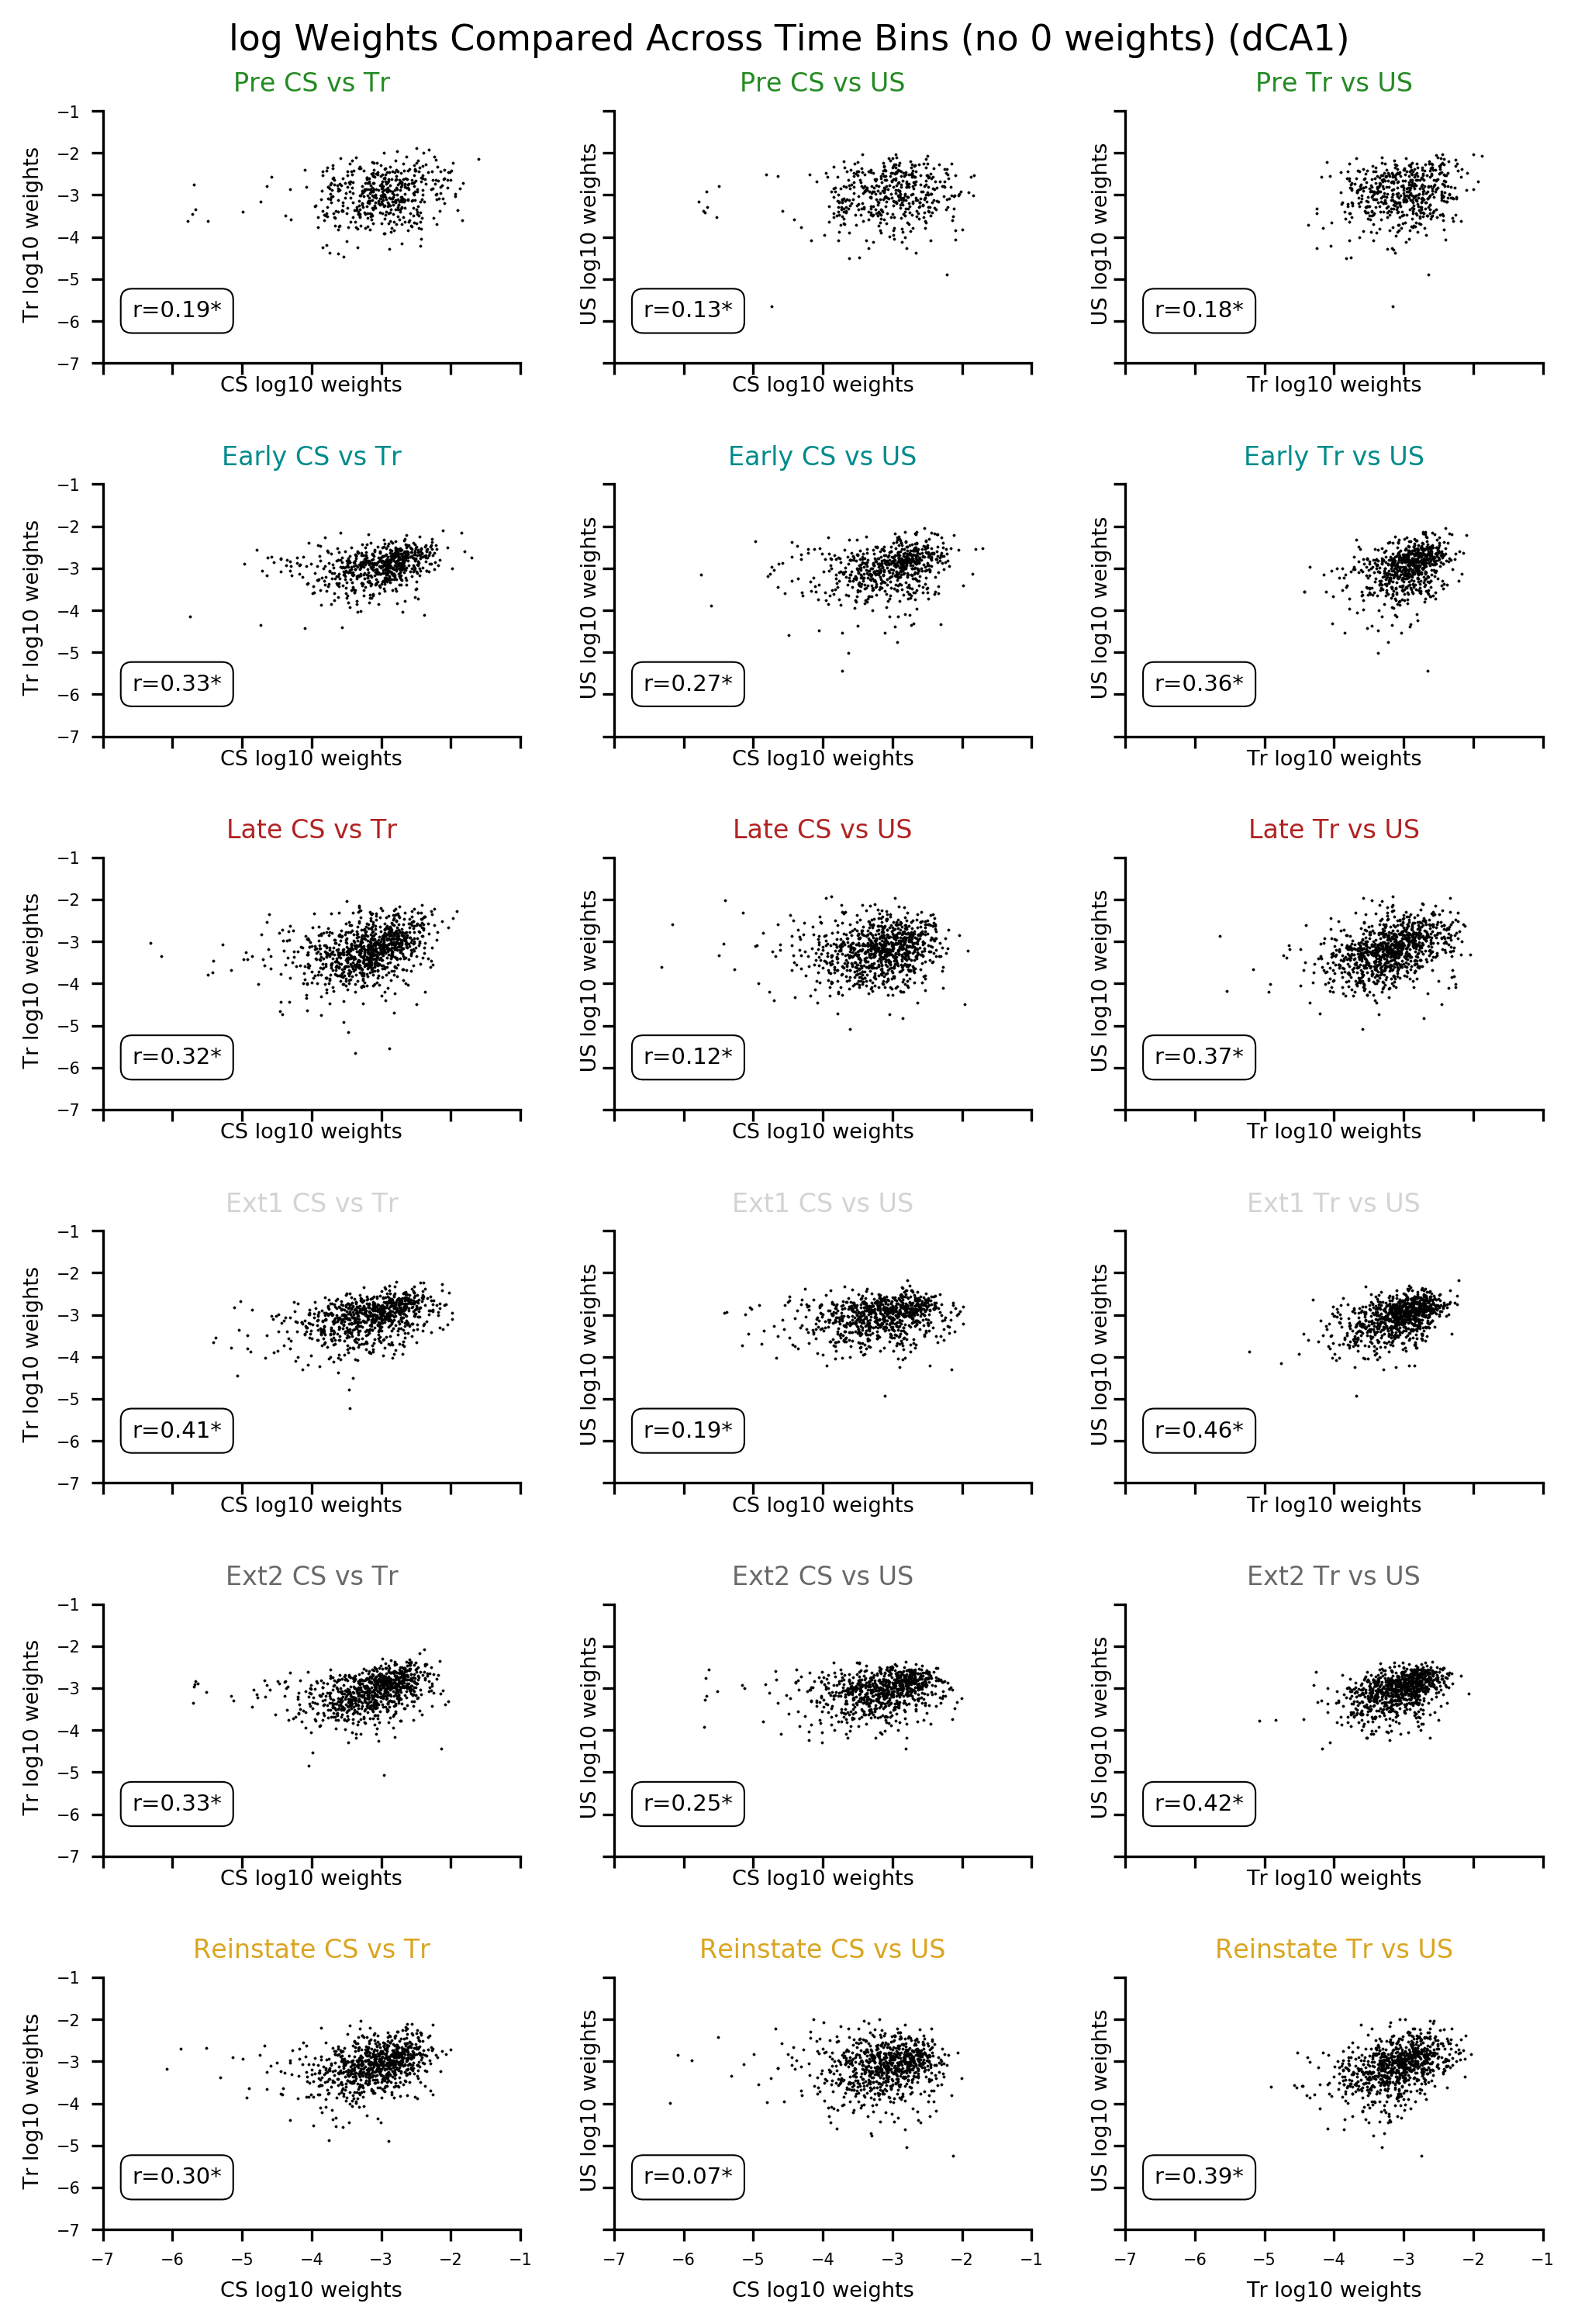

In [61]:
fig, ax = pl.subplots(6,3, figsize=(7, 10),sharex=True,sharey=True)
i=-1
colors = ('forestgreen','darkcyan','firebrick','lightgrey','dimgrey','goldenrod')
for sess,sessl in zip(sessions,('Pre','Early','Late','Ext1','Ext2','Reinstate')):
    i=i+1
    for t,tt,ttt,titl in zip(([6,8],[6,10],[8,10]),(1,3,5),range(0,3),('CS vs Tr','CS vs US','Tr vs US')):
        x = eval("avg_sum_norm_abs_weights_tb_%svs%s_log10_no0s[sess]"%(t[0],t[1]))
        y = eval("avg_sum_norm_abs_weights_tb_%svs%s_log10_no0s[sess]"%(t[1],t[0]))
        ax[i][ttt].plot(x,y,'ko',markersize=.8,mew=.1)
    #ax[i].set_xlim(-.08,.08)
    #ax[i].set_ylim(-.08,.08)
    #for tb,lc,d in zip(('5','7','8','9','10','11','12'),('r','orange','g','cyan','b','purple','k'),
    #                   ('0','2','3','4','5','6','7')):
    #    y = eval("avg_sum_norm_abs_weights_tb_%s[sess]"%tb)
        slope, intercept, r_value, p_value, std_err = sstats.linregress(x,y)
        line = slope*(np.unique(x))+intercept
        r2 = r_value*r_value
        if p_value < 0.05:
            lbl = '*'
        else:
            lbl = '\np = {:.2f}'.format(p_value)
        #ax[i][ttt].plot(np.unique(x), line, colors[i], label=('r$^2$ = {:.2f}\n'.format(r2))+lbl)
        ax[i][ttt].set_title(sessl+' '+titl,color=colors[i],fontsize=8)
        #ax[i][ttt].legend(loc='best',prop={'size': 5.5})
        ax[i][ttt].set_xlabel(titl.split('vs')[0]+"log10 weights",fontsize=6.5)
        #ax[i][ttt].invert_xaxis()
        ax[i][ttt].set_xlim(-7,-1)
        ax[i][ttt].set_ylim(-7,-1)
        #ax[i][ttt].vlines(-1.3,0,1,linestyles='dashed',color='b')
        ax[i][ttt].set_ylabel(titl.split('vs')[1]+" log10 weights",fontsize=6.5)
        ax[i][ttt].text(0.07,0.25,('r={:.2f}'.format((r_value))+lbl),transform=ax[i][ttt].transAxes,fontsize=7,verticalalignment='top',
                        bbox=dict(facecolor='none',edgecolor='black',boxstyle='round',linewidth=.5,pad=0.5))
pl.suptitle('log Weights Compared Across Time Bins (no 0 weights) (dCA1)',fontsize=11, y=1)

#pl.xlim(-.08,.08)
#pl.ylim(-.08,.08)
fig.tight_layout(pad=3)
pl.savefig("../img/%s_weights_vs_weights_log10_no0s.pdf"%NOTEBOOK_NAME)

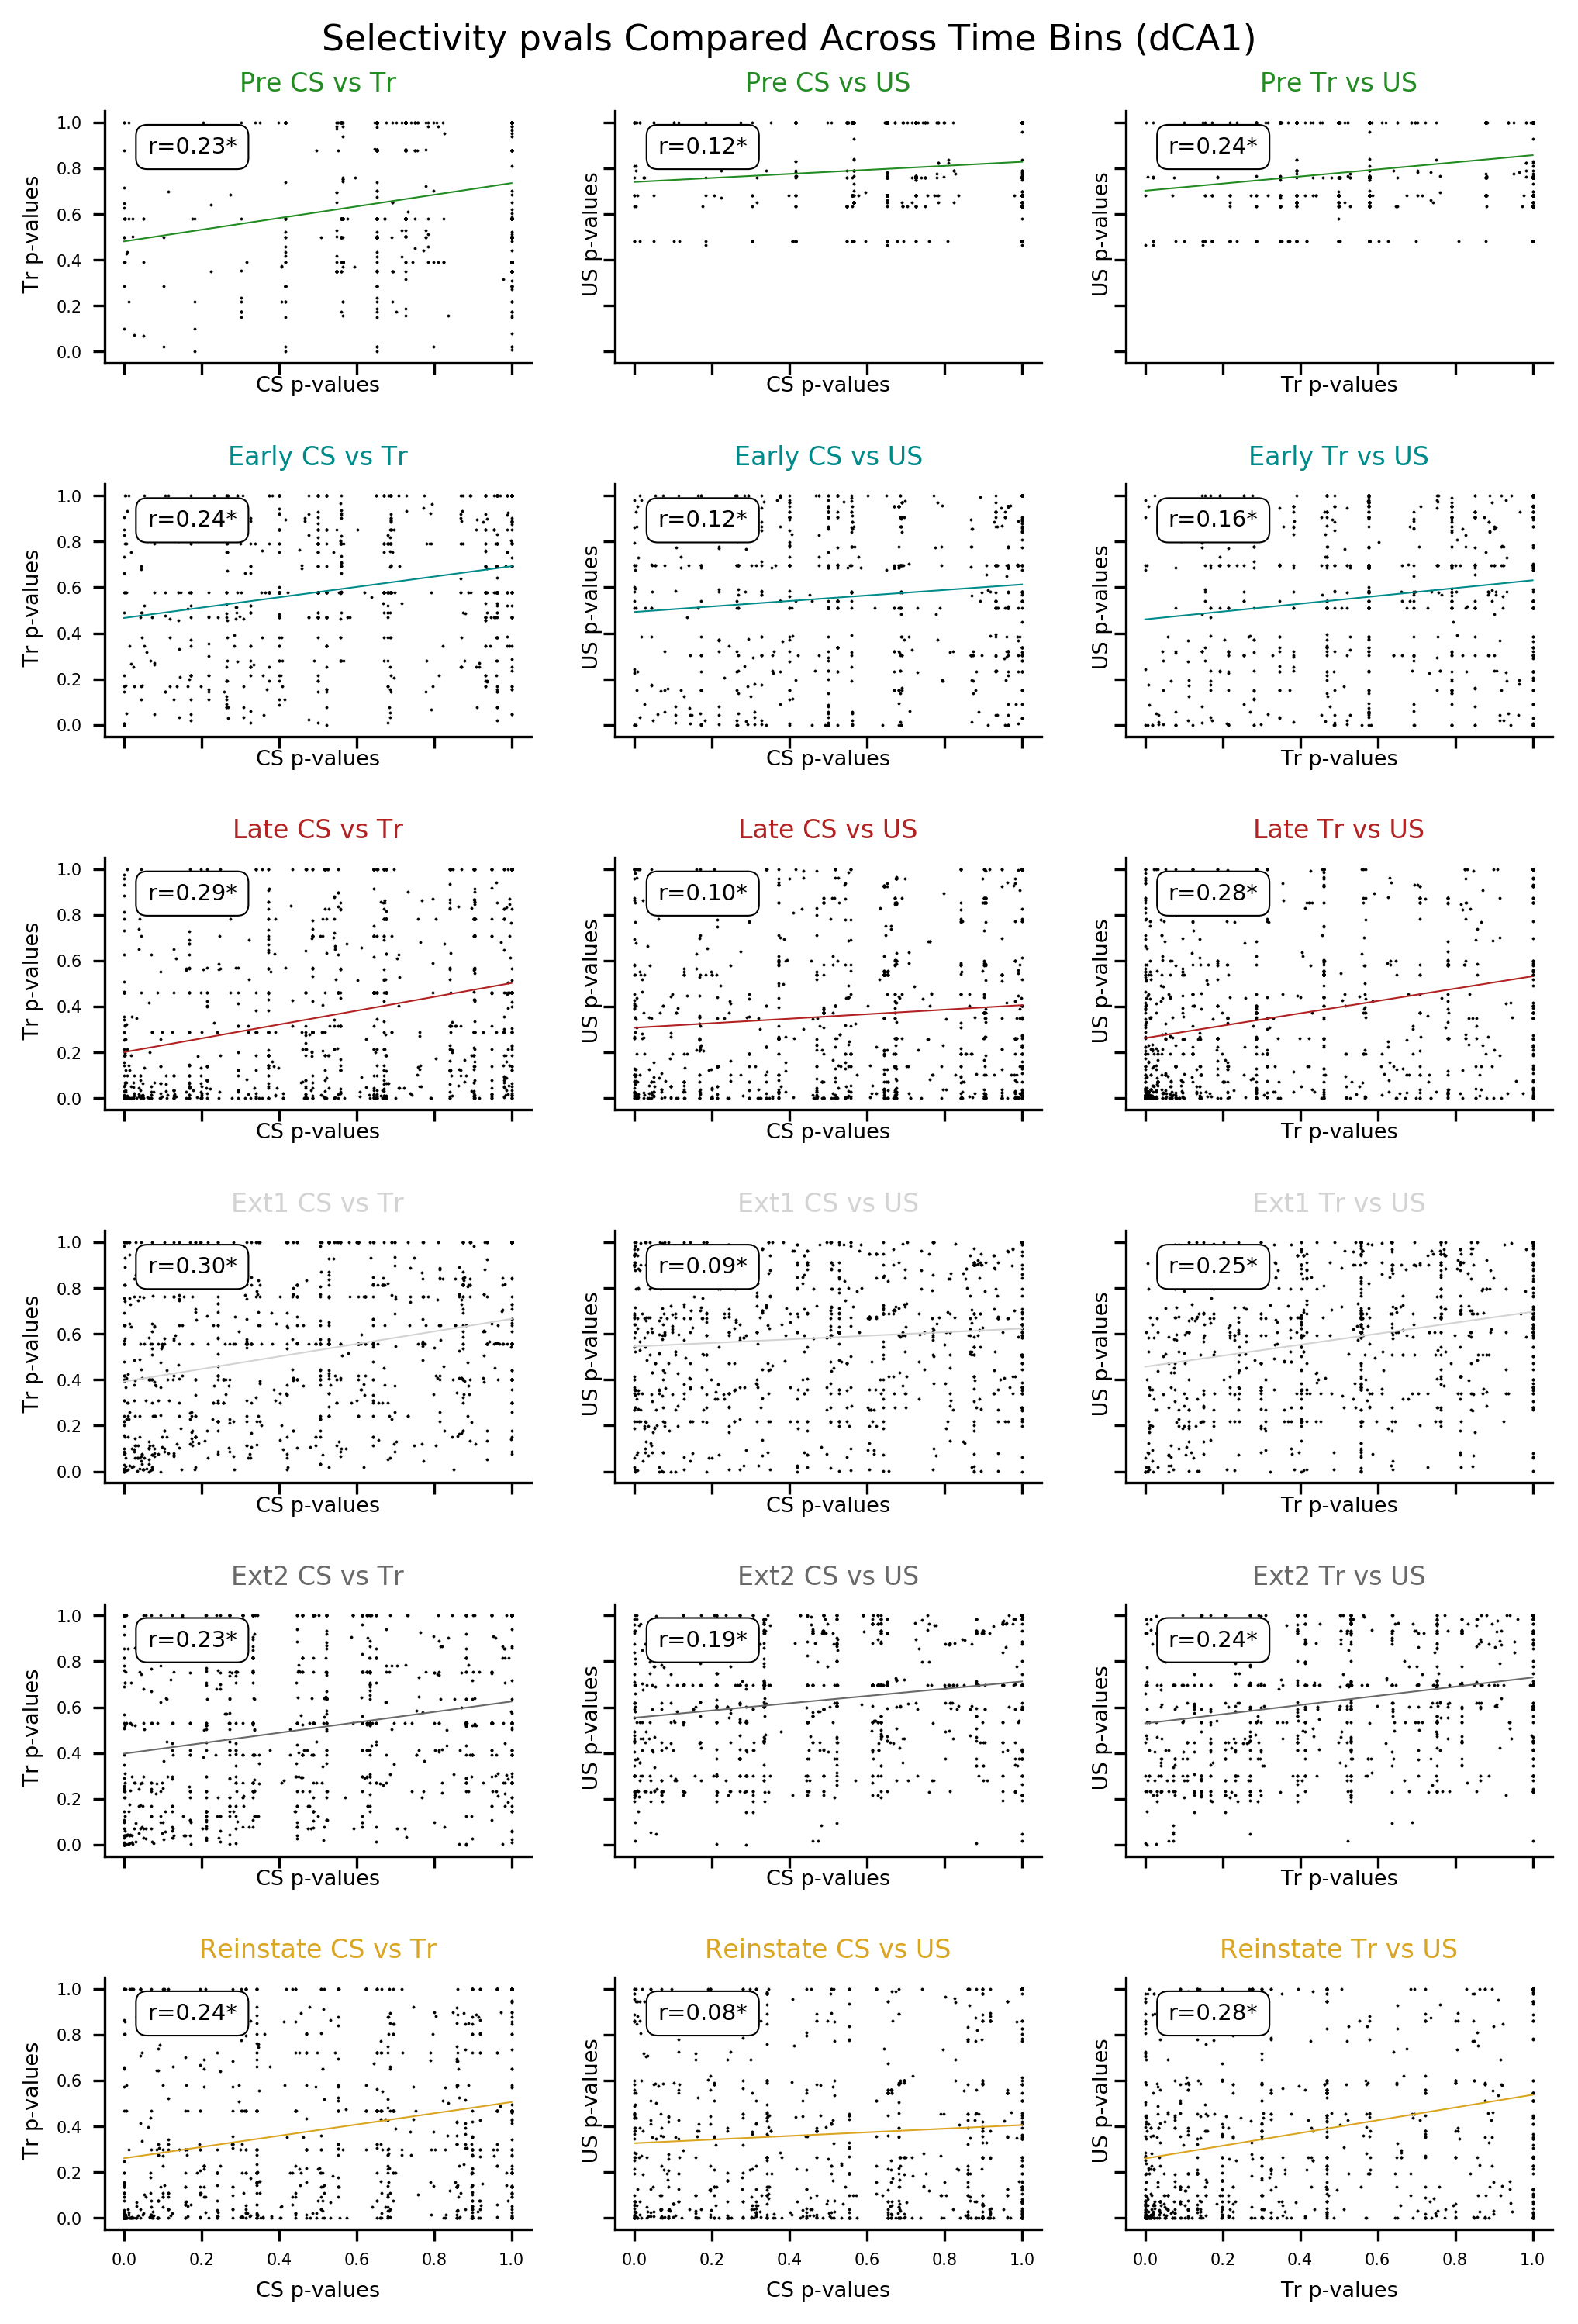

In [78]:
fig, ax = pl.subplots(6,3, figsize=(7, 10),sharex=True,sharey=True)
i=-1
colors = ('forestgreen','darkcyan','firebrick','lightgrey','dimgrey','goldenrod')
for sess,sessl in zip(sessions,('Pre','Early','Late','Ext1','Ext2','Reinstate')):
    i=i+1
    for t,tt,ttt,titl in zip(([1,3],[1,5],[3,5]),range(0,5,2),range(0,3),('CS vs Tr','CS vs US','Tr vs US')):
        x = eval("combined_pvals_1s_rewardt_%ss_corrected[sess]"%t[0])
        y = eval("combined_pvals_1s_rewardt_%ss_corrected[sess]"%t[1])
        ax[i][ttt].plot(x,y,'ko',markersize=.8,mew=.1)
    #ax[i].set_xlim(-.08,.08)
    #ax[i].set_ylim(-.08,.08)
    #for tb,lc,d in zip(('5','7','8','9','10','11','12'),('r','orange','g','cyan','b','purple','k'),
    #                   ('0','2','3','4','5','6','7')):
    #    y = eval("avg_sum_norm_abs_weights_tb_%s[sess]"%tb)
        slope, intercept, r_value, p_value, std_err = sstats.linregress(x,y)
        line = slope*(np.unique(x))+intercept
        r2 = r_value*r_value
        if p_value < 0.05:
            lbl = '*'
        else:
            lbl = '\np = {:.2f}'.format(p_value)
        ax[i][ttt].plot(np.unique(x), line, colors[i], label=('r$^2$ = {:.2f}\n'.format(r2))+lbl)
        ax[i][ttt].set_title(sessl+' '+titl,color=colors[i],fontsize=8)
        #ax[i][ttt].legend(loc='best',prop={'size': 5.5})
        ax[i][ttt].set_xlabel(titl.split('vs')[0]+"p-values",fontsize=6.5)
        #ax[i][ttt].invert_xaxis()
        #ax[i][ttt].set_xlim(0)
        #ax[i][ttt].set_ylim(0)
        #ax[i][ttt].vlines(-1.3,0,1,linestyles='dashed',color='b')
        ax[i][ttt].set_ylabel(titl.split('vs')[1]+" p-values",fontsize=6.5)
        ax[i][ttt].text(0.1,0.9,('r={:.2f}'.format((r_value))+lbl),transform=ax[i][ttt].transAxes,fontsize=7,verticalalignment='top',
                        bbox=dict(facecolor='w',edgecolor='black',boxstyle='round',linewidth=.5,pad=0.5))
pl.suptitle('Selectivity pvals Compared Across Time Bins (dCA1)',fontsize=11, y=1)

#pl.xlim(-.08,.08)
#pl.ylim(-.08,.08)
fig.tight_layout(pad=3)
pl.savefig("../img/%s_pvals_vs_pvals.pdf"%NOTEBOOK_NAME)

# regressing out activity

In [63]:
def linregress_residuals(xdata,ydata):
    """
    This function performs a linear regression and then gets the residuals
    
    Args:
        xdata (array-like): The x data
        ydata (array-like): The y data
        
    Returns:
        residuals: the residuals of the regression
        slope: the slope of regression line
        intercept: intercept of the regression line
        rvalue: correlation coeffficient
        pvalue: two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero.
        stderr: standard error of the estimated gradient
    
    Author: SMM
    """
    
    from scipy import stats
    
    # Get the regression
    (m,b,r,pvalue,stderr)=stats.linregress(xdata,ydata)   
    #print("In regress1, m is: "+str(m))    
    # get the residuals
    residuals = np.copy(xdata)
    for idx,x in enumerate(xdata):
        yfit = m*x+b
        residuals[idx] = yfit-ydata[idx]
        
    return (residuals,m,b,r,pvalue,stderr) 

In [64]:
for sess in sessions:
    for t in 6,8,10:
        y = eval("avg_sum_norm_abs_weights_tb_%s[sess]"%t)
        x = eval("avg_events_%s"%(sess))
        exec("residuals_tb_%s_%s,m_tb_%s_%s,b_tb_%s_%s,r_tb_%s_%s,pvalue_tb_%s_%s,stderr_tb_%s_%s = linregress_residuals(x,y)"%(t,
              sess,t,sess,t,sess,t,sess,t,sess,t,sess))

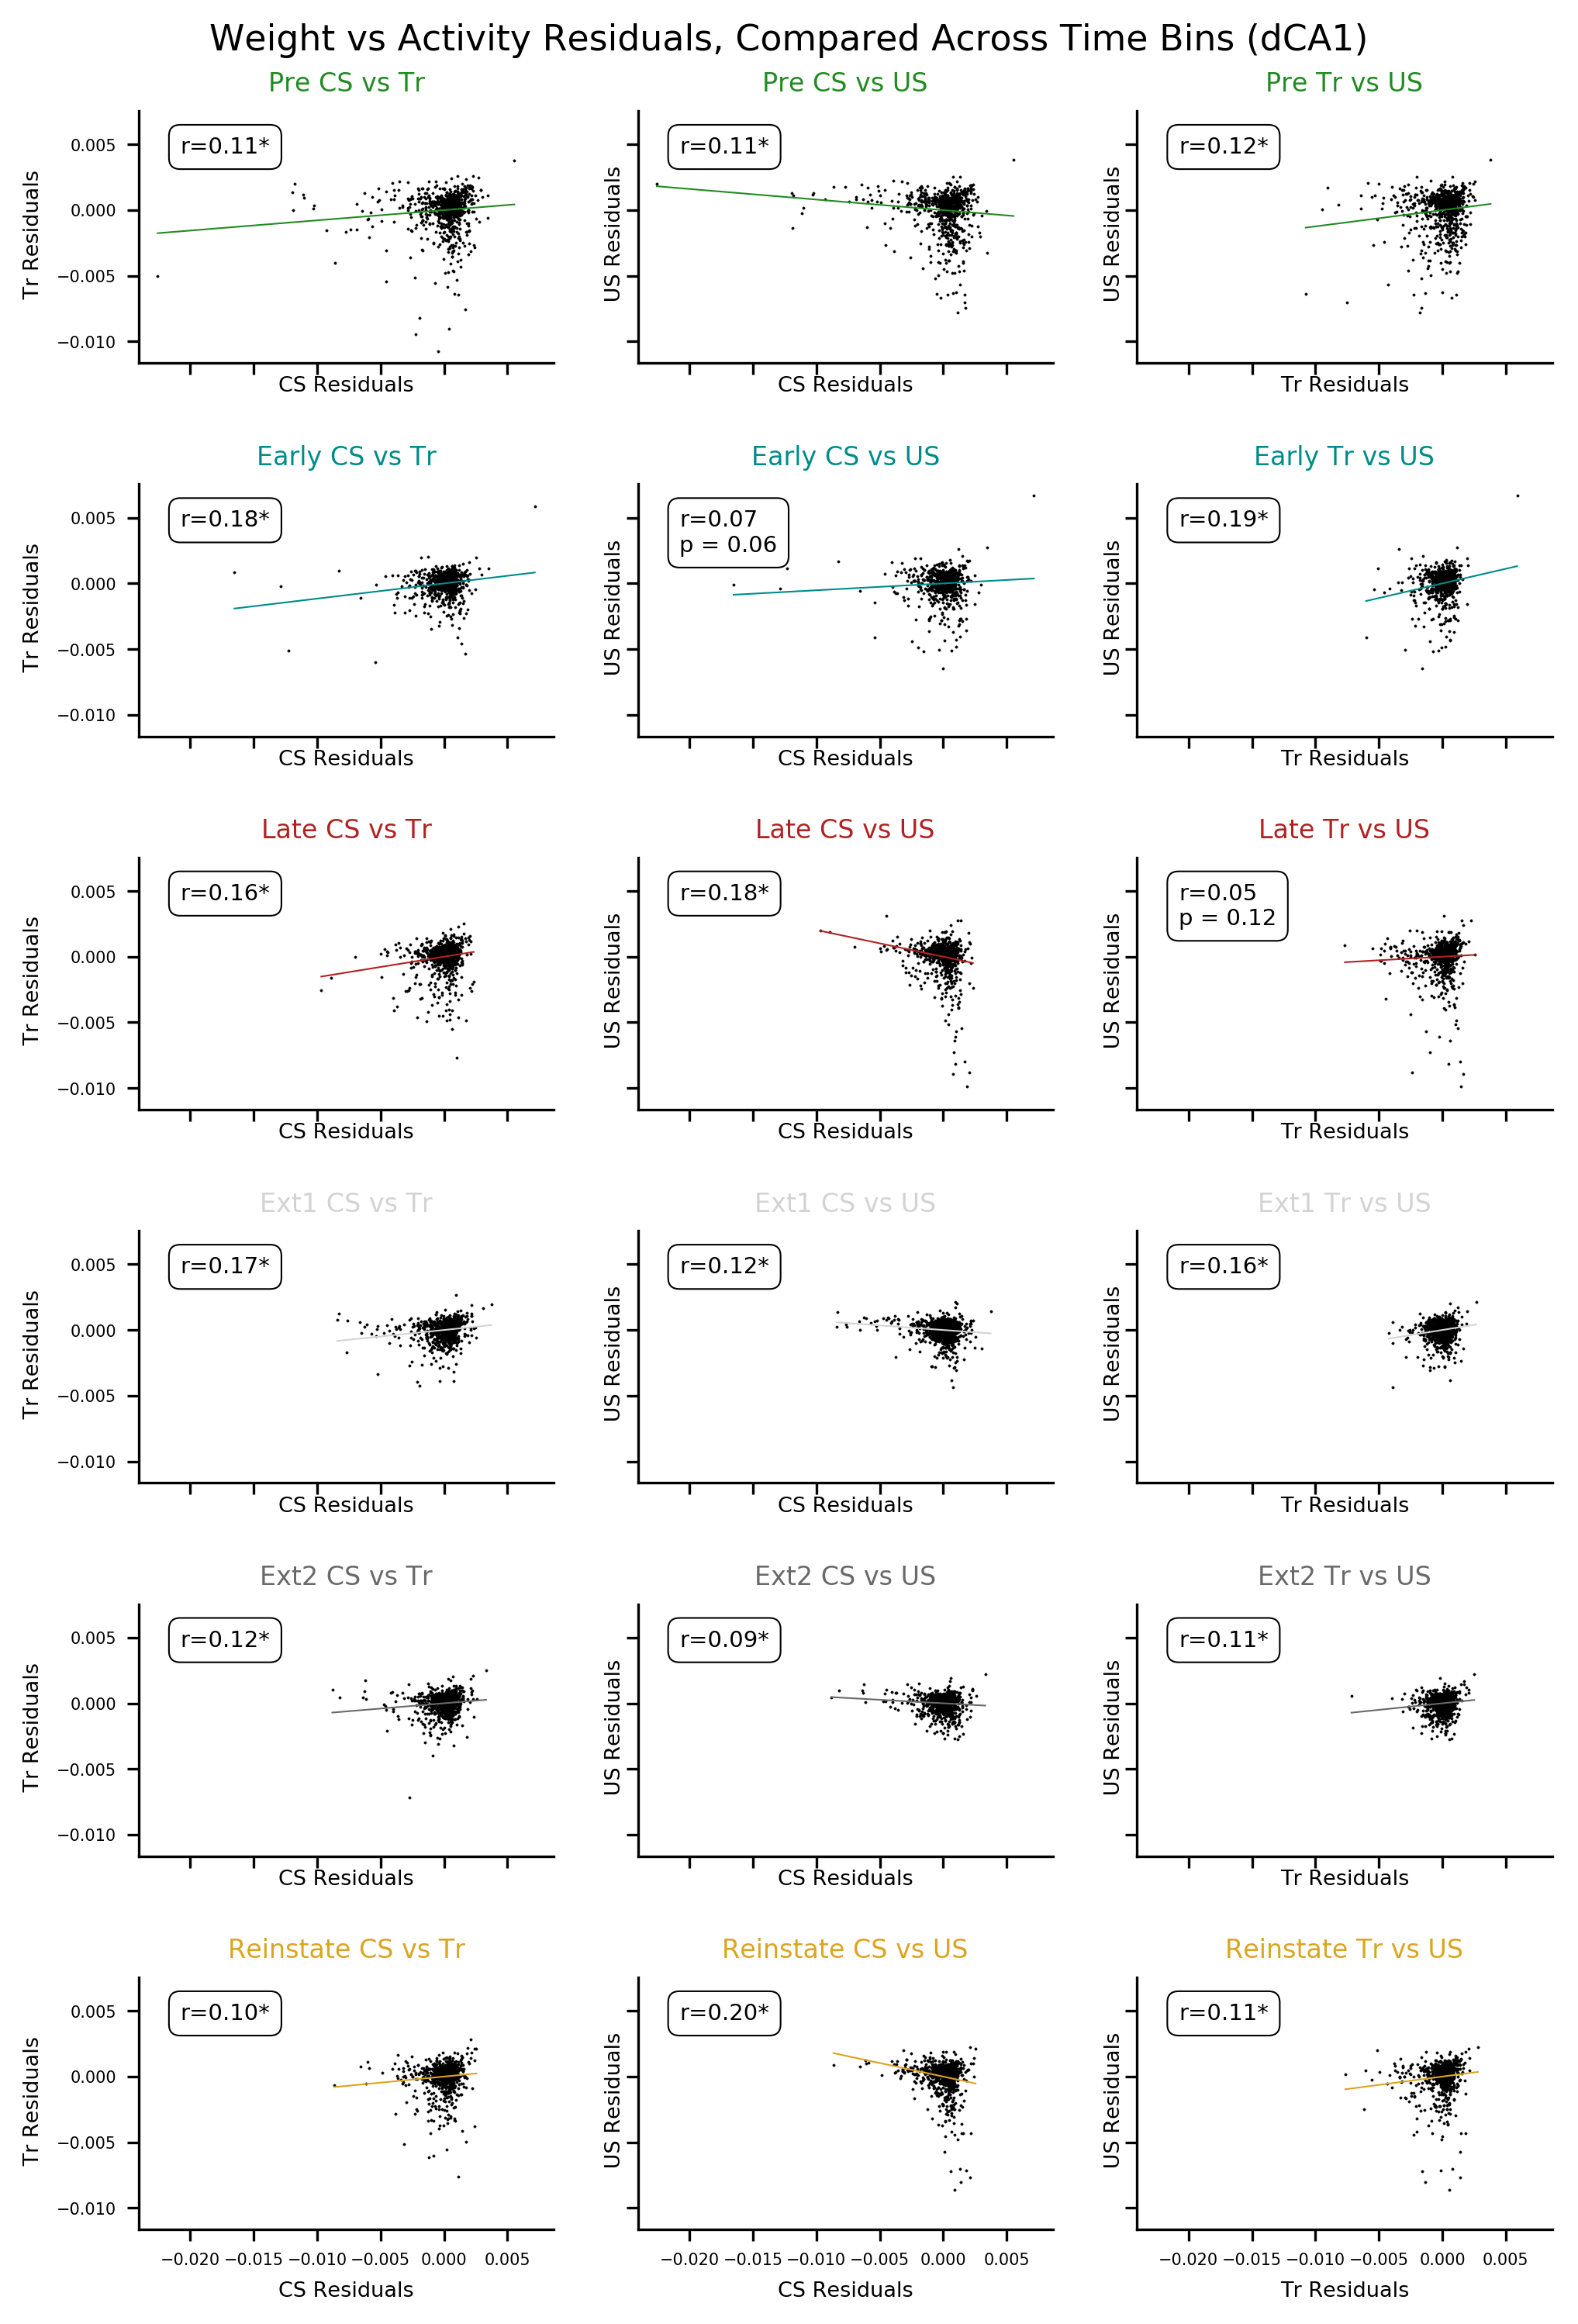

In [65]:
fig, ax = pl.subplots(6,3, figsize=(7, 10),sharex=True,sharey=True)
i=-1
colors = ('forestgreen','darkcyan','firebrick','lightgrey','dimgrey','goldenrod')
for sess,sessl in zip(sessions,('Pre','Early','Late','Ext1','Ext2','Reinstate')):
    i=i+1
    for t,tt,ttt,titl in zip(([6,8],[6,10],[8,10]),(1,3,5),range(0,3),('CS vs Tr','CS vs US','Tr vs US')):
        x = eval("residuals_tb_%s_%s"%(t[0],sess))
        y = eval("residuals_tb_%s_%s"%(t[1],sess))
        ax[i][ttt].plot(x,y,'ko',markersize=.8,mew=.1)
    #ax[i].set_xlim(-.08,.08)
    #ax[i].set_ylim(-.08,.08)
    #for tb,lc,d in zip(('5','7','8','9','10','11','12'),('r','orange','g','cyan','b','purple','k'),
    #                   ('0','2','3','4','5','6','7')):
    #    y = eval("avg_sum_norm_abs_weights_tb_%s[sess]"%tb)
        slope, intercept, r_value, p_value, std_err = sstats.linregress(x,y)
        line = slope*(np.unique(x))+intercept
        r2 = r_value*r_value
        if p_value < 0.05:
            lbl = '*'
        else:
            lbl = '\np = {:.2f}'.format(p_value)
        ax[i][ttt].plot(np.unique(x), line, colors[i], label=('r$^2$ = {:.2f}\n'.format(r2))+lbl)
        ax[i][ttt].set_title(sessl+' '+titl,color=colors[i],fontsize=8)
        #ax[i][ttt].legend(loc='best',prop={'size': 5.5})
        ax[i][ttt].set_xlabel(titl.split('vs')[0]+"Residuals",fontsize=6.5)
        #ax[i][ttt].invert_xaxis()
        #ax[i][ttt].set_xlim(0)
        #ax[i][ttt].set_ylim(0)
        #ax[i][ttt].vlines(-1.3,0,1,linestyles='dashed',color='b')
        ax[i][ttt].set_ylabel(titl.split('vs')[1]+" Residuals",fontsize=6.5)
        ax[i][ttt].text(0.1,0.9,('r={:.2f}'.format(abs(r_value))+lbl),transform=ax[i][ttt].transAxes,fontsize=7,verticalalignment='top',
                        bbox=dict(facecolor='none',edgecolor='black',boxstyle='round',linewidth=.5,pad=0.5))
pl.suptitle('Weight vs Activity Residuals, Compared Across Time Bins (dCA1)',fontsize=11, y=1)

#pl.xlim(-.08,.08)
#pl.ylim(-.08,.08)
fig.tight_layout(pad=3)
pl.savefig("../img/%s_weightVSactivity_residuals_comparison.pdf"%NOTEBOOK_NAME)

### now force intercept to 0 during initial weights vs activity regression

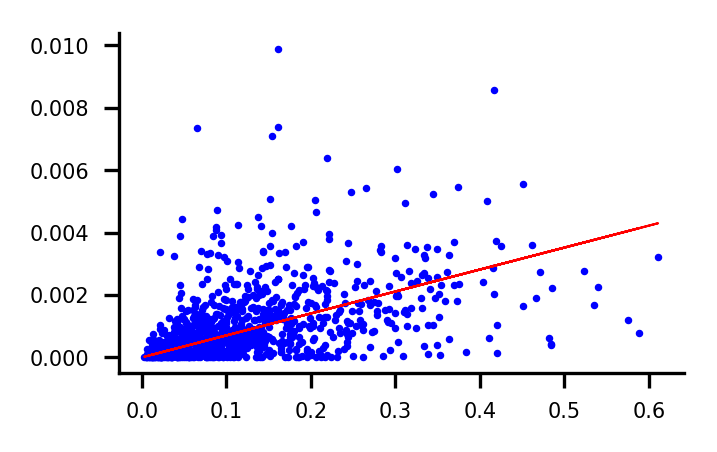

In [66]:
#forcing best fit line to start at origin
y = np.array(avg_sum_norm_abs_weights_tb_6['renew'])
x = np.array(avg_events_renew)
x = x[:,np.newaxis]
a, _, _, _ = np.linalg.lstsq(x, y)

pl.plot(x, y, 'bo',markersize=.8)
pl.plot(x, a*x, 'r-')
pl.show()

residuals_CS = np.copy(x)
for idx,x in enumerate(x):
        yfit = a*x
        residuals_CS[idx] = yfit-y[idx]

In [67]:
for sess in sessions:
    for t in 6,8,10:
        y = eval("np.array(avg_sum_norm_abs_weights_tb_%s[sess])"%t)
        x = eval("np.array(avg_events_%s)"%(sess))
        x=x[:,np.newaxis]
        a,_,_,_ = np.linalg.lstsq(x,y)
        exec("residuals_tb_%s_%s=np.copy(x)"%(t,sess))
        for idx,x in enumerate(x):
            yfit = a*x
            exec("residuals_tb_%s_%s[idx] = yfit-y[idx]"%(t,sess))
        exec("residuals_tb_%s_%s_list =[]"%(t,sess))
        for idx in eval("residuals_tb_%s_%s"%(t,sess)):
            exec("residuals_tb_%s_%s_list.append(idx[0])"%(t,sess))

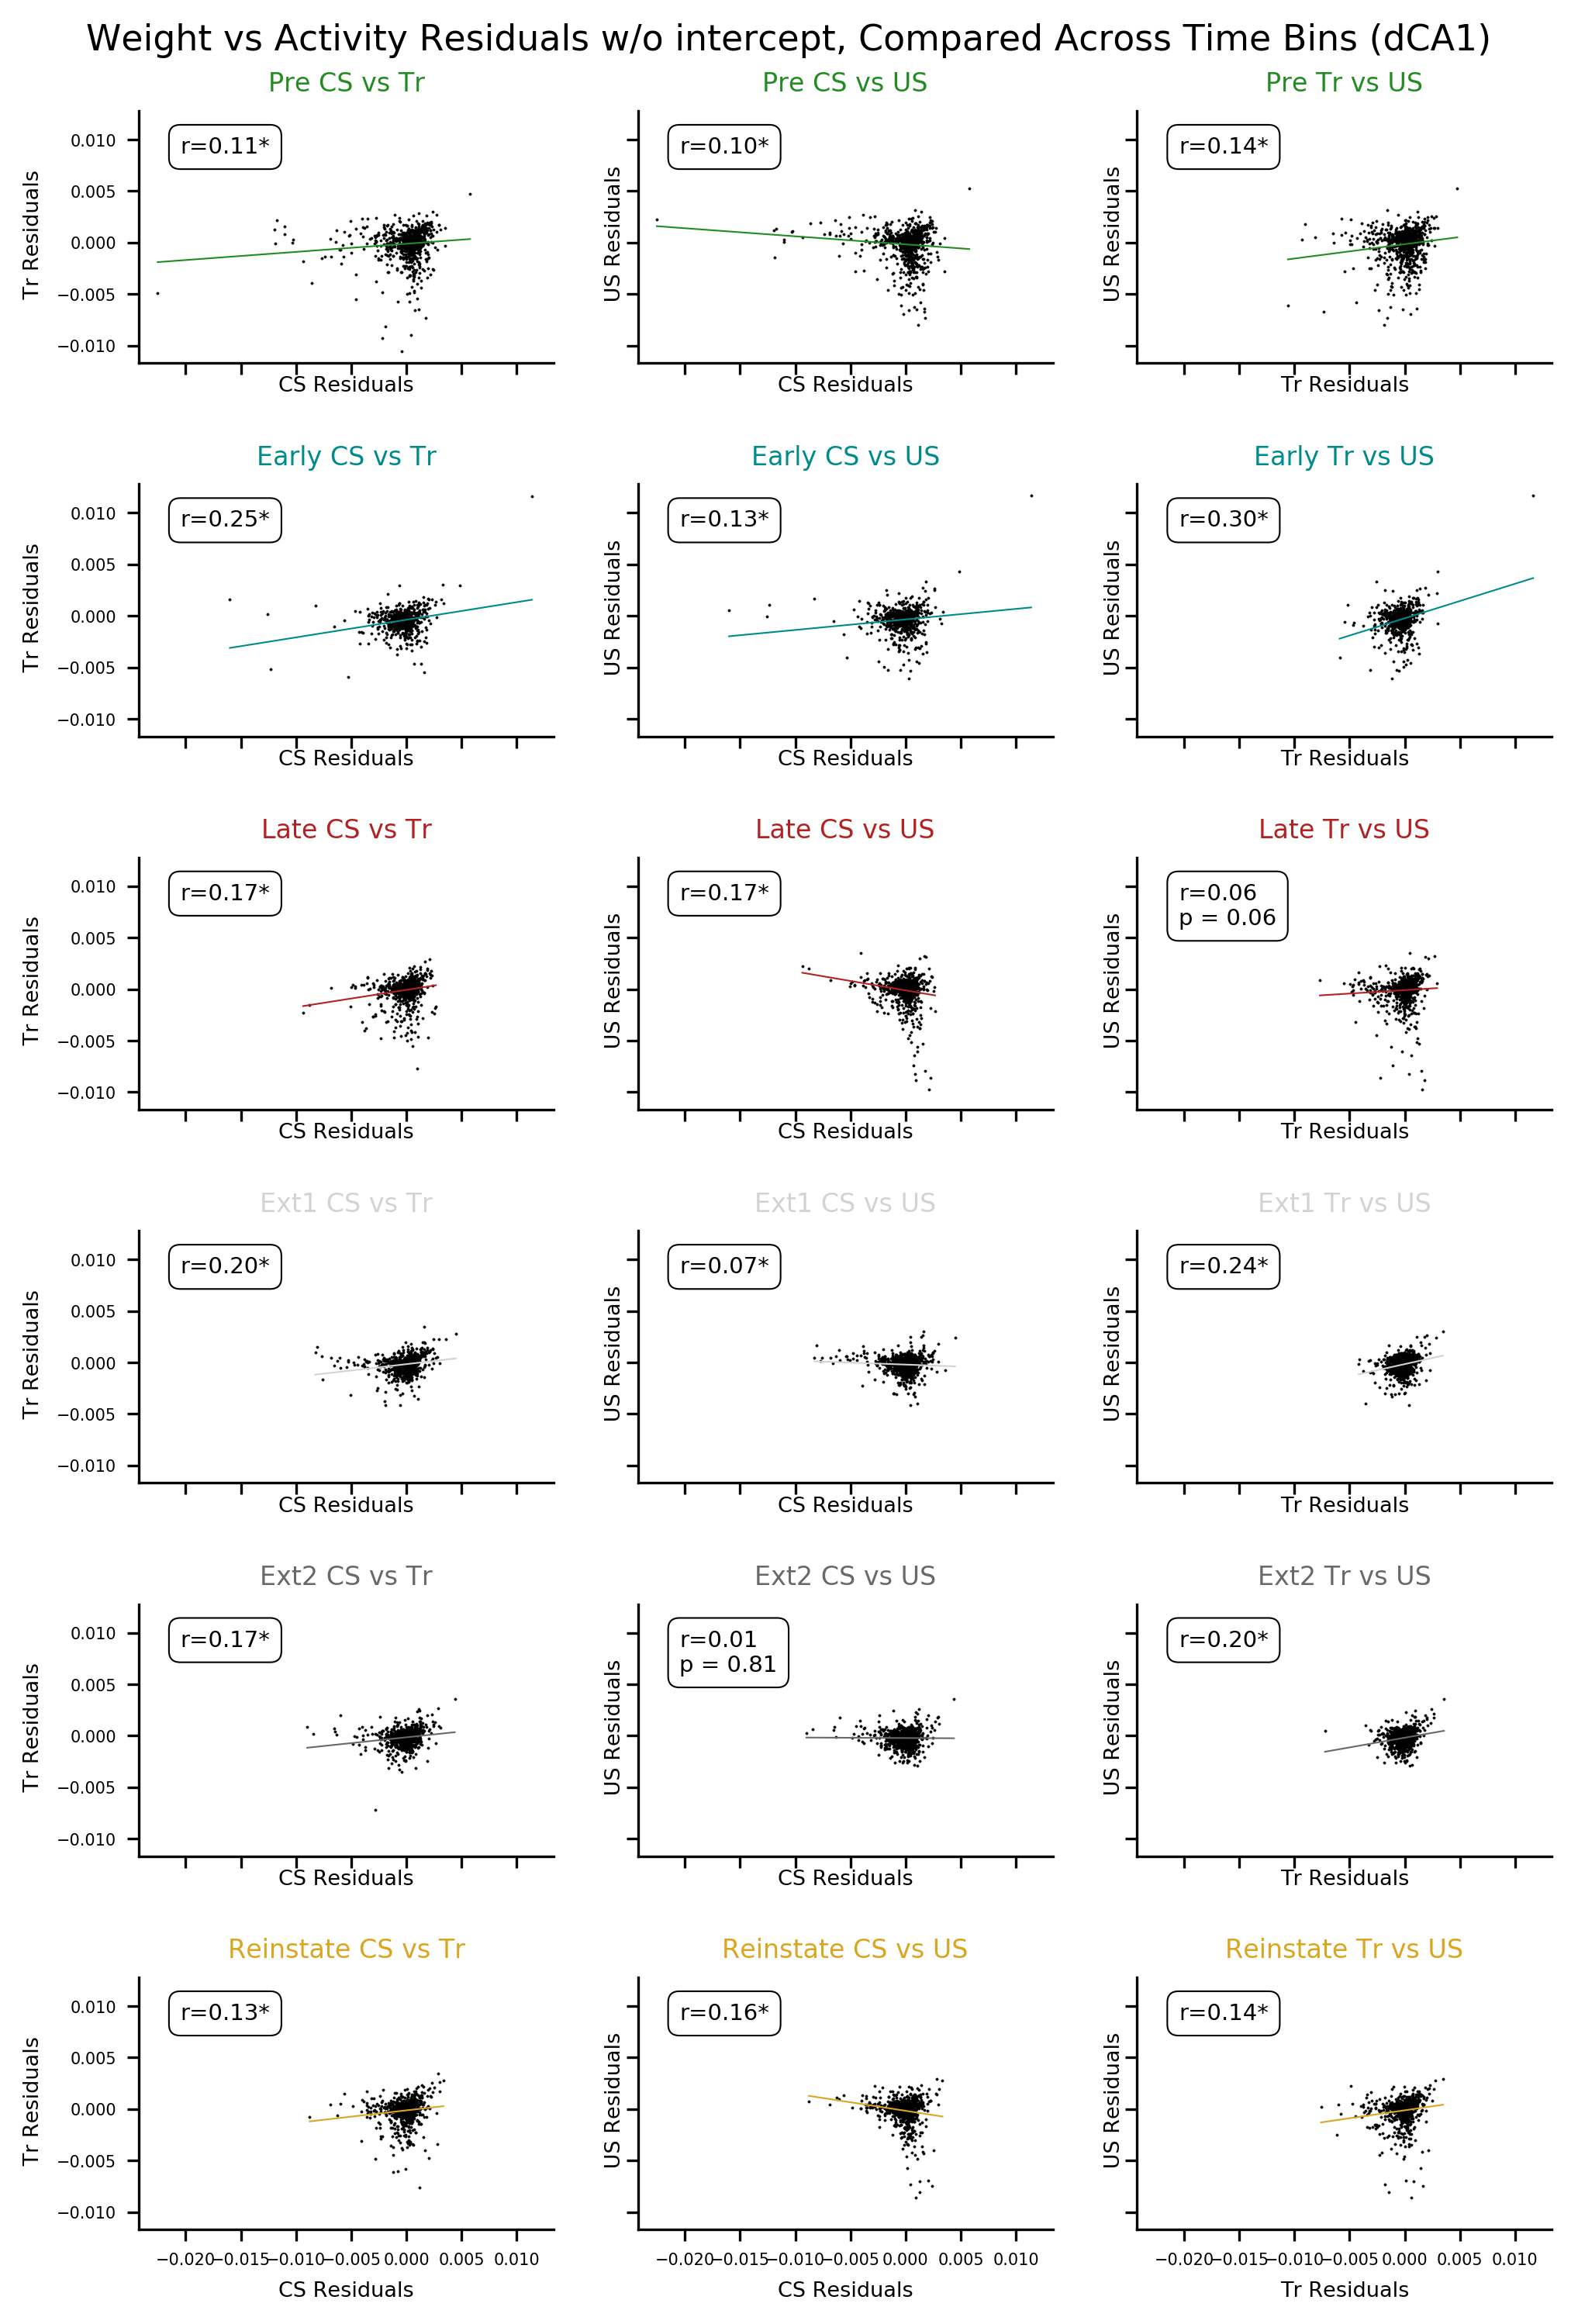

In [68]:
fig, ax = pl.subplots(6,3, figsize=(7, 10),sharex=True,sharey=True)
i=-1
colors = ('forestgreen','darkcyan','firebrick','lightgrey','dimgrey','goldenrod')
for sess,sessl in zip(sessions,('Pre','Early','Late','Ext1','Ext2','Reinstate')):
    i=i+1
    for t,tt,ttt,titl in zip(([6,8],[6,10],[8,10]),(1,3,5),range(0,3),('CS vs Tr','CS vs US','Tr vs US')):
        x = eval("residuals_tb_%s_%s_list"%(t[0],sess))
        y = eval("residuals_tb_%s_%s_list"%(t[1],sess))
        ax[i][ttt].plot(x,y,'ko',markersize=.8,mew=.1)
    #ax[i].set_xlim(-.08,.08)
    #ax[i].set_ylim(-.08,.08)
    #for tb,lc,d in zip(('5','7','8','9','10','11','12'),('r','orange','g','cyan','b','purple','k'),
    #                   ('0','2','3','4','5','6','7')):
    #    y = eval("avg_sum_norm_abs_weights_tb_%s[sess]"%tb)
        slope, intercept, r_value, p_value, std_err = sstats.linregress(x,y)
        line = slope*(np.unique(x))+intercept
        r2 = r_value*r_value
        if p_value < 0.05:
            lbl = '*'
        else:
            lbl = '\np = {:.2f}'.format(p_value)
        ax[i][ttt].plot(np.unique(x), line, colors[i], label=('r$^2$ = {:.2f}\n'.format(r2))+lbl)
        ax[i][ttt].set_title(sessl+' '+titl,color=colors[i],fontsize=8)
        #ax[i][ttt].legend(loc='best',prop={'size': 5.5})
        ax[i][ttt].set_xlabel(titl.split('vs')[0]+"Residuals",fontsize=6.5)
        #ax[i][ttt].invert_xaxis()
        #ax[i][ttt].set_xlim(0)
        #ax[i][ttt].set_ylim(0)
        #ax[i][ttt].vlines(-1.3,0,1,linestyles='dashed',color='b')
        ax[i][ttt].set_ylabel(titl.split('vs')[1]+" Residuals",fontsize=6.5)
        ax[i][ttt].text(0.1,0.9,('r={:.2f}'.format(abs(r_value))+lbl),transform=ax[i][ttt].transAxes,fontsize=7,verticalalignment='top',
                        bbox=dict(facecolor='none',edgecolor='black',boxstyle='round',linewidth=.5,pad=0.5))
pl.suptitle('Weight vs Activity Residuals w/o intercept, Compared Across Time Bins (dCA1)',fontsize=11, y=1)

#pl.xlim(-.08,.08)
#pl.ylim(-.08,.08)
fig.tight_layout(pad=3)
pl.savefig("../img/%s_weightVSactivity_residuals_comparison_NOintercept.pdf"%NOTEBOOK_NAME)

### and now use residuals of log10 transformed activity/weight values

In [69]:
for sess in sessions:
    for t in 6,8,10:
        y = eval("avg_sum_norm_abs_weights_tb_%s_log10[sess]"%t)
        x = eval("avg_events_%s_log10"%(sess))
        exec("residuals_tb_%s_%s_log10,m_tb_%s_%s_log10,b_tb_%s_%s_log10,r_tb_%s_%s_log10,pvalue_tb_%s_%s_log10,\
              stderr_tb_%s_%s_log10 = linregress_residuals(x,y)"%(t,sess,t,sess,t,sess,t,sess,t,sess,t,sess))

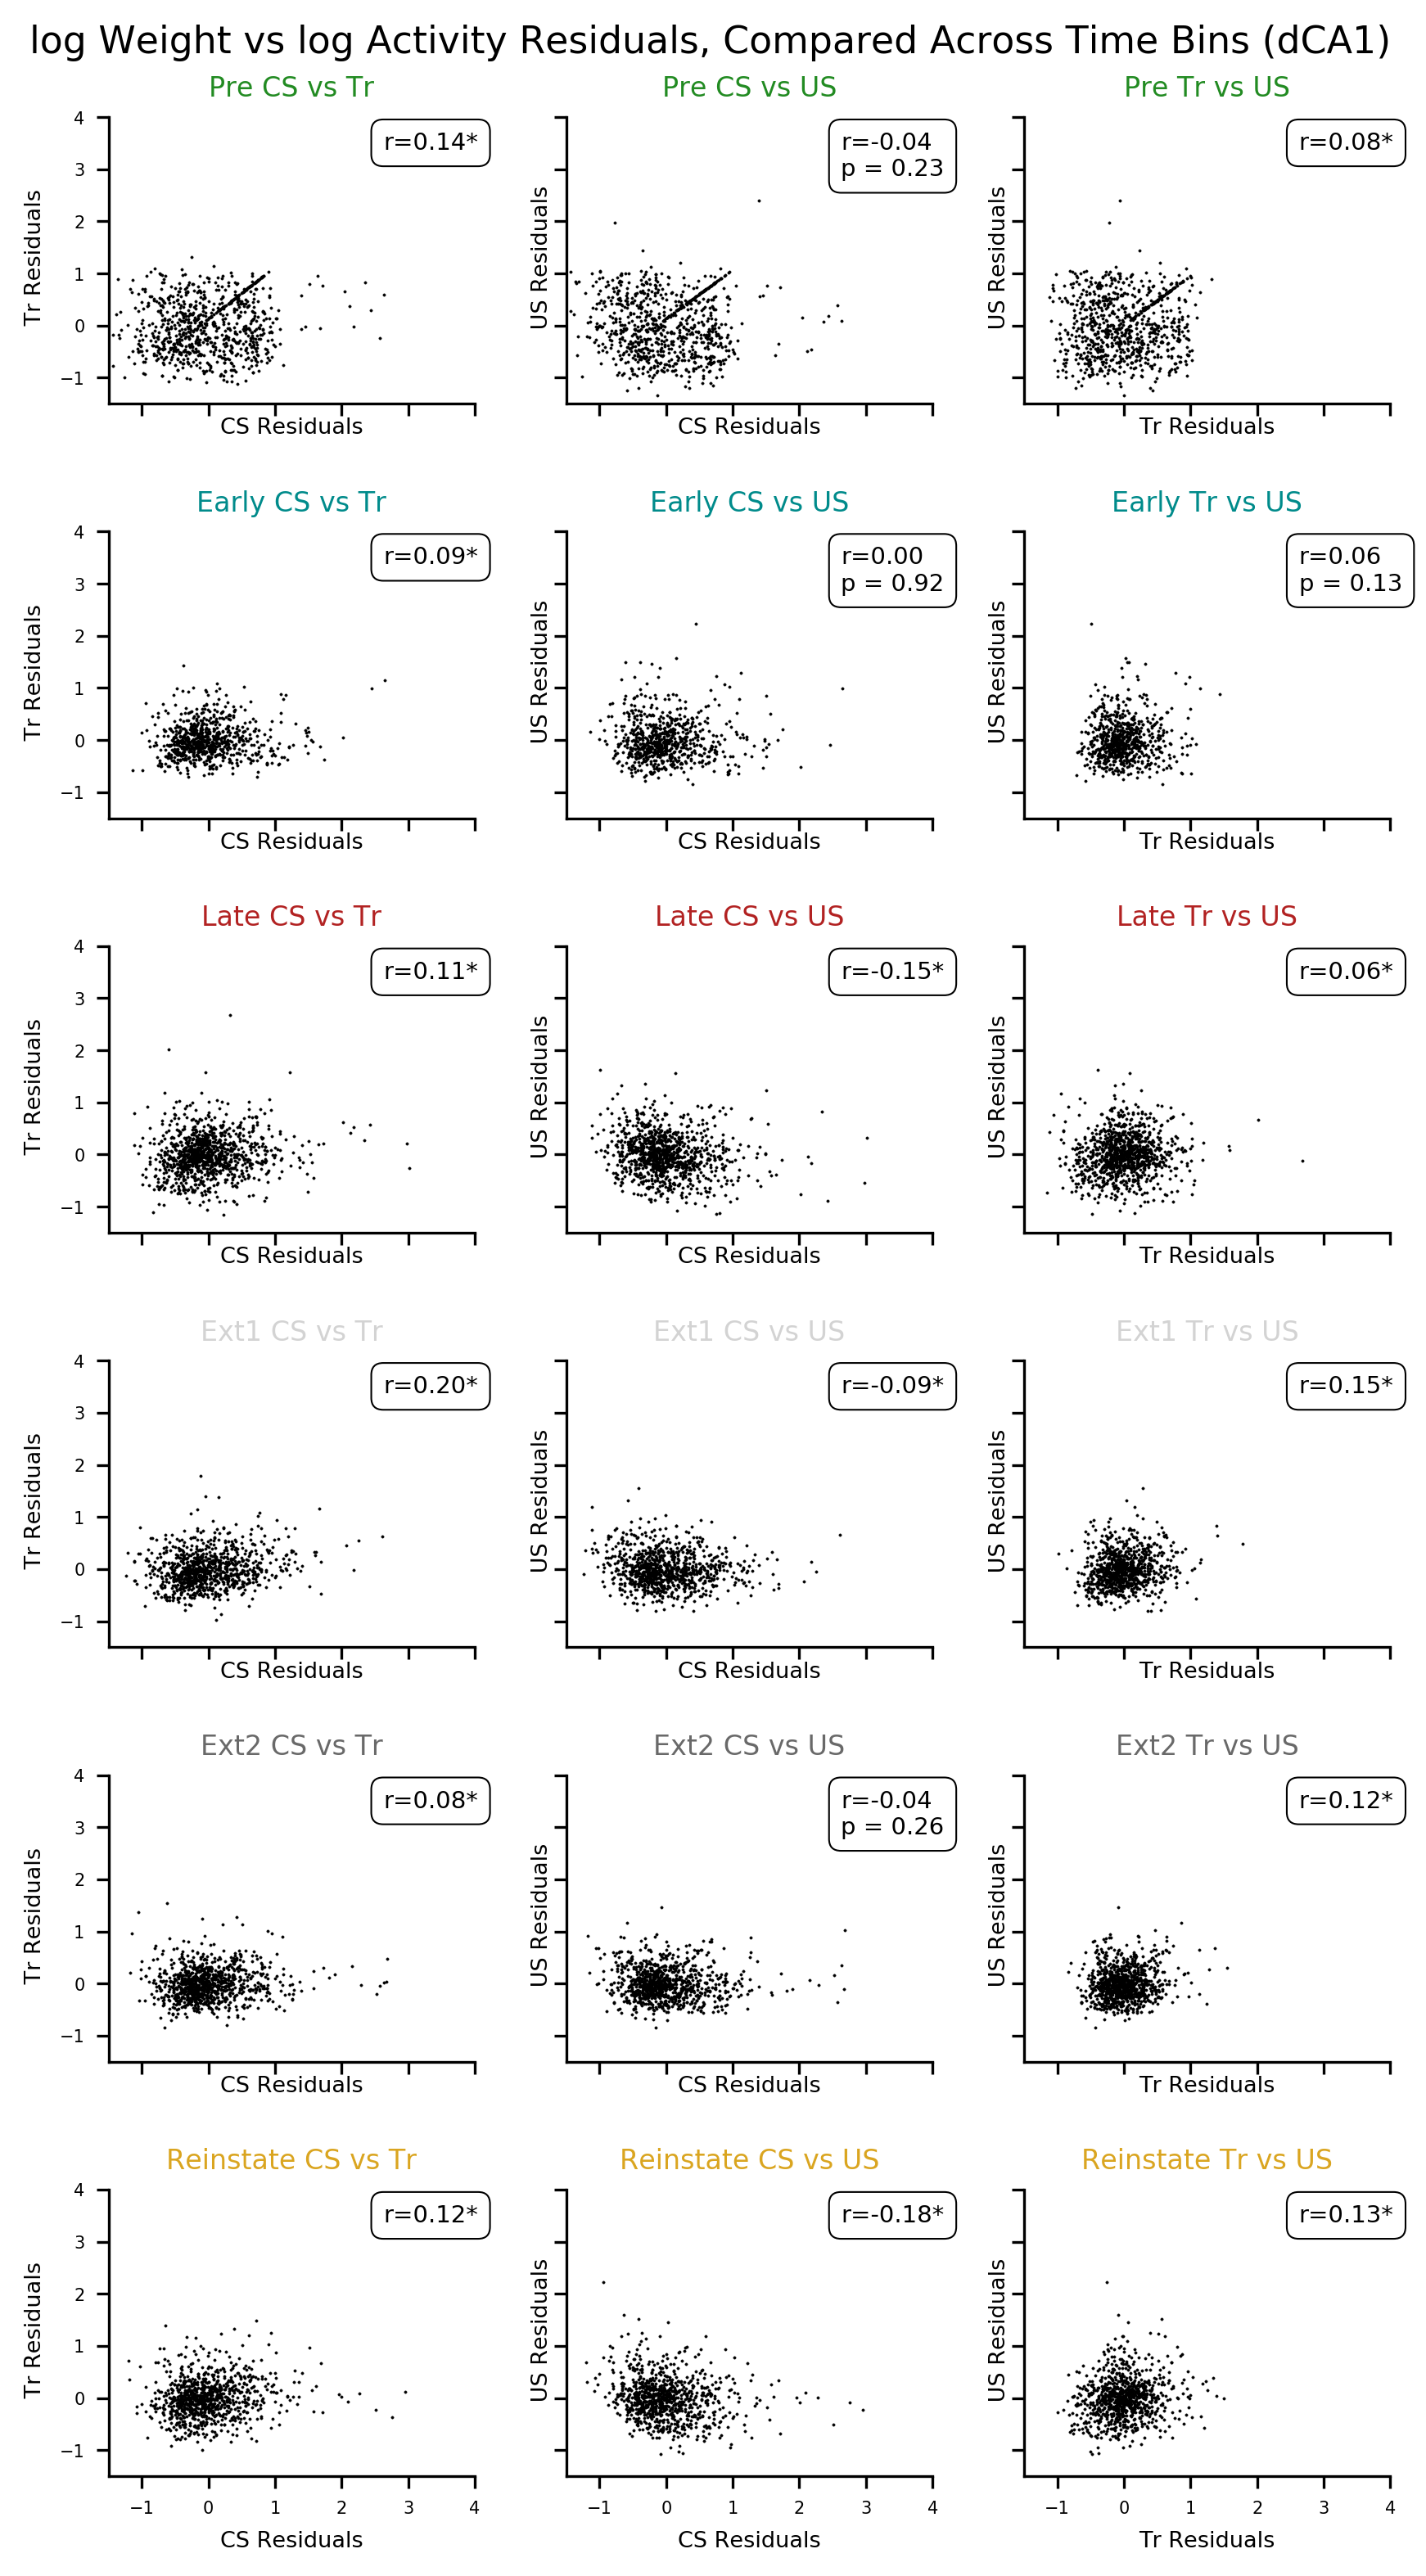

In [70]:
fig, ax = pl.subplots(6,3, figsize=(6, 10.5),sharex=True,sharey=True)
i=-1
colors = ('forestgreen','darkcyan','firebrick','lightgrey','dimgrey','goldenrod')
for sess,sessl in zip(sessions,('Pre','Early','Late','Ext1','Ext2','Reinstate')):
    i=i+1
    for t,tt,ttt,titl in zip(([6,8],[6,10],[8,10]),(1,3,5),range(0,3),('CS vs Tr','CS vs US','Tr vs US')):
        x = eval("residuals_tb_%s_%s_log10"%(t[0],sess))
        y = eval("residuals_tb_%s_%s_log10"%(t[1],sess))
        ax[i][ttt].plot(x,y,'ko',markersize=.8,mew=.1)
    #ax[i].set_xlim(-.08,.08)
    #ax[i].set_ylim(-.08,.08)
    #for tb,lc,d in zip(('5','7','8','9','10','11','12'),('r','orange','g','cyan','b','purple','k'),
    #                   ('0','2','3','4','5','6','7')):
    #    y = eval("avg_sum_norm_abs_weights_tb_%s[sess]"%tb)
        slope, intercept, r_value, p_value, std_err = sstats.linregress(x,y)
        line = slope*(np.unique(x))+intercept
        r2 = r_value*r_value
        if p_value < 0.05:
            lbl = '*'
        else:
            lbl = '\np = {:.2f}'.format(p_value)
        #ax[i][ttt].plot(np.unique(x), line, colors[i], label=('r$^2$ = {:.2f}\n'.format(r2))+lbl)
        ax[i][ttt].set_title(sessl+' '+titl,color=colors[i],fontsize=8)
        #ax[i][ttt].legend(loc='best',prop={'size': 5.5})
        ax[i][ttt].set_xlabel(titl.split('vs')[0]+"Residuals",fontsize=6.5)
        #ax[i][ttt].invert_xaxis()
        ax[i][ttt].set_xlim(-1.5,4)
        ax[i][ttt].set_ylim(-1.5,4)
        #ax[i][ttt].vlines(-1.3,0,1,linestyles='dashed',color='b')
        ax[i][ttt].set_ylabel(titl.split('vs')[1]+" Residuals",fontsize=6.5)
        ax[i][ttt].text(0.75,0.95,('r={:.2f}'.format((r_value))+lbl),transform=ax[i][ttt].transAxes,fontsize=7,verticalalignment='top',
                        bbox=dict(facecolor='none',edgecolor='black',boxstyle='round',linewidth=.5,pad=0.5))
pl.suptitle('log Weight vs log Activity Residuals, Compared Across Time Bins (dCA1)',fontsize=11, y=1)

#pl.xlim(-.08,.08)
#pl.ylim(-.08,.08)
fig.tight_layout(pad=3)
pl.savefig("../img/%s_LOG10_weightVSactivity_residuals_comparison.pdf"%NOTEBOOK_NAME)

### and now use residuals of log10 transformed activity/weight values where 0 weighted cells have been excluded

In [71]:
#extract 0 weighted cells that occur in either of the time bins we want to compare (CSvsTr,CSvsUS, TrvsUS)
for t in [(6,8),(6,10),(8,10)]:
    exec("avg_sum_norm_abs_weights_tb_%svs%s_log10_no0s = {}"%(t[0],t[1])) #will exclude all 0 weighted cells
    exec("avg_sum_norm_abs_weights_tb_%svs%s_log10_no0s = {}"%(t[1],t[0])) #will exclude all 0 weighted cells
for sess in sessions:
    for t in [(6,8),(6,10),(8,10)]:
        exec("avg_sum_norm_abs_weights_tb_%svs%s_log10_no0s[sess] = []"%(t[0],t[1]))
        exec("avg_sum_norm_abs_weights_tb_%svs%s_log10_no0s[sess] = []"%(t[1],t[0]))
        exec("avg_events_tb_%svs%s_%s_log10_no0s = []"%(t[0],t[1],sess))
        exec("avg_events_tb_%svs%s_%s_log10_no0s = []"%(t[1],t[0],sess))
        for x,y,z in zip(eval("avg_sum_norm_abs_weights_tb_%s[sess]"%t[0]),eval("avg_sum_norm_abs_weights_tb_%s[sess]"%t[1]),
                        eval("avg_events_%s"%(sess))):
            if x == 0 or y == 0:
                print '',
            else:
                exec("avg_sum_norm_abs_weights_tb_%svs%s_log10_no0s[sess].append(math.log10(x))"%(t[0],t[1]))
                exec("avg_sum_norm_abs_weights_tb_%svs%s_log10_no0s[sess].append(math.log10(y))"%(t[1],t[0]))
                exec("avg_events_tb_%svs%s_%s_log10_no0s.append(math.log10(z))"%(t[0],t[1],sess))
                exec("avg_events_tb_%svs%s_%s_log10_no0s.append(math.log10(z))"%(t[1],t[0],sess))

In [72]:
for sess in sessions:
    for t in [(6,8),(6,10),(8,10)]:
        y = eval("avg_sum_norm_abs_weights_tb_%svs%s_log10_no0s[sess]"%(t[0],t[1]))
        x = eval("avg_events_tb_%svs%s_%s_log10_no0s"%(t[0],t[1],sess))
        exec("residuals_tb_%svs%s_%s_log10_no0s,m_tb_%svs_%s_%s_log10_no0s,b_tb_%svs_%s_%s_log10_no0s,\
        r_tb_%svs_%s_%s_log10_no0s,pvalue_tb_%svs_%s_%s_log10_no0s,\
        stderr_tb_%svs_%s_%s_log10_no0s = linregress_residuals(x,y)"%(t[0],t[1],sess,t[0],t[1],sess,t[0],t[1],sess,t[0],t[1],
                                                                      sess,t[0],t[1],sess,t[0],t[1],sess))
        
        y = eval("avg_sum_norm_abs_weights_tb_%svs%s_log10_no0s[sess]"%(t[1],t[0]))
        x = eval("avg_events_tb_%svs%s_%s_log10_no0s"%(t[1],t[0],sess))
        exec("residuals_tb_%svs%s_%s_log10_no0s,m_tb_%svs_%s_%s_log10_no0s,b_tb_%svs_%s_%s_log10_no0s,\
        r_tb_%svs_%s_%s_log10_no0s,pvalue_tb_%svs_%s_%s_log10_no0s,\
        stderr_tb_%svs_%s_%s_log10_no0s = linregress_residuals(x,y)"%(t[1],t[0],sess,t[1],t[0],sess,t[1],t[0],sess,t[1],t[0],
                                                                      sess,t[1],t[0],sess,t[1],t[0],sess))

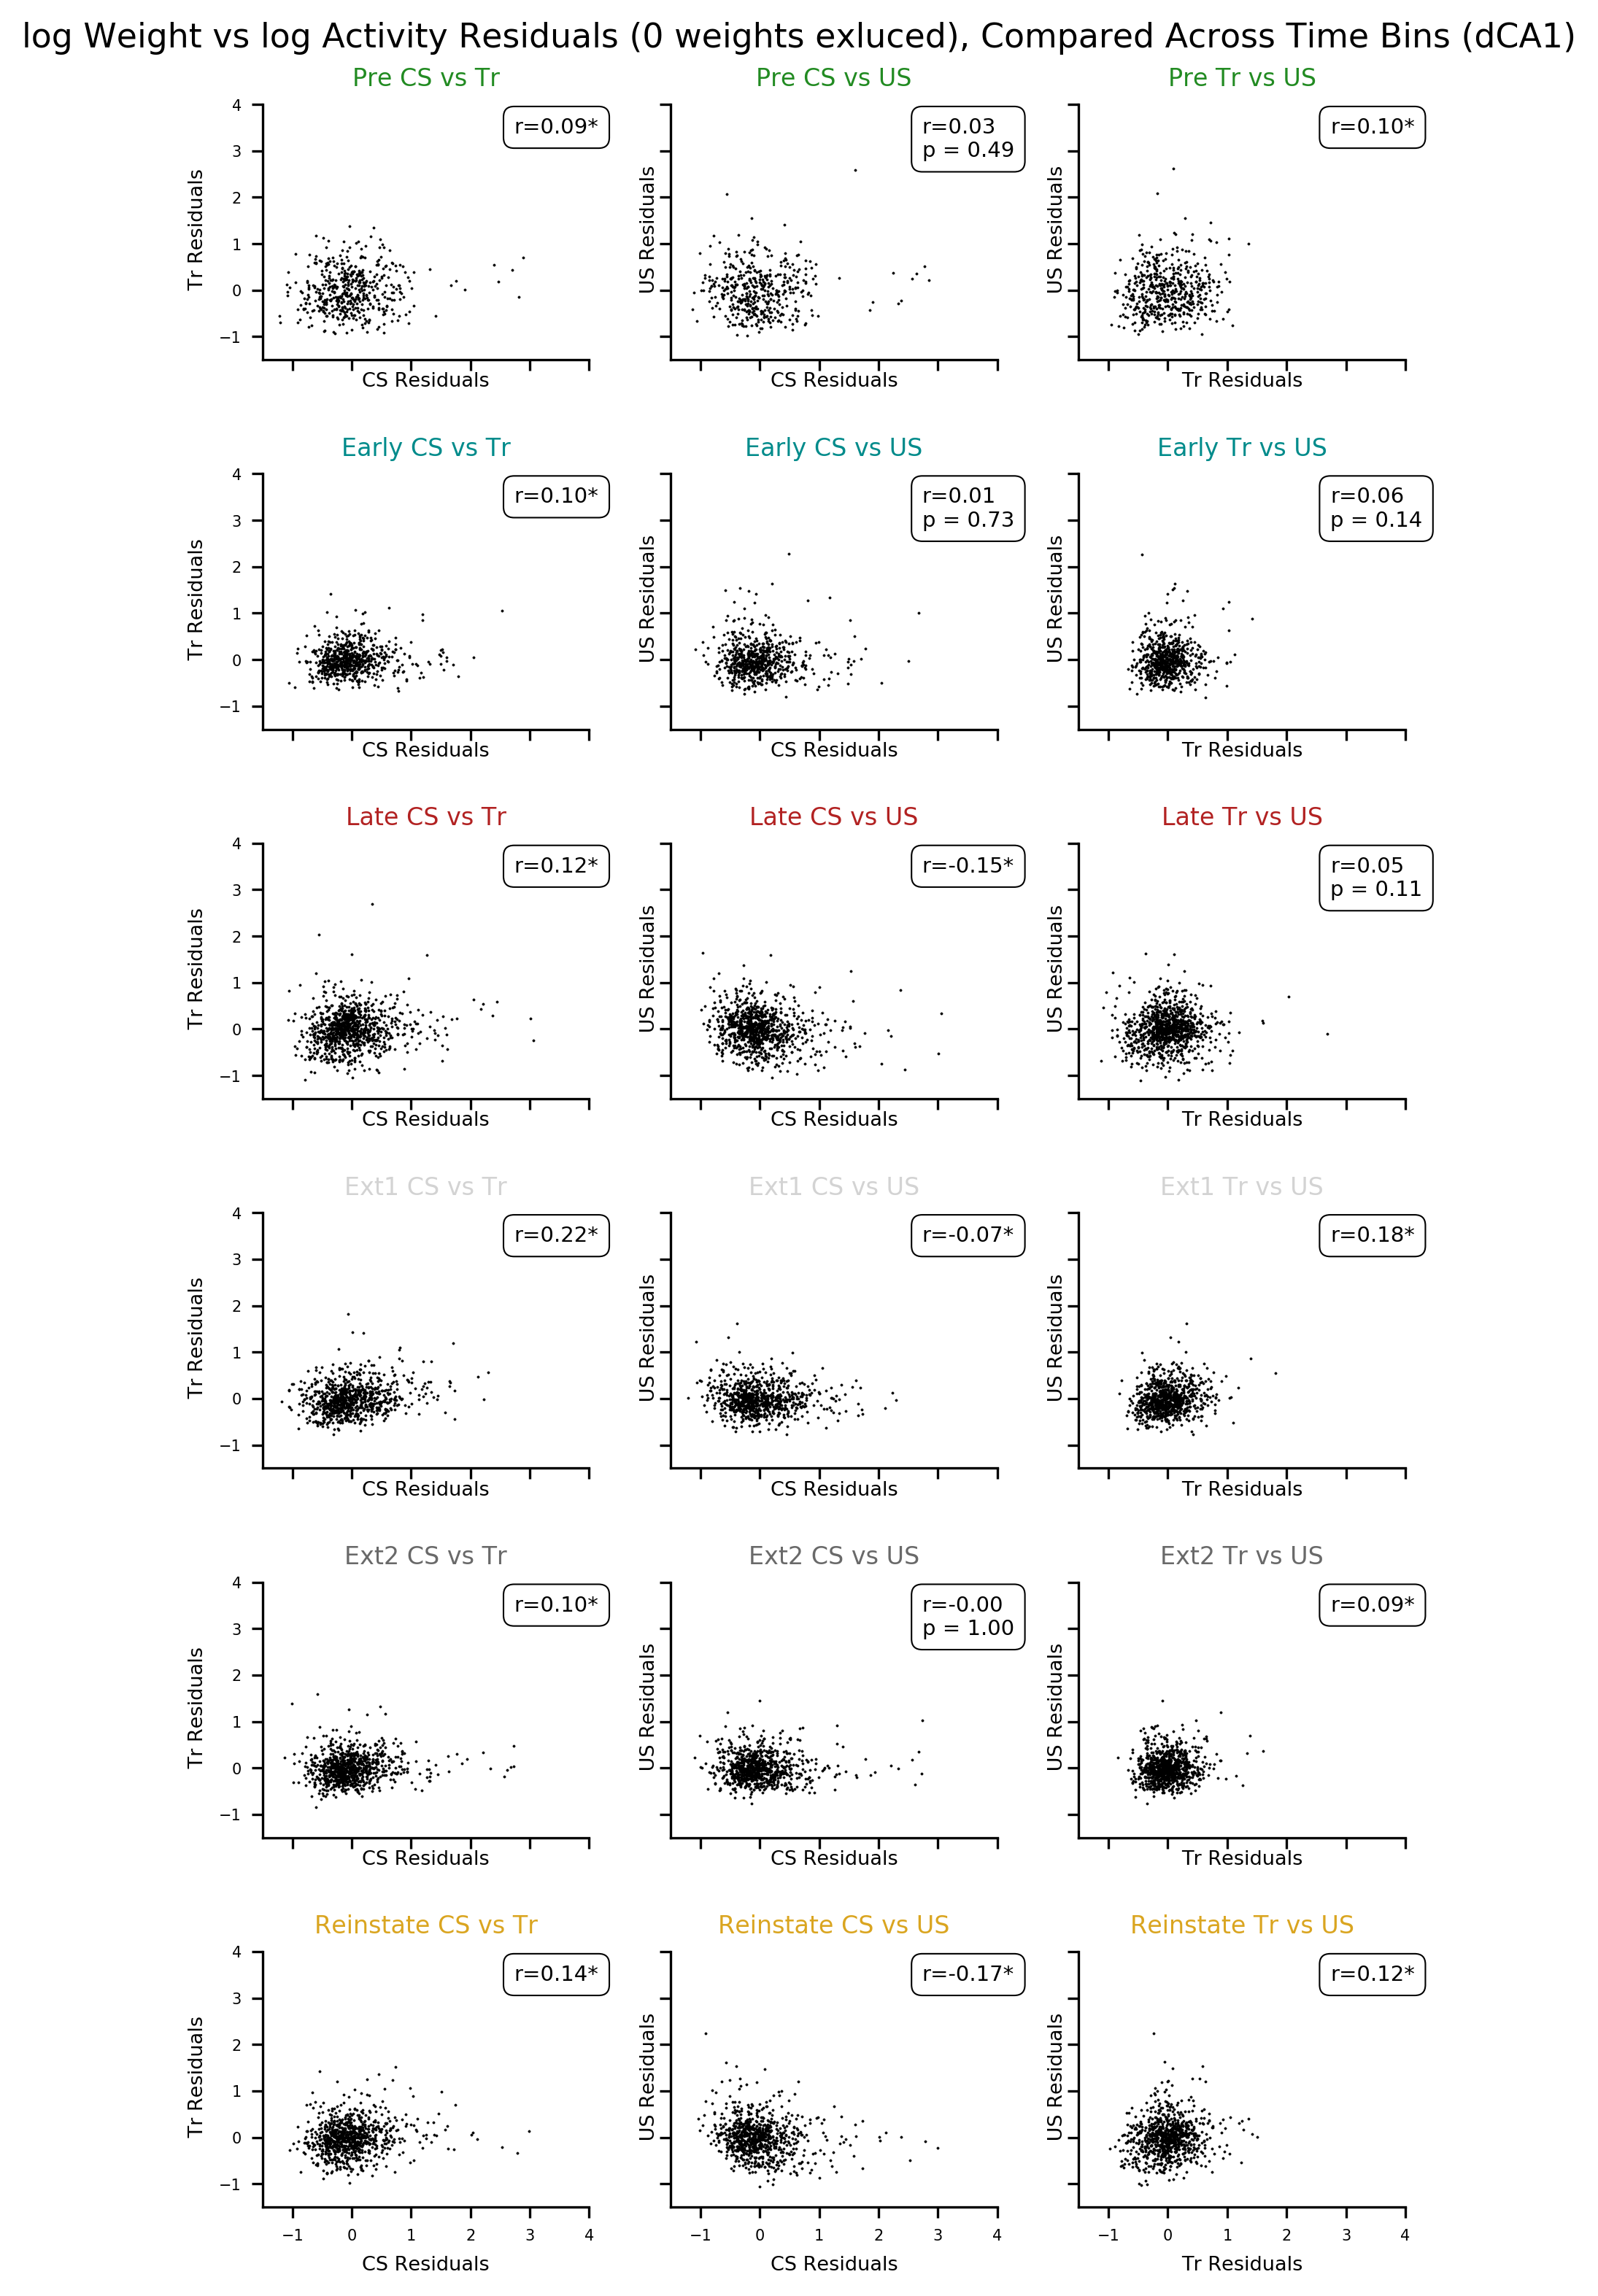

In [88]:
fig, ax = pl.subplots(6,3, figsize=(6, 10.5),sharex=True,sharey=True)
i=-1
colors = ('forestgreen','darkcyan','firebrick','lightgrey','dimgrey','goldenrod')
for sess,sessl in zip(sessions,('Pre','Early','Late','Ext1','Ext2','Reinstate')):
    i=i+1
    for t,tt,ttt,titl in zip(([6,8],[6,10],[8,10]),(1,3,5),range(0,3),('CS vs Tr','CS vs US','Tr vs US')):
        x = eval("residuals_tb_%svs%s_%s_log10_no0s"%(t[0],t[1],sess))
        y = eval("residuals_tb_%svs%s_%s_log10_no0s"%(t[1],t[0],sess))
        ax[i][ttt].plot(x,y,'ko',markersize=.8,mew=.1)
    #ax[i].set_xlim(-.08,.08)
    #ax[i].set_ylim(-.08,.08)
    #for tb,lc,d in zip(('5','7','8','9','10','11','12'),('r','orange','g','cyan','b','purple','k'),
    #                   ('0','2','3','4','5','6','7')):
    #    y = eval("avg_sum_norm_abs_weights_tb_%s[sess]"%tb)
        slope, intercept, r_value, p_value, std_err = sstats.linregress(x,y)
        line = slope*(np.unique(x))+intercept
        r2 = r_value*r_value
        if p_value < 0.05:
            lbl = '*'
        else:
            lbl = '\np = {:.2f}'.format(p_value)
        #ax[i][ttt].plot(np.unique(x), line, colors[i], label=('r$^2$ = {:.2f}\n'.format(r2))+lbl)
        ax[i][ttt].set_title(sessl+' '+titl,color=colors[i],fontsize=8)
        #ax[i][ttt].legend(loc='best',prop={'size': 5.5})
        ax[i][ttt].set_xlabel(titl.split('vs')[0]+"Residuals",fontsize=6.5)
        #ax[i][ttt].invert_xaxis()
        ax[i][ttt].set_xlim(-1.5,4)
        ax[i][ttt].set_ylim(-1.5,4)
        #ax[i][ttt].vlines(-1.3,0,1,linestyles='dashed',color='b')
        ax[i][ttt].set_ylabel(titl.split('vs')[1]+" Residuals",fontsize=6.5)
        ax[i][ttt].text(0.77,0.95,('r={:.2f}'.format((r_value))+lbl),transform=ax[i][ttt].transAxes,fontsize=7,verticalalignment='top',
                        bbox=dict(facecolor='none',edgecolor='black',boxstyle='round',linewidth=.5,pad=0.5))
pl.suptitle('log Weight vs log Activity Residuals (0 weights exluced), Compared Across Time Bins (dCA1)',fontsize=11, y=1)

#pl.xlim(-.08,.08)
#pl.ylim(-.08,.08)
fig.tight_layout(pad=3)
pl.savefig("../final-ish figures/%s_LOG10_weightVSactivity_residuals_comparison_no0s.pdf"%NOTEBOOK_NAME)

In [80]:
save_workspace(db)

Could not store variable 'sstats'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'collections'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'math'. Skipping...
Could not store variable 'di'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'IPython'. Skipping...
